<div style="border-radius:10px; border:#e7c6ff solid; padding: 15px; background-color: #f6f5f5; font-size:100%; text-align:left">

Image classification is one of the core supervised learning tasks. The goal is simple: train a model on labeled images so it can correctly predict the class of new, unseen ones. During training, the model learns from labeled examples, makes predictions, evaluates its performance using a loss function, and adjusts its internal weights through optimization techniques like gradient descent

But here's the catch: supervised learning only works well if your data is solid. You need enough labeled samples for the model to learn from, and if the labels are noisy or scarce, you're in trouble. There's a golden rule in machine learning that goes:

<h2 style="font-size: 42px; font-family: 'Roboto Mono', monospace; color: #2a1a3a; text-align: center; max-width: 2000px;">
  Fix the <b style="color: #b8860b;">data</b> first, then worry about the model
</h2>


This project is a perfect case study for that.

<div style="border-radius:10px; border:#e7c6ff solid; padding: 15px; background-color: #f6f5f5; font-size:100%; text-align:left">
    
#### The Challenge
 
The task is to classify sheep breeds using a small labeled dataset (`train.csv` + `images`) and make predictions on an unlabeled test set. Sounds straightforward, but there are a few twists that make it harder than it looks:

- **The dataset is small:** We're dealing with just 682 images spread across 7 classes, that's fewer than 100 samples per class

- **The dataset is imbalanced:** Some classes dominate, while others are severely underrepresented. Naturally, the model tends to favor the majority classes and ignore the rest
- **The data isn't perfectly clean:** Some images contain multiple sheep from possibly different breeds. Don't laugh at me but even me as a human, I found it hard to tell them apart sometimes
- **The evaluation metric is F1 score:** F1 is unforgiving. It only cares whether you got the prediction exactly right. There's no reward for being “close”, even if your model is 95% sure an image is class A but picks class B by mistake, that’s a zero. It’s all or nothing. And with 7 classes to choose from, the odds aren't always in your favor

#### The Plan

In this notebook, I walk through a full pipeline to tackle the above issues using a semi-supervised approach. Here’s what we’ll do:

- First, we split the labeled data for 5-fold cross-validation
- We apply strong augmentations to the training images, and just resizing + normalization for validation
- Since the classes are imbalanced, we compute class weights and pass them to the cross-entropy loss function

For modeling, we’ll use a Vision Transformer (ViT) backbone with a custom classification head

Then we move in two main stages:

1. Initial Training
    We train the model using cross-validation only on the labeled data

2. Pseudo-Labeling + Clustering
    We predict on the test set and retain only the most confident predictions. Then, we go one step further by clustering the feature representations of the test images using KMeans and extracting high-purity samples
    These are then **merged** with the training set to form a richer, more confident dataset. The model is retrained again on this merged dataset to produce the final predictions

# 1. Setup and Configuration

Okay, let’s get our hands dirty. First things first, we’ll import the necessary libraries, set up the environment, and define a few configuration values to keep things organized

In [1]:
# ======================
# Standard Library Imports
# ======================
import os
import random
from pathlib import Path
from typing import Any, Dict
import warnings
warnings.filterwarnings('ignore')

# ======================
# 3rd-Party Imports
# ======================
import numpy as np
import pandas as pd
from PIL import Image
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from collections import Counter
from scipy.spatial.distance import cdist
import umap

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

import timm

import albumentations as A
from albumentations.pytorch import ToTensorV2

E0000 00:00:1750289565.750575      87 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750289565.758181      87 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Let’s define a `Config` object to store all the key settings, things like directory paths, model name, and training parameters. You’ll see this pop up a lot throughout the notebook

**Note:** The variables in this class are used across multiple functions and classes without being passed as arguments, so it’s best not to rename them later on

In [2]:
# ======================
# MAIN CONFIGURATIONS
# ======================
class Config:

    seed=7
    img_size=224
    model_name='vit_base_patch16_224.augreg_in21k_ft_in1k'
    num_classes=7
    batch_size=8
    epochs=50
    lr=1e-4
    min_lr=1e-6
    n_folds=5
    patience=5
    train_csv='/kaggle/input/sheep-classification-challenge-2025/Sheep Classification Images/train_labels.csv'
    train_dir='/kaggle/input/sheep-classification-challenge-2025/Sheep Classification Images/train'
    test_dir='/kaggle/input/sheep-classification-challenge-2025/Sheep Classification Images/test'
    models_dir='models'
    results_dir='results'
    processed_data_dir='processed_data'
    device="cuda" if torch.cuda.is_available() else "cpu"

    os.makedirs(models_dir, exist_ok=True)
    os.makedirs(results_dir, exist_ok=True)
    os.makedirs(processed_data_dir, exist_ok=True)

class SeedManager:
    def __init__(self, seed: int):
        self.seed = seed

    def seed_everything(self):
        random.seed(self.seed)
        np.random.seed(self.seed)
        torch.manual_seed(self.seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(self.seed)

        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        print(f"Seeds set to: {self.seed}")

In [3]:
CONFIG = Config()
# Setting a seed for reproducibility
SeedManager(CONFIG.seed).seed_everything()

# Creating new folders, for initial results, and final results (will be used later)
INITIAL_RESULTS_DIR = os.path.join(CONFIG.results_dir, "initial_results")
os.makedirs(INITIAL_RESULTS_DIR, exist_ok=True)

PSEUDO_RESULTS_DIR = os.path.join(CONFIG.results_dir, "final_results")
os.makedirs(PSEUDO_RESULTS_DIR, exist_ok=True)

Seeds set to: 7


# 2. Custom Classes, Functions


In this section, we’ll define all the helper classes and functions we’ll be using throughout the notebook

In [58]:
# ======================
# CUSTOM DATASET CLASSES
# ======================
class SheepDataset(Dataset):
    def __init__(self, df=None, image_dir=None, transform=None, is_test=False):
        self.image_dir = image_dir
        self.transform = transform
        self.is_test = is_test

        if self.is_test:
            # For test set, just get sorted list of image files
            self.img_files = sorted(os.listdir(image_dir))
        else:
            # For train/val set, use dataframe with filenames and labels
            self.df = df.reset_index(drop=True)

    def __len__(self):
        return len(self.img_files) if self.is_test else len(self.df)

    def __getitem__(self, idx):
        if self.is_test:
            filename = self.img_files[idx]
            img_path = os.path.join(self.image_dir, filename)
            image = Image.open(img_path).convert("RGB")
            image = np.array(image)
            if self.transform:
                image = self.transform(image=image)["image"]
            return image, filename
        else:
            row = self.df.iloc[idx]
            img_path = os.path.join(self.image_dir, row["filename"])
            image = Image.open(img_path).convert("RGB")
            image = np.array(image)
            if self.transform:
                image = self.transform(image=image)["image"]
            label = row["label"]
            return image, torch.tensor(label, dtype=torch.long)


class PseudoDataset(Dataset):
    def __init__(self, df, train_dir, test_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.train_dir = train_dir
        self.test_dir = test_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        filename = row["filename"]
        label = row["label"]
        source = row.get("source", "train")
        confidence = row.get(
            "confidence", 1.0
        )  # default to 1.0 for clean training data

        img_dir = self.test_dir if source == "pseudo" or source == "cluster" else self.train_dir
        img_path = os.path.join(img_dir, filename)

        image = Image.open(img_path).convert("RGB")
        image = np.array(image)

        if self.transform:
            image = self.transform(image=image)["image"]

        return (
            image,
            torch.tensor(label, dtype=torch.long),
            torch.tensor(confidence, dtype=torch.float),
        )
    

# ======================
# DATA AUGMENTATION FUNCTIONS
# ======================
def get_train_transforms():
    return A.Compose(
        [
            A.Resize(CONFIG.img_size, CONFIG.img_size),

            # Geometric augmentations
            A.HorizontalFlip(p=0.5),
            A.Affine(
                scale=(0.9, 1.1),
                translate_percent=(0.0, 0.1),
                rotate=(-15, 15),
                shear=5,
                border_mode=cv2.BORDER_CONSTANT,
                fill=(0, 0, 0),
                p=0.7,
            ),

            # Color & contrast adjustments
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
            A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=0.2),
            A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=15, val_shift_limit=10, p=0.3),

            # Blur / distortion
            A.OneOf(
                [
                    A.MotionBlur(blur_limit=3, p=1.0),
                    A.MedianBlur(blur_limit=3, p=1.0),
                ],
                p=0.2,
            ),
            A.GridDistortion(num_steps=5, distort_limit=0.03, p=0.1),
            A.ElasticTransform(alpha=1, sigma=50, p=0.1),

            # Weather simulation
            A.RandomFog(
                fog_coef_range=(0.1, 0.3),  # tuple of min and max fog intensity
                alpha_coef=0.08,
                p=0.2
            ),
            A.RandomRain(blur_value=3, brightness_coefficient=0.9, p=0.1),

            # Occlusion
            A.CoarseDropout(
                num_holes_range=(3, 6),
                hole_height_range=(10, 32),
                hole_width_range=(10, 32),
                fill=0,
                p=0.3,
            ),

            # Normalize and tensor
            A.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225]),
            ToTensorV2(),
        ]
    )

def get_valid_transforms():
    return A.Compose(
        [
            A.Resize(CONFIG.img_size, CONFIG.img_size),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2(),
        ]
    )


# ======================
# COMPUTE CLASS WEIGHTS
# ======================
def compute_class_weights(labels, method="balanced"):
    labels = np.asarray(labels)
    assert np.issubdtype(labels.dtype, np.integer), "Labels must be integers."
    classes = np.unique(labels)

    if method == "balanced":
        weights = compute_class_weight("balanced", classes=classes, y=labels)
    elif method == "effective":
        # Effective number of samples
        beta = 0.9999
        effective_num = 1.0 - np.power(beta, np.bincount(labels))
        weights = (1.0 - beta) / np.array(effective_num)
        weights = weights / weights.sum() * len(classes)

    return torch.tensor(weights, dtype=torch.float)

In [5]:
# ======================
# MODEL ARCHITECTURE
# ======================

class ViTClassifier(nn.Module):
    def __init__(self, backbone_name, num_classes, dropout_rate=0.4):
        super().__init__()
        self.backbone = timm.create_model(backbone_name, pretrained=True)
        in_features = self.backbone.num_features
        self.backbone.reset_classifier(0)  # Remove default classifier head

        self.classifier = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.BatchNorm1d(512),
            nn.GELU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, num_classes),
        )

        self._init_weights()

    def _init_weights(self):
        for m in self.classifier.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        features = self.backbone(x)
        return self.classifier(features)

    def get_features(self, x):
        with torch.no_grad():
            feats = self.backbone.forward_features(x)
            feats = self.backbone.forward_head(
                feats, pre_logits=True
            )  # get final embedding
            return feats
        

# ======================
# FOCAL LOSS
# ======================

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction="mean"):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets, weights=None):
        ce_loss = nn.functional.cross_entropy(
            inputs, targets, weight=self.alpha, reduction="none"
        )
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss

        if weights is not None:
            focal_loss = focal_loss * weights

        if self.reduction == "mean":
            return focal_loss.mean()
        elif self.reduction == "sum":
            return focal_loss.sum()
        else:
            return focal_loss
        

# ======================
# OPTIMIZER AND SCHEDULER
# ======================

def get_optimizer_scheduler(model, train_loader, epochs):

    head_params = []
    backbone_params = []
    for name, param in model.named_parameters():
        if "classifier" in name:
            head_params.append(param)
        else:
            backbone_params.append(param)
    param_groups = [
        {
            "params": backbone_params,
            "lr": float(CONFIG.lr) * 0.1,
        },  # Backbone with lower LR
        {
            "params": head_params,
            "lr": float(CONFIG.lr),
        },  # Classifier with base LR
    ]

    optimizer = torch.optim.AdamW(
        param_groups, weight_decay=0.01, betas=(0.9, 0.999), eps=1e-8
    )

    # Cosine annealing with warm restarts
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer,
        T_0=len(train_loader) * 3,  # Restart every 3 epochs
        T_mult=2,
        eta_min=float(CONFIG.min_lr),
    )

    return optimizer, scheduler

In [6]:
# ======================
# EARLY STOPPING
# ======================

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_score = None
        self.counter = 0
        self.best_weights = None

    def __call__(self, val_score, model):
        if self.best_score is None:
            self.best_score = val_score
            self.save_checkpoint(model)
        elif val_score < self.best_score + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                if self.restore_best_weights:
                    model.load_state_dict(self.best_weights)
                return True
        else:
            self.best_score = val_score
            self.counter = 0
            self.save_checkpoint(model)
        return False

    def save_checkpoint(self, model):
        self.best_weights = model.state_dict().copy()


# ======================
# TRAINING AND EVALUATION
# ======================

def train_cross_validation(df, pseudo_train=False, results_dir=None):
    if results_dir is None:
        results_dir = CONFIG.results_dir

    class_weights = compute_class_weights(df["label"].values, method="effective").to(
        CONFIG.device
    )
    # print(f"Class weights: {class_weights}")

    criterion = FocalLoss(alpha=class_weights, gamma=2.0)
    skf = StratifiedKFold(
        n_splits=CONFIG.n_folds, shuffle=True, random_state=CONFIG.seed
    )

    fold_scores = []
    for fold, (train_idx, val_idx) in enumerate(skf.split(df, df.label)):
        print(f"\n{'=' * 70} FOLD {fold+1} {'=' * 70}")
        train_df = df.iloc[train_idx]
        val_df = df.iloc[val_idx]

        # --- Create fold-specific directories ---
        if pseudo_train:
            fold_results_dir = os.path.join(results_dir, f"fold_{fold+1}")
            model_name = f"pseudo_fold_{fold+1}.pth"
        else:
            fold_results_dir = os.path.join(results_dir, f"fold_{fold+1}")
            model_name = f"cv_fold_{fold+1}.pth"
        os.makedirs(fold_results_dir, exist_ok=True)
        # ----------------------------------------

        # Print fold class distribution
        print(
            f"Train distribution: {train_df['label'].value_counts().sort_index().tolist()}, Length: {len(train_df)}"
        )
        print(
            f"Val distribution: {val_df['label'].value_counts().sort_index().tolist()}, Length: {len(val_df)}"
        )
        if pseudo_train:
            train_ds = PseudoDataset(
                train_df, CONFIG.train_dir, CONFIG.test_dir, get_train_transforms()
            )
            val_ds = PseudoDataset(
                val_df, CONFIG.train_dir, CONFIG.test_dir, get_valid_transforms()
            )
        else:
            train_ds = SheepDataset(train_df, CONFIG.train_dir, get_train_transforms())
            val_ds = SheepDataset(val_df, CONFIG.train_dir, get_valid_transforms())

        train_loader = DataLoader(
            train_ds,
            batch_size=CONFIG.batch_size,
            shuffle=True,
            num_workers=4,
            pin_memory=True,
            drop_last=True,
        )
        val_loader = DataLoader(
            val_ds,
            batch_size=CONFIG.batch_size,
            shuffle=False,
            num_workers=4,
            pin_memory=True,
        )

        model = ViTClassifier(CONFIG.model_name, CONFIG.num_classes).to(CONFIG.device)
        optimizer, scheduler = get_optimizer_scheduler(
            model, train_loader, CONFIG.epochs
        )
        scaler = torch.amp.GradScaler(device=CONFIG.device)
        early_stopping = EarlyStopping(patience=CONFIG.patience)

        # Initialize history tracking for this fold
        history = {
            "train_loss": [],
            "train_acc": [],
            "val_loss": [],
            "val_acc": [],
            "val_f1_macro": [],
            "val_f1_weighted": [],
        }

        best_f1 = 0
        class_report, cm = "", ""

        for epoch in range(CONFIG.epochs):
            train_loss, train_acc = train_one_epoch(
                model, train_loader, optimizer, criterion, scheduler, scaler, epoch
            )

            eval_results = evaluate(model, val_loader, criterion)

            val_f1_macro = eval_results["metrics"]["f1_macro"]
            val_f1_weighted = eval_results["metrics"]["f1_weighted"]
            val_acc = eval_results["metrics"]["accuracy"]
            val_loss = eval_results["metrics"]["avg_loss"]
            all_labels = eval_results["predictions"]["all_labels"]
            all_preds = eval_results["predictions"]["all_preds"]

            # Store metrics in history
            history["train_loss"].append(train_loss)
            history["train_acc"].append(train_acc)
            history["val_loss"].append(val_loss)
            history["val_acc"].append(val_acc)
            history["val_f1_macro"].append(val_f1_macro)
            history["val_f1_weighted"].append(val_f1_weighted)

            print(
                f"Fold {fold+1} | Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
                f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | "
                f"Val F1 Macro: {val_f1_macro:.4f} | Val F1 Weighted: {val_f1_weighted:.4f}"
            )

            if val_f1_macro > best_f1:
                best_f1 = val_f1_macro
                torch.save(
                    model.state_dict(),
                    os.path.join(CONFIG.models_dir, model_name),
                )
                # Generate and store the classification report only when a new best model is found
                class_report = classification_report(all_labels, all_preds, digits=4)
                print(
                    f"New best F1-macro for Fold {fold+1} at epoch {epoch+1}. Model saved."
                    f" Current Best F1-macro: {best_f1:.4f}"
                )
                # Generate confusion matrix
                cm = confusion_matrix(all_labels, all_preds)
                cm = str(cm)  # Convert numpy array to string for saving

            if early_stopping(val_f1_macro, model):
                print(f"Early stopping at epoch {epoch+1}")
                break

        # --- Save best classification report for this fold ---
        if class_report:
            report_path = os.path.join(fold_results_dir, f"fold_{fold+1}_report.txt")
            with open(report_path, "w") as f:
                f.write(class_report)
            print("\n----- Classification Report -----")
            print(class_report)

        # --- Save best confusion matrix for this fold ---
        if cm:
            cm_path = os.path.join(
                fold_results_dir, f"fold_{fold+1}_confusion_matrix.txt"
            )
            with open(cm_path, "w") as f:
                f.write(cm)
            print("\n----- Confusion Matrix -----")
            print(cm)

        # --- Plot metrics ---
        plot_metrics(
            history, os.path.join(fold_results_dir, f"fold_{fold+1}_metrics.png")
        )

        # --- Save history ---
        pd.DataFrame(history).to_csv(
            os.path.join(fold_results_dir, f"history_fold_{fold+1}.csv"), index=False
        )

        fold_scores.append(best_f1)
        print(f"\nFold {fold+1} best F1: {best_f1:.4f}")

    print("\nCross-validation results:")
    print(f"Mean F1: {np.mean(fold_scores):.4f} ± {np.std(fold_scores):.4f}")
    print(f"Individual fold scores: {fold_scores}")

    if pseudo_train:
        fold_score_path = os.path.join(CONFIG.models_dir, "pseudo_fold_scores.npy")
    else:
        fold_score_path = os.path.join(CONFIG.models_dir, "cv_fold_scores.npy")
    np.save(fold_score_path, np.array(fold_scores))

    return fold_scores


def train_one_epoch(model, loader, optimizer, criterion, scheduler, scaler, epoch):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(loader, desc=f"Epoch {epoch+1}")
    for batch in pbar:
        if len(batch) == 3:
            images, labels, confidences = batch
            confidences = confidences.to(CONFIG.device)
        else:
            images, labels = batch
            confidences = None

        images = images.to(CONFIG.device)
        labels = labels.to(CONFIG.device)

        optimizer.zero_grad()

        with torch.amp.autocast(device_type=CONFIG.device):
            outputs = model(images)
            loss = criterion(outputs, labels, weights=confidences)

        scaler.scale(loss).backward()

        # Gradient clipping
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        total_loss += loss.item()
        # _, predicted = torch.max(outputs.data, 1)
        predicted = outputs.argmax(dim=1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        # Update progress bar
        pbar.set_postfix(
            {"loss": f"{loss.item():.4f}", "acc": f"{100.*correct/total:.2f}%"}
        )

    return total_loss / len(loader), correct / total


def evaluate(model, loader, criterion=None):
    model.eval()
    all_preds, all_labels = [], []
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in tqdm(loader, desc="Validating"):
            if len(batch) == 3:
                images, labels, confidences = batch
                confidences = confidences.to(CONFIG.device)
            else:
                images, labels = batch
                confidences = None

            images = images.to(CONFIG.device)
            labels = labels.to(CONFIG.device)

            with torch.amp.autocast(device_type=CONFIG.device):
                outputs = model(images)
                if criterion is not None:
                    if confidences is not None:
                        loss = criterion(outputs, labels, weights=confidences)
                    else:
                        loss = criterion(outputs, labels)
                    total_loss += loss.item()

            preds = torch.argmax(outputs, 1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    f1_macro = f1_score(all_labels, all_preds, average="macro")
    f1_weighted = f1_score(all_labels, all_preds, average="weighted")

    accuracy = correct / total if total > 0 else 0
    avg_loss = total_loss / len(loader) if criterion is not None else 0

    return {
        "metrics": {
            "f1_macro": f1_macro,
            "f1_weighted": f1_weighted,
            "accuracy": accuracy,
            "avg_loss": avg_loss,
        },
        "predictions": {
            "all_preds": all_preds,
            "all_labels": all_labels,
        },
    }


# ======================
# PLOTTING METRICS
# ======================

def plot_metrics(history, save_path):
    sns.set_style("darkgrid")
    colors = {"train": "#124467", "val": "#084d02"}

    # Make all metrics same length (minimum length across)
    min_len = min(len(v) for v in history.values())
    for k in history:
        history[k] = history[k][:min_len]
    epochs = range(1, min_len + 1)

    fig, axes = plt.subplots(1, 4, figsize=(24, 5))  # 1 row, 4 columns

    # Loss Plot
    ax = axes[0]
    ax.plot(
        epochs,
        history["train_loss"],
        marker="o",
        markersize=6,
        linewidth=2,
        color=colors["train"],
        label="Train Loss",
    )
    ax.plot(
        epochs,
        history["val_loss"],
        marker="s",
        markersize=6,
        linewidth=2,
        color=colors["val"],
        label="Val Loss",
    )
    ax.set_title("Train and Val Loss", fontsize=14, fontweight="bold")
    ax.set_xlabel("Epoch", fontsize=12)
    ax.set_ylabel("Loss", fontsize=12)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.legend(loc="upper right", frameon=True, fontsize=11)
    ax.grid(True, linestyle="--", alpha=0.6)

    # Acc Plot
    ax = axes[1]
    ax.plot(
        epochs,
        history["train_acc"],
        marker="o",
        markersize=6,
        linewidth=2,
        color=colors["train"],
        label="Train Acc",
    )
    ax.plot(
        epochs,
        history["val_acc"],
        marker="s",
        markersize=6,
        linewidth=2,
        color=colors["val"],
        label="Val Acc",
    )
    ax.set_title("Train and Val Acc", fontsize=14, fontweight="bold")
    ax.set_xlabel("Epoch", fontsize=12)
    ax.set_ylabel("Accuracy", fontsize=12)
    ax.set_ylim(0, 1)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.legend(loc="lower right", frameon=True, fontsize=11)
    ax.grid(True, linestyle="--", alpha=0.6)

    # F1 Macro Score
    ax = axes[2]
    ax.plot(
        epochs,
        history["val_f1_macro"],
        marker="o",
        markersize=6,
        linewidth=2,
        color=colors["val"],
        label="Val F1 Macro",
    )
    ax.set_title("Val F1 Macro", fontsize=14, fontweight="bold")
    ax.set_xlabel("Epoch", fontsize=12)
    ax.set_ylabel("F1 Score", fontsize=12)
    ax.set_ylim(0, 1)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.legend(loc="lower right", frameon=True, fontsize=11)
    ax.grid(True, linestyle="--", alpha=0.6)

    # F1 Weighted Score
    ax = axes[3]
    ax.plot(
        epochs,
        history["val_f1_weighted"],
        marker="D",
        markersize=6,
        linewidth=2,
        color=colors["val"],
        label="Val F1 Weighted",
    )
    ax.set_title("Val F1 Weighted", fontsize=14, fontweight="bold")
    ax.set_xlabel("Epoch", fontsize=12)
    ax.set_ylabel("F1 Score", fontsize=12)
    ax.set_ylim(0, 1)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.legend(loc="lower right", frameon=True, fontsize=11)
    ax.grid(True, linestyle="--", alpha=0.6)

    plt.tight_layout()
    plt.savefig(
        save_path,
        format="png",
        dpi=300,
        bbox_inches="tight",
    )
    plt.show()

    return fig

In [7]:
# ======================
# ENSEMBLE PREDICTION
# ======================

def ensemble_predict(
    models,
    test_loader,
    fold_scores=None
):
    """
    Generate ensemble predictions from a list of models
    """
    if fold_scores is not None:
        assert len(fold_scores) == len(models), f"Length of model scores ({len(fold_scores)}) " \
            f"must match number of models ({len(models)})."
        
        if isinstance(fold_scores, list):
            fold_scores = np.asarray(fold_scores)
        # Normalize weights
        model_weights = fold_scores / np.sum(fold_scores)
    else:
        model_weights = None

    all_preds, all_confidences, all_filenames, all_class_probs = [], [], [], []

    for images, filenames in tqdm(test_loader, desc="Predicting"):
        images = images.to(CONFIG.device)
        batch_logits = []

        with torch.no_grad():
            for model in models:
                with torch.amp.autocast(device_type=CONFIG.device):
                    outputs = model(images)
                    probs = torch.softmax(outputs, dim=1)
                    batch_logits.append(probs.cpu().numpy())
        
        for i, logit in enumerate(batch_logits):
            assert logit.shape == batch_logits[0].shape, f"Inconsistent shape in model {i}"

        if model_weights is None:
            avg_probs = np.mean(batch_logits, axis=0)
        else:
            # Weighted soft voting with model weights
            # 
            stacked_logits = np.stack(batch_logits, axis=0)  # shape: (num_models, B, C)
            avg_probs = np.average(stacked_logits, axis=0, weights=model_weights) # shape: (B, C)

        preds = np.argmax(avg_probs, axis=1)
        confidences = np.max(avg_probs, axis=1)

        all_preds.extend(preds)
        all_confidences.extend(confidences)
        all_filenames.extend(filenames)
        all_class_probs.extend(avg_probs)
    
    # ===== Print some stats =====
    print(f"\nTotal predictions: {len(all_preds)}")
    print(f"Average confidence: {np.mean(all_confidences):.4f}")
    print(f"Min confidence: {np.min(all_confidences):.4f}")
    print(f"Max confidence: {np.max(all_confidences):.4f}\n")

    # ===== Print model weights and fold scores =====
    if model_weights is not None:
        for i, (w, s) in enumerate(zip(model_weights, fold_scores)):
            print(
                f"Model {i+1} | Weight: {w:.3f} | Fold score: {s:.4f} | Type: {'Initial' if i < CONFIG.n_folds else 'Pseudo'}"
            )

    return all_preds, all_confidences, all_filenames, all_class_probs

In [8]:
# ======================
# HELPER FUNCTIONS
# ======================

def get_label_maps():
    df = pd.read_csv(CONFIG.train_csv)
    labels = sorted(df["label"].unique())
    label2idx = {v: i for i, v in enumerate(labels)}
    idx2label = {i: v for v, i in label2idx.items()}
    return label2idx, idx2label

def denormalize(img_tensor, mean, std):
    # img_tensor shape: (C, H, W)
    img = img_tensor.cpu().numpy()
    for i in range(3):
        img[i] = img[i] * std[i] + mean[i]
    img = img.clip(0, 1)
    # transpose from (C, H, W) to (H, W, C) for imshow
    img = img.transpose(1, 2, 0)
    return img

def plot_augmented_samples(image_path, n=6):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    aug = get_train_transforms()
    _, axs = plt.subplots(1, n, figsize=(18, 6))
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    for i in range(n):
        augmented = aug(image=img)
        denorm_img = denormalize(augmented['image'], mean, std)
        axs[i].imshow(denorm_img)
        axs[i].axis('off')
    plt.tight_layout()
    plt.show()


def load_models(model_paths):
    models = []
    for model_file in tqdm(model_paths, desc="Loading models"):
        model_path = os.path.join(CONFIG.models_dir, model_file)
        model = ViTClassifier(CONFIG.model_name, CONFIG.num_classes).to(CONFIG.device)
        state_dict = torch.load(
            model_path, map_location=CONFIG.device, weights_only=True
        )
        model.load_state_dict(state_dict)
        model.eval()
        models.append(model)
    print(f"\nLoaded {len(models)} models")
    return models


def load_test_data():
    test_files = sorted(
        [f for f in os.listdir(CONFIG.test_dir) if f.lower().endswith(".jpg")]
    )
    test_ds = SheepDataset(
        image_dir=CONFIG.test_dir, transform=get_valid_transforms(), is_test=True
    )
    test_ds.img_files = test_files

    test_loader = DataLoader(
        test_ds,
        batch_size=CONFIG.batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True,
    )
    print(f"Test set size: {len(test_loader.dataset)}, batch size: {CONFIG.batch_size}")
    return test_loader

In [9]:
# ======================
# PSEUDO LABEL GENERATION
# ======================

def generate_pseudo_labels(models, test_loader, threshold):
    assert len(models) > 0, "No models provided"
    assert len(test_loader) > 0, "No test loader provided"

    pseudo_data = []
    for images, filenames in tqdm(test_loader, desc=f"Generating pseudo labels ≥ {threshold:.2f} confidence"):
        images = images.to(CONFIG.device)
        batch_logits = []

        with torch.no_grad():
            for model in models:
                with torch.amp.autocast(device_type=CONFIG.device):
                    outputs = model(images)
                    probs = torch.softmax(outputs, dim=1)
                    batch_logits.append(probs.cpu().numpy())

        avg_probs = np.mean(batch_logits, axis=0)
        preds = np.argmax(avg_probs, axis=1)
        confidences = np.max(avg_probs, axis=1)

        for fname, pred, conf in zip(filenames, preds, confidences):
            if conf >= threshold:
                pseudo_data.append(
                    {"filename": fname, "label": pred, "confidence": conf}
                )

    pseudo_df = pd.DataFrame(pseudo_data)
    pseudo_df["source"] = (
        "pseudo"  # adding this column to know the source of the pseudo labels
    )
    print(f"Generated {len(pseudo_df)} pseudo-labels out of {len(test_loader.dataset)} test images")
    print(f"Excluded {len(test_loader.dataset) - len(pseudo_df)} low-confidence predictions")
    return pseudo_df

def load_pseudo_labels(pseudo_df):
    # create a map filename -> (label, confidence)
    label_map = dict(zip(pseudo_df["filename"], pseudo_df["label"]))
    conf_map = dict(zip(pseudo_df["filename"], pseudo_df["confidence"]))
    return label_map, conf_map

In [10]:
# ======================
# KMEANS CLUSTERING
# ======================

class KMeansClustering:
    def __init__(self, pseudo_df, train_df, output_dir, purity_threshold=0.9):
        self.config = CONFIG
        self.train_df = train_df
        self.output_dir = output_dir
        self.pseudo_df = pseudo_df
        self.purity_threshold = purity_threshold
        self.models = self._load_models()
        self.test_loader = self._load_test_loader()
        self.filenames = self.test_loader.dataset.img_files

    def _load_models(self):
        model_files = sorted(
            [f for f in os.listdir(self.config.models_dir) if f.endswith(".pth")]
        )
        return load_models(model_files)

    def _load_test_loader(self):
        files = sorted(
            [f for f in os.listdir(self.config.test_dir) if f.lower().endswith(".jpg")]
        )
        dataset = SheepDataset(
            image_dir=self.config.test_dir,
            transform=get_valid_transforms(),
            is_test=True,
        )
        dataset.img_files = files
        return DataLoader(
            dataset,
            batch_size=self.config.batch_size,
            shuffle=False,
            num_workers=4,
            pin_memory=True,
        )

    def run(self):
        print(f"{len(self.filenames)} test images loaded.")
        print(f"Using {len(self.models)} ensemble models.")

        features, filenames = extract_features(self.models, self.test_loader)

        # Run clustering
        embedding, cluster_labels = run_clustering(features, k=self.config.num_classes)

        # Load pseudo-labels
        pseudo_label_map, pseudo_conf_map = load_pseudo_labels(self.pseudo_df)

        predicted_label_names = get_cluster_labels_from_pseudo(
            cluster_labels, filenames, pseudo_label_map
        )

        df_clusters = pd.DataFrame(
            {
                "filename": filenames,
                "cluster": cluster_labels,
                "u1": embedding[:, 0],
                "u2": embedding[:, 1],
                "pred_label": predicted_label_names,
                "pconf": [pseudo_conf_map.get(f, np.nan) for f in filenames],
            }
        )
        # Visualize the clusters
        show_clusters(df_clusters, output_dir=self.output_dir)

        df_clusters.to_csv(
            os.path.join(self.output_dir, "clustered_test_results.csv"), index=False
        )
        print(f"Clustered CSV saved to {os.path.join(self.output_dir, 'clustered_test_results.csv')}")

        print("Calculating cluster purity...")
        purity_map, cluster_label_map = calc_cluster_purity(df_clusters)

        print("Building merged CSV...")
        merged_df=build_csv(
            train_df=self.train_df,
            cluster_df=df_clusters,
            purity_map=purity_map,
            label_map=cluster_label_map,
            feats=features,
            output_dir=self.output_dir,
            purity_threshold=self.purity_threshold,
            return_df=True,
        )

        return df_clusters, merged_df


def run_clustering(features, k=7):
    scaler = StandardScaler()
    scaled = scaler.fit_transform(features)
    reducer = umap.UMAP(n_components=2, random_state=CONFIG.seed, n_neighbors=15, min_dist=0.1)
    embedding = reducer.fit_transform(scaled)
    clusterer = KMeans(k, random_state=CONFIG.seed)
    cluster_labels = clusterer.fit_predict(scaled)
    return embedding, cluster_labels


def get_cluster_labels_from_pseudo(cluster_labels, filenames, pseudo_map):
    """
    Generally the cluster labels are organized as `cluster_1`, `cluster_2`, etc.
    This function will map the cluster labels to the pseudo labels, and return the label names.
    """
    cluster_map = {}
    unique_clusters = np.unique(cluster_labels)
    print(
        f"Number of clusters found: {len(unique_clusters[unique_clusters >= 0])}"
    )

    pseudo_labels = [pseudo_map.get(f, None) for f in filenames]

    for c in unique_clusters:
        if c == -1:
            cluster_map[c] = "noise"
            continue
        # Get pseudo labels of samples in this cluster
        plabels = [
            pseudo_labels[i]
            for i in range(len(filenames))
            if cluster_labels[i] == c and pseudo_labels[i] is not None
        ]
        cluster_map[c] = Counter(plabels).most_common(1)[0][0] if plabels else "unknown"

    label_names = [cluster_map.get(c, "unknown") for c in cluster_labels]
    return label_names


def show_clusters(df_clusters, output_dir=None):
    plt.figure(figsize=(12, 8))
    sns.scatterplot(
        data=df_clusters,
        x='u1', y='u2',
        hue='pred_label',
        palette='tab10',
        s=20, alpha=0.8
    )
    plt.title("UMAP projection by pseudo-label")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    if output_dir:
        plt.savefig(os.path.join(output_dir, "cluster_umap.png"))
    plt.show()

def calc_cluster_purity(df):
    purity, label_map = {}, {}
    for c in df["cluster"].unique():
        if c == -1:
            continue
        group = df[df["cluster"] == c]["pred_label"]
        freq = group.value_counts(normalize=True)
        purity[c] = freq.max()
        label_map[c] = freq.idxmax()
    return purity, label_map


def filter_core_samples(df, features, pct=0.5):
    df = df[df["cluster"] != -1].copy()
    selected = []
    for c in df["cluster"].unique():
        idxs = df[df["cluster"] == c].index
        feats = features[idxs]
        dists = cdist(feats, feats.mean(axis=0, keepdims=True)).flatten()
        cutoff = np.quantile(dists, pct)
        selected.extend(i for i, d in zip(idxs, dists) if d <= cutoff)
    return df.loc[selected].copy()


def build_csv(
    train_df,
    cluster_df,
    purity_map,
    label_map,
    feats,
    output_dir,
    purity_threshold=0.9,
    return_df=False,
):
    print(f"Selected purity threshold: {purity_threshold}")

    # Original train data
    train = train_df[["filename", "label"]].copy()
    train["conf"] = 1.0
    train["src"] = "train"
    print(f"Original train samples: {len(train)}")

    # Pseudo labeled data
    pseudo = cluster_df[~cluster_df["pconf"].isna()].copy()
    pseudo = pseudo[["filename", "pred_label", "pconf"]].rename(
        columns={"pred_label": "label", "pconf": "conf"}
    )
    pseudo["src"] = "pseudo"
    print(f"Pseudo labeled samples: {len(pseudo)}")

    # Cluster data filtered by purity threshold and core samples
    cluster = cluster_df[cluster_df["pconf"].isna()].copy()
    cluster = cluster[cluster["cluster"].map(purity_map) >= purity_threshold].copy()
    cluster = cluster[cluster['cluster'].map(label_map) != 'unknown']
    cluster = cluster[cluster['cluster'].map(label_map) != 'noise']
    cluster = filter_core_samples(cluster, feats)
    cluster["label"] = cluster["cluster"].map(label_map)
    cluster["conf"] = purity_threshold
    cluster["src"] = "cluster"
    cluster = cluster[["filename", "label", "conf", "src"]]
    print(
        f"Cluster samples after purity filtering and core sample filtering: {len(cluster)}"
    )

    # Merge all
    merged_df = pd.concat([train, pseudo, cluster], ignore_index=True)
    merged_df.rename(columns={
        'conf': 'confidence',
        'src': 'source'
    }, inplace=True)
    merged_df.to_csv(
        os.path.join(output_dir, "pseudo_clustered_merged.csv"), index=False
    )
    print(
        f"Merged CSV saved to {os.path.join(output_dir, 'pseudo_clustered_merged.csv')}"
    )
    print(f"Total samples after merging: {len(merged_df)}")

    if return_df:
        return merged_df

def extract_features(models, loader):
    assert len(models) > 0, "No models provided"

    print("Using {} models for feature extraction".format(len(models)))
    all_features = []
    all_filenames = []
    for images, filenames in tqdm(loader, desc="Extracting features"):
        images = images.to(CONFIG.device)
        batch_feats = []
        for model in models:
            feats = model.get_features(images)
            batch_feats.append(feats.cpu().numpy())
        # Average ensemble features from all models
        batch_feats = np.stack(batch_feats).mean(axis=0)
        all_features.append(batch_feats)
        all_filenames.extend(filenames)
    all_features = np.concatenate(all_features, axis=0)
    return all_features, all_filenames

# 3. About the Functions, and a Little Bit of Theory

## 3.1 Dataset Preparation


We define custom dataset classes to help us handle image loading, preprocessing, and splitting

- `SheepDataset`: used for loading both training and test data
    - For the training set, it returns image and label tensors
    - For the test set, it returns an image tensor and its corresponding filename.

- `PseudoDataset`: specifically designed for pseudo-labeled data.

    - It returns an image, confidence score, and label tensor
      
      Note: it expects a combined dataframe that includes filename, label, and confidence. We'll create this dataframe later during the pseudo-labeling and clustering phase

## 3.2 Handling Class Imbalance

### 3.2.1 Data Augmentation

We apply different transformations during training and validation. These augmentations are essential when working with small, imbalanced datasets, they help the model generalize better and not overfit to the limited examples

We use [Albumentations](https://albumentations.ai/), a fast and flexible library for image augmentations.
For quick visual examples, check out their official [examples page](https://albumentations.ai/docs/examples/)

Let's plot a sample of these augmentations, for explorations

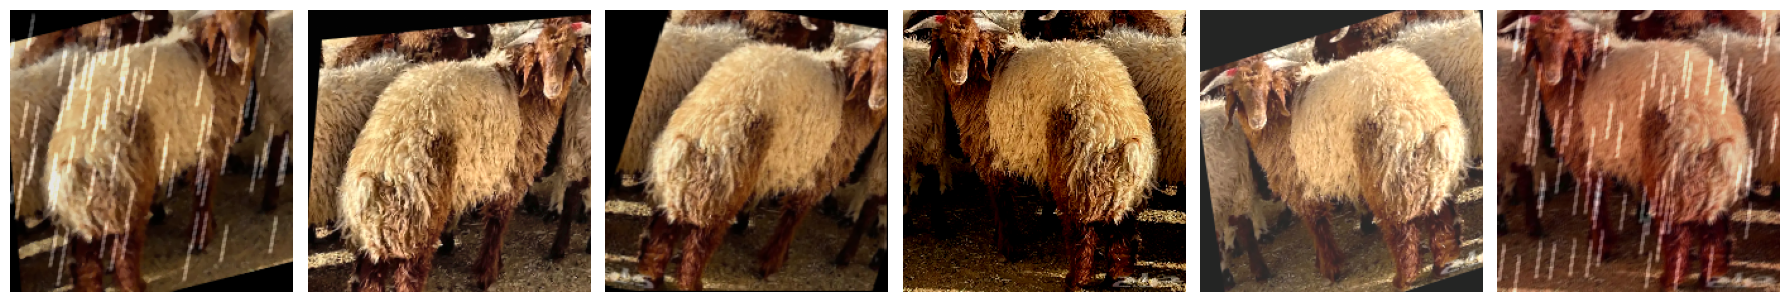

In [11]:
plot_augmented_samples("/kaggle/input/sheep-classification-challenge-2025/Sheep Classification Images/train/0048b660.jpg")

### 3.2.2 Class Weights


To further tackle imbalance, we define a function `compute_class_weights()` that computes a weight for each class based on its frequency in the dataset


This technique ensures:
- Minority classes are assigned higher weights
- Majority classes get lower weights

These weights are passed to the loss function so the model pays more attention to underrepresented classes. This way, incorrect predictions on rare classes are penalized more, helping the model not just favor the "popular" ones.

In [12]:
# ======================
# Data Loading
# ======================

# Load the training data
train_df = pd.read_csv(CONFIG.train_csv)

label2idx, idx2label = get_label_maps()

# Map labels to indices
train_df["label"] = train_df["label"].map(label2idx)
display(train_df)

filename  label
0    39d30b68.jpg      3
1    4a9853bd.jpg      1
2    d88facaa.jpg      5
3    a3f4f4af.jpg      5
4    16b31730.jpg      3
..            ...    ...
677  2c0ea8a4.jpg      3
678  fc48f9e0.jpg      1
679  4baa1e02.jpg      3
680  8c0907bc.jpg      3
681  f47dfc80.jpg      4

[682 rows x 2 columns]

In [13]:
# Compute class weights
class_weights = compute_class_weights(train_df["label"].values, method="effective").to(CONFIG.device)
print(class_weights)

tensor([2.0280, 0.6658, 1.1464, 0.2814, 1.0015, 0.9877, 0.8892],
       device='cuda:0')


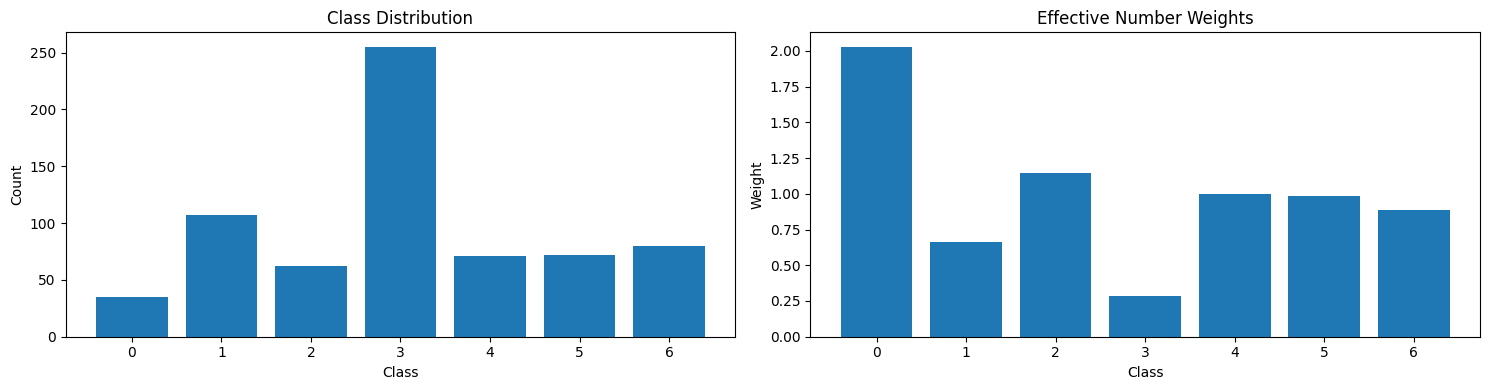

In [14]:
# Plot class distribution and effective weights
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))

# Class distribution
counts = np.bincount(train_df["label"].values)
ax1.bar(range(len(counts)), counts)
ax1.set_title("Class Distribution")
ax1.set_xlabel("Class")
ax1.set_ylabel("Count")

# Class weights
ax2.bar(range(len(class_weights)), class_weights.cpu().numpy())
ax2.set_title("Effective Number Weights")
ax2.set_xlabel("Class")
ax2.set_ylabel("Weight")

plt.tight_layout()
plt.show()

tensor([2.7837, 0.9105, 1.5714, 0.3821, 1.3722, 1.3532, 1.2179],
       device='cuda:0')


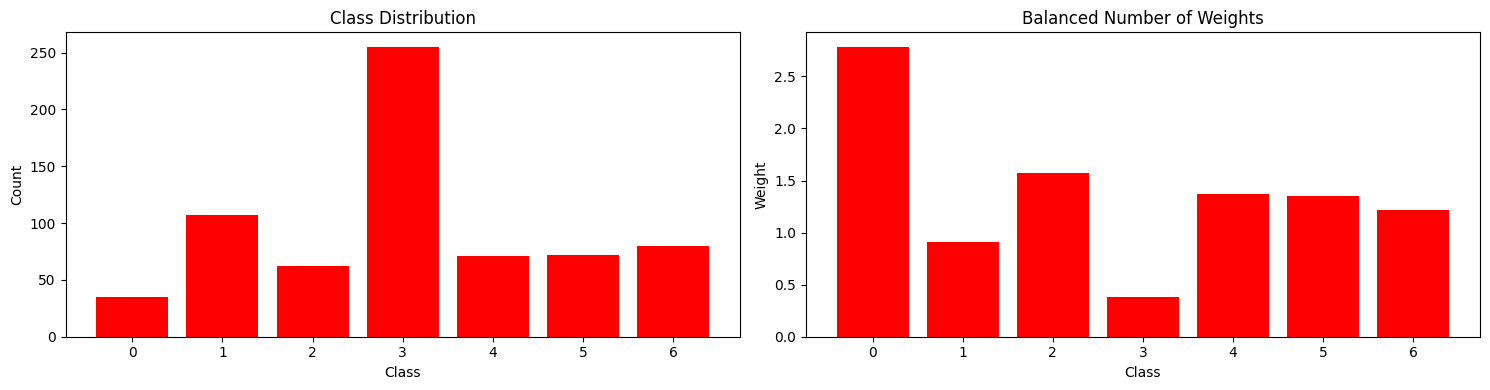

In [15]:
# computing weights using sklearn’s built-in class weight computation based on inverse class frequency
# we are not using this method, but it's good to know about it
_class_weights = compute_class_weights(train_df["label"].values, method="balanced").to(CONFIG.device)
print(_class_weights)

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))

# Class distribution
counts = np.bincount(train_df["label"].values)
ax1.bar(range(len(counts)), counts, color="red")
ax1.set_title("Class Distribution")
ax1.set_xlabel("Class")
ax1.set_ylabel("Count")

# Class weights
ax2.bar(range(len(_class_weights)), _class_weights.cpu().numpy(), color="red")
ax2.set_title("Balanced Number of Weights")
ax2.set_xlabel("Class")
ax2.set_ylabel("Weight")

plt.tight_layout()
plt.show()

# delete the unused variable
del _class_weights

We will use the `effective` method as it uses the **effective number of samples** technique, which better adjusts weights in highly imbalanced datasets by discounting the impact of abundant classes. However as you can see there isn't much of a difference between them

### 3.3 Model Architecture

Our model is built around a powerful Vision Transformer (ViT) backbone. Specifically, we use the `vit_base_patch16_224.augreg_in21k_ft_in1k` variant from the [*An Image is Worth 16x16 Words*](https://arxiv.org/pdf/2010.11929), and creating it using [timm](https://huggingface.co/timm/vit_base_patch16_224.augreg_in21k_ft_in1k)

This version was trained on a large-scale ImageNet-21k dataset and fine-tuned on ImageNet-1k using strong data augmentation and regularization techniques (`augreg` = augmentation + regularization). That gives us a strong starting point.

ViT works by splitting an image into small patches (16×16 in our case), flattening them, and passing them through a standard transformer encoder — just like how transformers process text. This allows the model to capture both local and global context effectively


To adapt it to our classification task:
- We remove the original classification head.
- We add a custom MLP head (Multi-Layer Perceptron) with dropout and batch normalization, which helps the model generalize better and stay stable

In [16]:
model = ViTClassifier(CONFIG.model_name, CONFIG.num_classes).to(CONFIG.device)
summary(model, (3, CONFIG.img_size, CONFIG.img_size))

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 768, 14, 14]         590,592
          Identity-2             [-1, 196, 768]               0
        PatchEmbed-3             [-1, 196, 768]               0
           Dropout-4             [-1, 197, 768]               0
          Identity-5             [-1, 197, 768]               0
          Identity-6             [-1, 197, 768]               0
         LayerNorm-7             [-1, 197, 768]           1,536
            Linear-8            [-1, 197, 2304]       1,771,776
          Identity-9          [-1, 12, 197, 64]               0
         Identity-10          [-1, 12, 197, 64]               0
           Linear-11             [-1, 197, 768]         590,592
          Dropout-12             [-1, 197, 768]               0
        Attention-13             [-1, 197, 768]               0
         Identity-14             [-1, 1

## 3.4 Loss Function

While `CrossEntropyLoss` is the standard go-to for classification tasks, it doesn’t always hold up well when there’s class imbalance, and that’s exactly where Focal Loss comes in to save the day

**Cross-Entropy Loss Recap:**

- For a single binary classification sample, the cross-entropy loss is:
  <center>
    $
    CE(p,y)=−ylog(p)−(1−y)log(1−p)
    $
  </center>

    Where
  
  - $y$ is the true label (0 or 1)
  - $p$ is the predicted probability of class 1

<br>

- For multi-class classification, it generalizes to:
  <center>
    $
    CE(pt​)=−log(pt​)
    $
  </center>

    Where $pt$​ is the predicted probability for the correct class.

    The problem? Standard cross-entropy treats all errors equally. If the model is very confident but wrong about an easy (majority) sample, or slightly wrong about a hard (minority) sample, the loss contributions are not differentiated well enough. Easy samples (majority classes) quickly become well-classified and contribute little to the loss, but they still dominate the total loss because there are so many of them. This means the model doesn't get enough "signal" to learn from the hard (minority) examples.

**Focal Loss:** 

- Focal loss modifies the cross-entropy loss by adding a **modulating factor** $(1−pt​)γ$ to it.
  <center>
    $
    FL(pt​)=−(1−pt​)^γlog(pt​)
    $
  </center>

    Where:

    - $pt$​ is the probability of the true class.

    - $γ (gamma)$ is a focusing parameter ($γ≥0$).

- We can also add an $α$ (alpha) **balancing factor** to give different importance to each class:

  <center>
  $FL(pt​)=−αt​(1−pt​)γlog(pt​)$
  </center>
  <br>
  In our implementation, we pass `class_weights` to `self.alpha`, so it handles both class imbalance and hard example mining at the same time, so our `FocalLoss` also accepts a weights parameter in its forward method, letting us apply extra confidence based weighting when needed (like during pseudo-labeling). This way, we get the best of both worlds, handling class imbalance and adjusting for how confident each prediction is

## 3.5 Optimizers and Schedulers

Optimizers and learning rate schedulers are the engine that drives deep learning training. They decide how to update the model’s weights based on the loss to get better and better predictions


We use [AdamW](https://docs.pytorch.org/docs/stable/generated/torch.optim.AdamW.html) which is a modern upgrade to Adam. It separates weight decay from the gradient steps, helping the model generalize better and avoid overfitting

Since our model has two main parts (the pre-trained Vision Transformer backbone and the fresh classification head), we treat them differently:

- The **backbone** gets a **smaller learning rate** because it already knows a lot and just needs fine-tuning
- The **classifier head** gets a **larger learning rate** because it starts from scratch and needs to learn faster

On top of that, we use a `CosineAnnealingWarmRestarts` scheduler, which periodically restarts the learning rate in a cosine pattern. This helps the model avoid getting stuck in local minima and converge more smoothly

# 4. Initial Cross-Validation Training

PHASE 1: Initial Cross-Validation Training

====================================================================== FOLD 1 ======================================================================
Train distribution: [28, 85, 49, 204, 57, 58, 64], Length: 545
Val distribution: [7, 22, 13, 51, 14, 14, 16], Length: 137


Validating: 100%|██████████| 18/18 [00:01<00:00, 13.70it/s]


Fold 1 | Epoch 1 | Train Loss: 0.7541 | Train Acc: 0.3713 | Val Loss: 0.1510 | Val Acc: 0.8029 | Val F1 Macro: 0.8067 | Val F1 Weighted: 0.8050
New best F1-macro for Fold 1 at epoch 1. Model saved. Current Best F1-macro: 0.8067


Validating: 100%|██████████| 18/18 [00:01<00:00, 14.16it/s]


Fold 1 | Epoch 2 | Train Loss: 0.1854 | Train Acc: 0.7665 | Val Loss: 0.1285 | Val Acc: 0.8832 | Val F1 Macro: 0.8788 | Val F1 Weighted: 0.8838
New best F1-macro for Fold 1 at epoch 2. Model saved. Current Best F1-macro: 0.8788


Validating: 100%|██████████| 18/18 [00:01<00:00, 14.24it/s]


Fold 1 | Epoch 3 | Train Loss: 0.1236 | Train Acc: 0.8327 | Val Loss: 0.1131 | Val Acc: 0.9051 | Val F1 Macro: 0.8990 | Val F1 Weighted: 0.9073
New best F1-macro for Fold 1 at epoch 3. Model saved. Current Best F1-macro: 0.8990


Validating: 100%|██████████| 18/18 [00:01<00:00, 14.17it/s]


Fold 1 | Epoch 4 | Train Loss: 0.1126 | Train Acc: 0.8676 | Val Loss: 0.1025 | Val Acc: 0.8978 | Val F1 Macro: 0.8855 | Val F1 Weighted: 0.8992


Validating: 100%|██████████| 18/18 [00:01<00:00, 14.63it/s]


Fold 1 | Epoch 5 | Train Loss: 0.0753 | Train Acc: 0.9136 | Val Loss: 0.0761 | Val Acc: 0.9635 | Val F1 Macro: 0.9594 | Val F1 Weighted: 0.9641
New best F1-macro for Fold 1 at epoch 5. Model saved. Current Best F1-macro: 0.9594


Validating: 100%|██████████| 18/18 [00:01<00:00, 14.47it/s]


Fold 1 | Epoch 6 | Train Loss: 0.0525 | Train Acc: 0.9228 | Val Loss: 0.0757 | Val Acc: 0.9489 | Val F1 Macro: 0.9495 | Val F1 Weighted: 0.9510


Validating: 100%|██████████| 18/18 [00:01<00:00, 14.19it/s]


Fold 1 | Epoch 7 | Train Loss: 0.0355 | Train Acc: 0.9375 | Val Loss: 0.0575 | Val Acc: 0.9489 | Val F1 Macro: 0.9519 | Val F1 Weighted: 0.9499


Validating: 100%|██████████| 18/18 [00:01<00:00, 14.35it/s]


Fold 1 | Epoch 8 | Train Loss: 0.0322 | Train Acc: 0.9559 | Val Loss: 0.0703 | Val Acc: 0.9343 | Val F1 Macro: 0.9382 | Val F1 Weighted: 0.9353


Validating: 100%|██████████| 18/18 [00:01<00:00, 14.37it/s]


Fold 1 | Epoch 9 | Train Loss: 0.0165 | Train Acc: 0.9596 | Val Loss: 0.0623 | Val Acc: 0.9562 | Val F1 Macro: 0.9545 | Val F1 Weighted: 0.9566


Validating: 100%|██████████| 18/18 [00:01<00:00, 13.68it/s]


Fold 1 | Epoch 10 | Train Loss: 0.0252 | Train Acc: 0.9632 | Val Loss: 0.0489 | Val Acc: 0.9489 | Val F1 Macro: 0.9477 | Val F1 Weighted: 0.9501
Early stopping at epoch 10

----- Classification Report -----
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000         7
           1     1.0000    0.9545    0.9767        22
           2     0.8125    1.0000    0.8966        13
           3     0.9804    0.9804    0.9804        51
           4     1.0000    1.0000    1.0000        14
           5     0.9286    0.9286    0.9286        14
           6     1.0000    0.8750    0.9333        16

    accuracy                         0.9635       137
   macro avg     0.9602    0.9626    0.9594       137
weighted avg     0.9676    0.9635    0.9641       137


----- Confusion Matrix -----
[[ 7  0  0  0  0  0  0]
 [ 0 21  1  0  0  0  0]
 [ 0  0 13  0  0  0  0]
 [ 0  0  0 50  0  1  0]
 [ 0  0  0  0 14  0  0]
 [ 0  0  0  1  0 13  0]
 [ 0  0  2  0  0  0 14

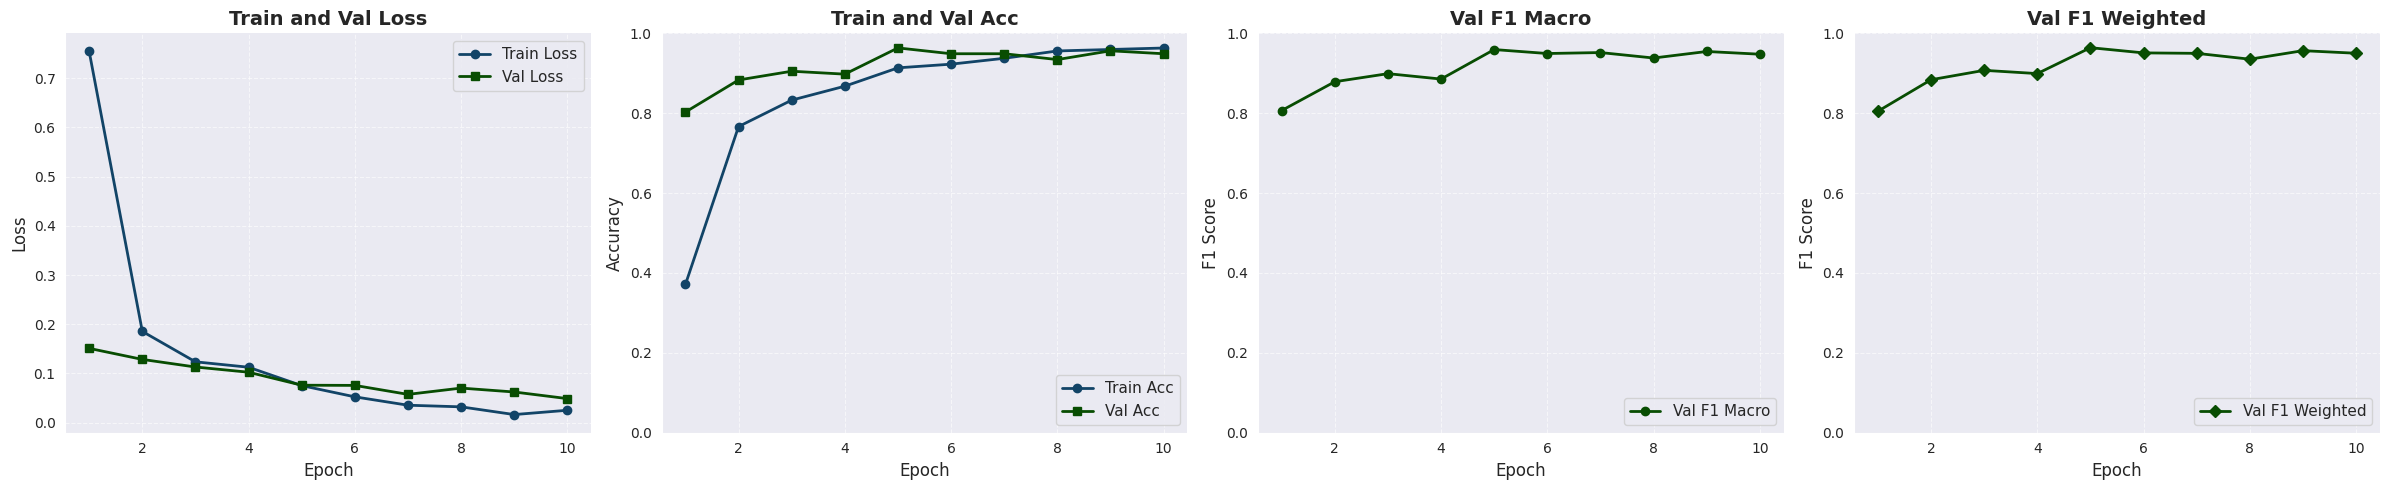


Fold 1 best F1: 0.9594

====================================================================== FOLD 2 ======================================================================
Train distribution: [28, 85, 50, 204, 56, 58, 64], Length: 545
Val distribution: [7, 22, 12, 51, 15, 14, 16], Length: 137


Validating: 100%|██████████| 18/18 [00:01<00:00, 14.01it/s]


Fold 2 | Epoch 1 | Train Loss: 0.7690 | Train Acc: 0.4246 | Val Loss: 0.2834 | Val Acc: 0.7591 | Val F1 Macro: 0.7219 | Val F1 Weighted: 0.7590
New best F1-macro for Fold 2 at epoch 1. Model saved. Current Best F1-macro: 0.7219


Validating: 100%|██████████| 18/18 [00:01<00:00, 13.71it/s]


Fold 2 | Epoch 2 | Train Loss: 0.2308 | Train Acc: 0.7206 | Val Loss: 0.2016 | Val Acc: 0.8321 | Val F1 Macro: 0.8152 | Val F1 Weighted: 0.8365
New best F1-macro for Fold 2 at epoch 2. Model saved. Current Best F1-macro: 0.8152


Validating: 100%|██████████| 18/18 [00:01<00:00, 13.94it/s]


Fold 2 | Epoch 3 | Train Loss: 0.1463 | Train Acc: 0.8125 | Val Loss: 0.1716 | Val Acc: 0.8613 | Val F1 Macro: 0.8317 | Val F1 Weighted: 0.8671
New best F1-macro for Fold 2 at epoch 3. Model saved. Current Best F1-macro: 0.8317


Validating: 100%|██████████| 18/18 [00:01<00:00, 13.74it/s]


Fold 2 | Epoch 4 | Train Loss: 0.1216 | Train Acc: 0.8456 | Val Loss: 0.2008 | Val Acc: 0.8978 | Val F1 Macro: 0.8730 | Val F1 Weighted: 0.9002
New best F1-macro for Fold 2 at epoch 4. Model saved. Current Best F1-macro: 0.8730


Validating: 100%|██████████| 18/18 [00:01<00:00, 13.90it/s]


Fold 2 | Epoch 5 | Train Loss: 0.1004 | Train Acc: 0.8824 | Val Loss: 0.1354 | Val Acc: 0.9051 | Val F1 Macro: 0.8851 | Val F1 Weighted: 0.9053
New best F1-macro for Fold 2 at epoch 5. Model saved. Current Best F1-macro: 0.8851


Validating: 100%|██████████| 18/18 [00:01<00:00, 13.88it/s]


Fold 2 | Epoch 6 | Train Loss: 0.0503 | Train Acc: 0.9375 | Val Loss: 0.1223 | Val Acc: 0.9270 | Val F1 Macro: 0.9024 | Val F1 Weighted: 0.9276
New best F1-macro for Fold 2 at epoch 6. Model saved. Current Best F1-macro: 0.9024


Validating: 100%|██████████| 18/18 [00:01<00:00, 13.69it/s]


Fold 2 | Epoch 7 | Train Loss: 0.0370 | Train Acc: 0.9357 | Val Loss: 0.1334 | Val Acc: 0.9270 | Val F1 Macro: 0.9056 | Val F1 Weighted: 0.9271
New best F1-macro for Fold 2 at epoch 7. Model saved. Current Best F1-macro: 0.9056


Validating: 100%|██████████| 18/18 [00:01<00:00, 14.07it/s]


Fold 2 | Epoch 8 | Train Loss: 0.0193 | Train Acc: 0.9632 | Val Loss: 0.1257 | Val Acc: 0.9270 | Val F1 Macro: 0.9024 | Val F1 Weighted: 0.9276


Validating: 100%|██████████| 18/18 [00:01<00:00, 14.14it/s]


Fold 2 | Epoch 9 | Train Loss: 0.0101 | Train Acc: 0.9596 | Val Loss: 0.1041 | Val Acc: 0.9416 | Val F1 Macro: 0.9130 | Val F1 Weighted: 0.9418
New best F1-macro for Fold 2 at epoch 9. Model saved. Current Best F1-macro: 0.9130


Validating: 100%|██████████| 18/18 [00:01<00:00, 14.11it/s]


Fold 2 | Epoch 10 | Train Loss: 0.0399 | Train Acc: 0.9412 | Val Loss: 0.1477 | Val Acc: 0.9489 | Val F1 Macro: 0.9266 | Val F1 Weighted: 0.9496
New best F1-macro for Fold 2 at epoch 10. Model saved. Current Best F1-macro: 0.9266


Validating: 100%|██████████| 18/18 [00:01<00:00, 14.18it/s]


Fold 2 | Epoch 11 | Train Loss: 0.0247 | Train Acc: 0.9706 | Val Loss: 0.1332 | Val Acc: 0.9124 | Val F1 Macro: 0.8967 | Val F1 Weighted: 0.9139


Validating: 100%|██████████| 18/18 [00:01<00:00, 14.04it/s]


Fold 2 | Epoch 12 | Train Loss: 0.0140 | Train Acc: 0.9651 | Val Loss: 0.1534 | Val Acc: 0.9635 | Val F1 Macro: 0.9399 | Val F1 Weighted: 0.9629
New best F1-macro for Fold 2 at epoch 12. Model saved. Current Best F1-macro: 0.9399


Validating: 100%|██████████| 18/18 [00:01<00:00, 14.02it/s]


Fold 2 | Epoch 13 | Train Loss: 0.0249 | Train Acc: 0.9761 | Val Loss: 0.1003 | Val Acc: 0.9635 | Val F1 Macro: 0.9498 | Val F1 Weighted: 0.9634
New best F1-macro for Fold 2 at epoch 13. Model saved. Current Best F1-macro: 0.9498


Validating: 100%|██████████| 18/18 [00:01<00:00, 13.91it/s]


Fold 2 | Epoch 14 | Train Loss: 0.0252 | Train Acc: 0.9632 | Val Loss: 0.1268 | Val Acc: 0.9562 | Val F1 Macro: 0.9350 | Val F1 Weighted: 0.9557


Validating: 100%|██████████| 18/18 [00:01<00:00, 13.22it/s]


Fold 2 | Epoch 15 | Train Loss: 0.0175 | Train Acc: 0.9816 | Val Loss: 0.1305 | Val Acc: 0.9562 | Val F1 Macro: 0.9342 | Val F1 Weighted: 0.9563


Validating: 100%|██████████| 18/18 [00:01<00:00, 13.69it/s]


Fold 2 | Epoch 16 | Train Loss: 0.0020 | Train Acc: 0.9982 | Val Loss: 0.1547 | Val Acc: 0.9562 | Val F1 Macro: 0.9342 | Val F1 Weighted: 0.9563


Validating: 100%|██████████| 18/18 [00:01<00:00, 13.90it/s]


Fold 2 | Epoch 17 | Train Loss: 0.0015 | Train Acc: 0.9890 | Val Loss: 0.1409 | Val Acc: 0.9489 | Val F1 Macro: 0.9279 | Val F1 Weighted: 0.9491


Validating: 100%|██████████| 18/18 [00:01<00:00, 14.21it/s]


Fold 2 | Epoch 18 | Train Loss: 0.0096 | Train Acc: 0.9779 | Val Loss: 0.1251 | Val Acc: 0.9562 | Val F1 Macro: 0.9357 | Val F1 Weighted: 0.9562
Early stopping at epoch 18

----- Classification Report -----
              precision    recall  f1-score   support

           0     0.8750    1.0000    0.9333         7
           1     1.0000    0.9091    0.9524        22
           2     0.8462    0.9167    0.8800        12
           3     0.9808    1.0000    0.9903        51
           4     1.0000    1.0000    1.0000        15
           5     1.0000    0.8571    0.9231        14
           6     0.9412    1.0000    0.9697        16

    accuracy                         0.9635       137
   macro avg     0.9490    0.9547    0.9498       137
weighted avg     0.9661    0.9635    0.9634       137


----- Confusion Matrix -----
[[ 7  0  0  0  0  0  0]
 [ 1 20  1  0  0  0  0]
 [ 0  0 11  0  0  0  1]
 [ 0  0  0 51  0  0  0]
 [ 0  0  0  0 15  0  0]
 [ 0  0  1  1  0 12  0]
 [ 0  0  0  0  0  0 16

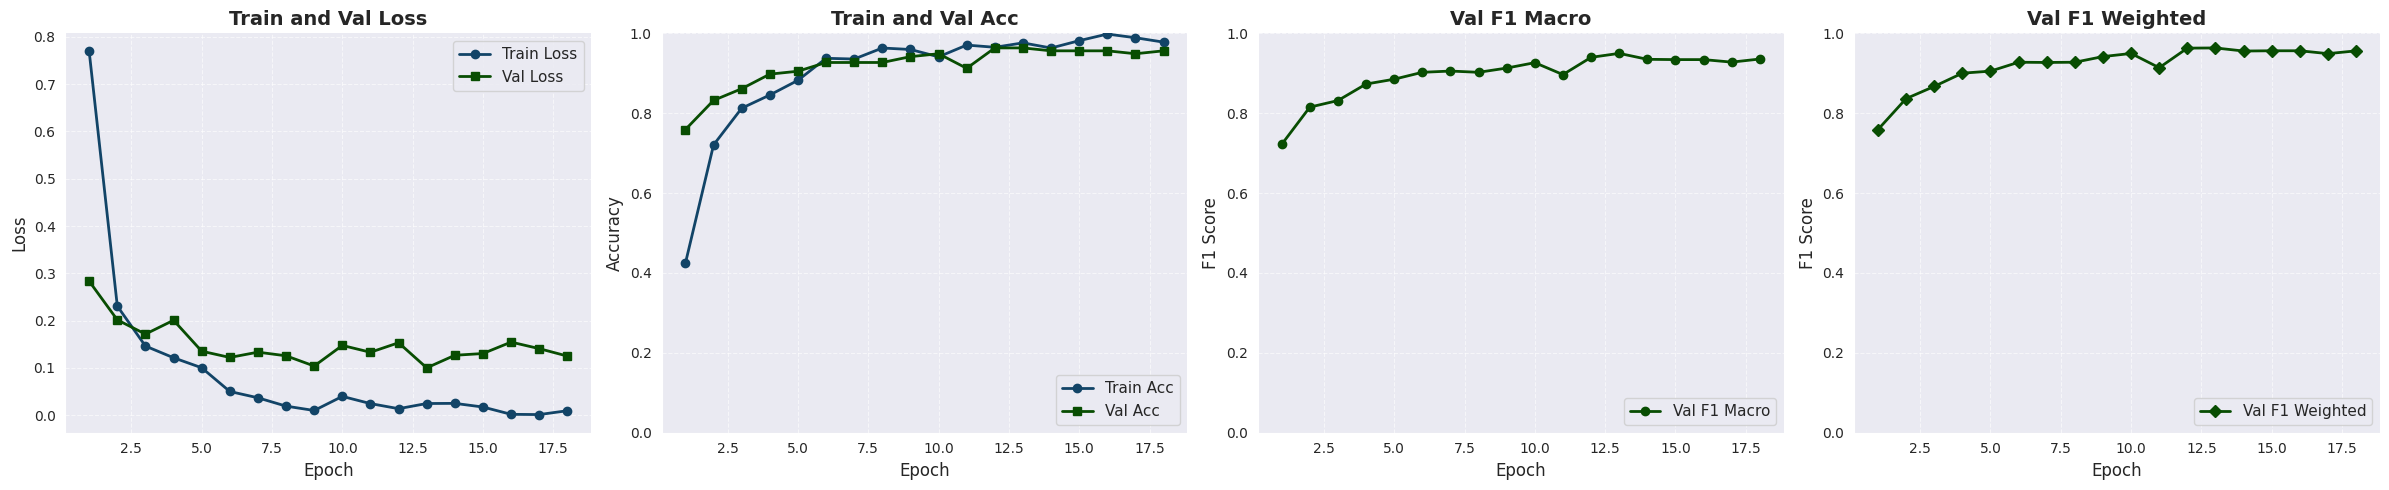


Fold 2 best F1: 0.9498

====================================================================== FOLD 3 ======================================================================
Train distribution: [28, 86, 50, 204, 57, 57, 64], Length: 546
Val distribution: [7, 21, 12, 51, 14, 15, 16], Length: 136


Validating: 100%|██████████| 17/17 [00:01<00:00, 11.98it/s]


Fold 3 | Epoch 1 | Train Loss: 0.7778 | Train Acc: 0.3750 | Val Loss: 0.1724 | Val Acc: 0.7132 | Val F1 Macro: 0.7303 | Val F1 Weighted: 0.7233
New best F1-macro for Fold 3 at epoch 1. Model saved. Current Best F1-macro: 0.7303


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.02it/s]


Fold 3 | Epoch 2 | Train Loss: 0.2907 | Train Acc: 0.6765 | Val Loss: 0.1364 | Val Acc: 0.8824 | Val F1 Macro: 0.8620 | Val F1 Weighted: 0.8849
New best F1-macro for Fold 3 at epoch 2. Model saved. Current Best F1-macro: 0.8620


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.15it/s]


Fold 3 | Epoch 3 | Train Loss: 0.1577 | Train Acc: 0.7537 | Val Loss: 0.1305 | Val Acc: 0.8529 | Val F1 Macro: 0.8315 | Val F1 Weighted: 0.8560


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.22it/s]


Fold 3 | Epoch 4 | Train Loss: 0.1512 | Train Acc: 0.8162 | Val Loss: 0.1155 | Val Acc: 0.9118 | Val F1 Macro: 0.8959 | Val F1 Weighted: 0.9109
New best F1-macro for Fold 3 at epoch 4. Model saved. Current Best F1-macro: 0.8959


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.01it/s]


Fold 3 | Epoch 5 | Train Loss: 0.0652 | Train Acc: 0.8971 | Val Loss: 0.1203 | Val Acc: 0.9191 | Val F1 Macro: 0.9004 | Val F1 Weighted: 0.9178
New best F1-macro for Fold 3 at epoch 5. Model saved. Current Best F1-macro: 0.9004


Validating: 100%|██████████| 17/17 [00:02<00:00,  6.76it/s]


Fold 3 | Epoch 6 | Train Loss: 0.0534 | Train Acc: 0.9283 | Val Loss: 0.1522 | Val Acc: 0.9412 | Val F1 Macro: 0.9291 | Val F1 Weighted: 0.9384
New best F1-macro for Fold 3 at epoch 6. Model saved. Current Best F1-macro: 0.9291


Validating: 100%|██████████| 17/17 [00:02<00:00,  6.29it/s]


Fold 3 | Epoch 7 | Train Loss: 0.0544 | Train Acc: 0.9228 | Val Loss: 0.1392 | Val Acc: 0.9265 | Val F1 Macro: 0.9062 | Val F1 Weighted: 0.9241


Validating: 100%|██████████| 17/17 [00:02<00:00,  6.69it/s]


Fold 3 | Epoch 8 | Train Loss: 0.0292 | Train Acc: 0.9301 | Val Loss: 0.1335 | Val Acc: 0.9338 | Val F1 Macro: 0.9173 | Val F1 Weighted: 0.9316


Validating: 100%|██████████| 17/17 [00:02<00:00,  5.85it/s]


Fold 3 | Epoch 9 | Train Loss: 0.0265 | Train Acc: 0.9706 | Val Loss: 0.1267 | Val Acc: 0.9412 | Val F1 Macro: 0.9301 | Val F1 Weighted: 0.9393
New best F1-macro for Fold 3 at epoch 9. Model saved. Current Best F1-macro: 0.9301


Validating: 100%|██████████| 17/17 [00:02<00:00,  6.88it/s]


Fold 3 | Epoch 10 | Train Loss: 0.0256 | Train Acc: 0.9669 | Val Loss: 0.1635 | Val Acc: 0.9338 | Val F1 Macro: 0.9139 | Val F1 Weighted: 0.9313


Validating: 100%|██████████| 17/17 [00:02<00:00,  6.77it/s]


Fold 3 | Epoch 11 | Train Loss: 0.0209 | Train Acc: 0.9706 | Val Loss: 0.2228 | Val Acc: 0.9338 | Val F1 Macro: 0.9167 | Val F1 Weighted: 0.9296


Validating: 100%|██████████| 17/17 [00:01<00:00, 11.96it/s]


Fold 3 | Epoch 12 | Train Loss: 0.0357 | Train Acc: 0.9504 | Val Loss: 0.2205 | Val Acc: 0.9265 | Val F1 Macro: 0.9049 | Val F1 Weighted: 0.9229


Validating: 100%|██████████| 17/17 [00:01<00:00, 11.51it/s]


Fold 3 | Epoch 13 | Train Loss: 0.0096 | Train Acc: 0.9743 | Val Loss: 0.1991 | Val Acc: 0.9412 | Val F1 Macro: 0.9301 | Val F1 Weighted: 0.9393


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.08it/s]


Fold 3 | Epoch 14 | Train Loss: 0.0269 | Train Acc: 0.9761 | Val Loss: 0.1608 | Val Acc: 0.9485 | Val F1 Macro: 0.9414 | Val F1 Weighted: 0.9470
New best F1-macro for Fold 3 at epoch 14. Model saved. Current Best F1-macro: 0.9414


Validating: 100%|██████████| 17/17 [00:01<00:00, 11.82it/s]


Fold 3 | Epoch 15 | Train Loss: 0.0222 | Train Acc: 0.9761 | Val Loss: 0.1479 | Val Acc: 0.9485 | Val F1 Macro: 0.9414 | Val F1 Weighted: 0.9470


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.27it/s]


Fold 3 | Epoch 16 | Train Loss: 0.0211 | Train Acc: 0.9853 | Val Loss: 0.1679 | Val Acc: 0.9412 | Val F1 Macro: 0.9301 | Val F1 Weighted: 0.9393


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.06it/s]


Fold 3 | Epoch 17 | Train Loss: 0.0113 | Train Acc: 0.9853 | Val Loss: 0.1652 | Val Acc: 0.9559 | Val F1 Macro: 0.9460 | Val F1 Weighted: 0.9541
New best F1-macro for Fold 3 at epoch 17. Model saved. Current Best F1-macro: 0.9460


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.11it/s]


Fold 3 | Epoch 18 | Train Loss: 0.0066 | Train Acc: 0.9871 | Val Loss: 0.1613 | Val Acc: 0.9559 | Val F1 Macro: 0.9460 | Val F1 Weighted: 0.9541


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.03it/s]


Fold 3 | Epoch 19 | Train Loss: 0.0048 | Train Acc: 0.9945 | Val Loss: 0.1621 | Val Acc: 0.9485 | Val F1 Macro: 0.9375 | Val F1 Weighted: 0.9475


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.14it/s]


Fold 3 | Epoch 20 | Train Loss: 0.0006 | Train Acc: 0.9963 | Val Loss: 0.1752 | Val Acc: 0.9412 | Val F1 Macro: 0.9301 | Val F1 Weighted: 0.9393


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.13it/s]


Fold 3 | Epoch 21 | Train Loss: 0.0032 | Train Acc: 0.9908 | Val Loss: 0.1811 | Val Acc: 0.9412 | Val F1 Macro: 0.9301 | Val F1 Weighted: 0.9393


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.22it/s]


Fold 3 | Epoch 22 | Train Loss: 0.0258 | Train Acc: 0.9853 | Val Loss: 0.1915 | Val Acc: 0.9412 | Val F1 Macro: 0.9301 | Val F1 Weighted: 0.9393
Early stopping at epoch 22

----- Classification Report -----
              precision    recall  f1-score   support

           0     0.8750    1.0000    0.9333         7
           1     0.9545    1.0000    0.9767        21
           2     1.0000    0.9167    0.9565        12
           3     0.9444    1.0000    0.9714        51
           4     1.0000    1.0000    1.0000        14
           5     1.0000    0.7333    0.8462        15
           6     0.9375    0.9375    0.9375        16

    accuracy                         0.9559       136
   macro avg     0.9588    0.9411    0.9460       136
weighted avg     0.9584    0.9559    0.9541       136


----- Confusion Matrix -----
[[ 7  0  0  0  0  0  0]
 [ 0 21  0  0  0  0  0]
 [ 1  0 11  0  0  0  0]
 [ 0  0  0 51  0  0  0]
 [ 0  0  0  0 14  0  0]
 [ 0  0  0  3  0 11  1]
 [ 0  1  0  0  0  0 15

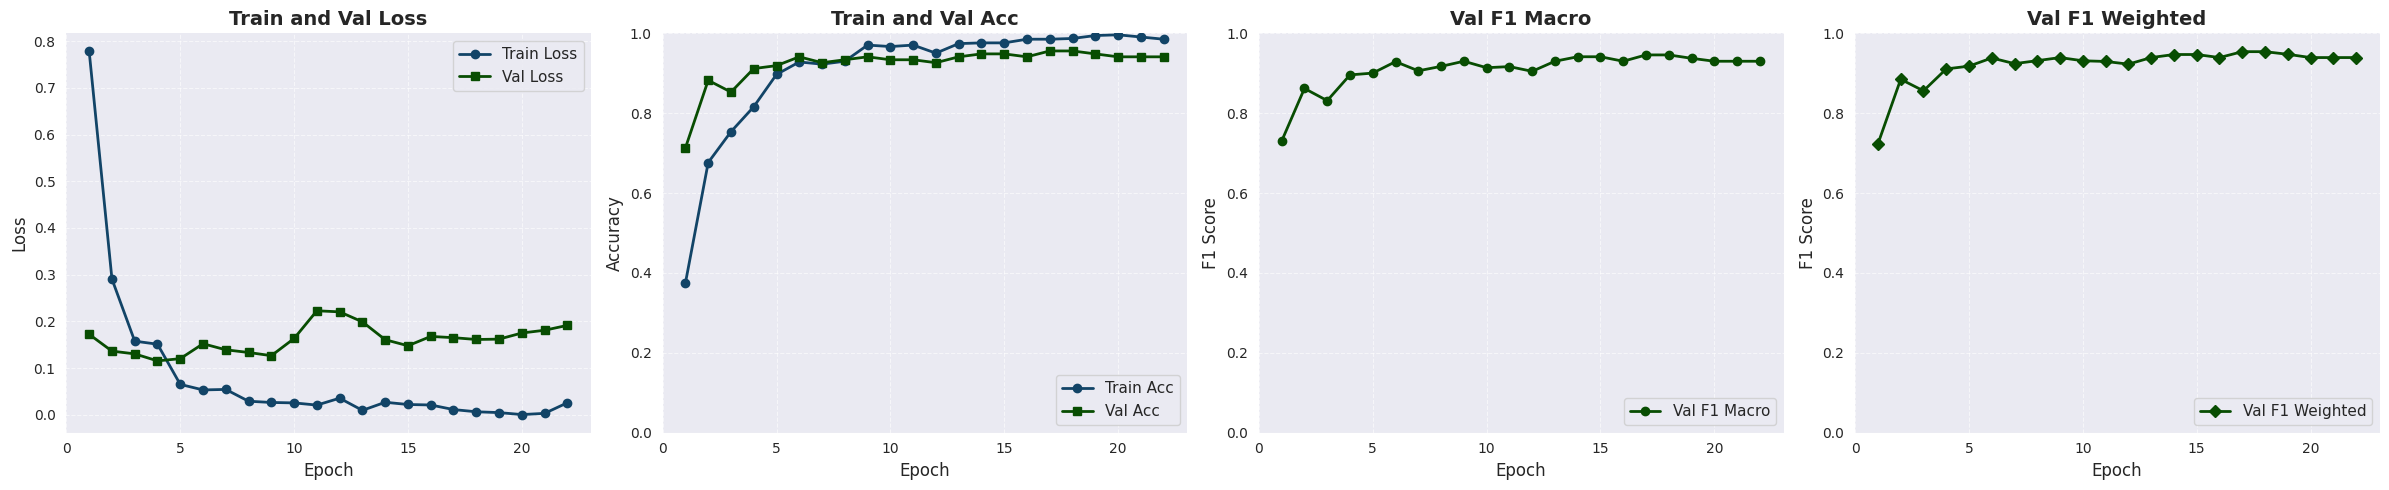


Fold 3 best F1: 0.9460

====================================================================== FOLD 4 ======================================================================
Train distribution: [28, 86, 50, 204, 57, 57, 64], Length: 546
Val distribution: [7, 21, 12, 51, 14, 15, 16], Length: 136


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.48it/s]


Fold 4 | Epoch 1 | Train Loss: 0.6446 | Train Acc: 0.4118 | Val Loss: 0.1586 | Val Acc: 0.8088 | Val F1 Macro: 0.7830 | Val F1 Weighted: 0.8151
New best F1-macro for Fold 4 at epoch 1. Model saved. Current Best F1-macro: 0.7830


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.50it/s]


Fold 4 | Epoch 2 | Train Loss: 0.1973 | Train Acc: 0.7353 | Val Loss: 0.0602 | Val Acc: 0.8897 | Val F1 Macro: 0.8772 | Val F1 Weighted: 0.8939
New best F1-macro for Fold 4 at epoch 2. Model saved. Current Best F1-macro: 0.8772


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.53it/s]


Fold 4 | Epoch 3 | Train Loss: 0.1560 | Train Acc: 0.7721 | Val Loss: 0.0449 | Val Acc: 0.9044 | Val F1 Macro: 0.9103 | Val F1 Weighted: 0.9056
New best F1-macro for Fold 4 at epoch 3. Model saved. Current Best F1-macro: 0.9103


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.59it/s]


Fold 4 | Epoch 4 | Train Loss: 0.1290 | Train Acc: 0.8787 | Val Loss: 0.0375 | Val Acc: 0.9485 | Val F1 Macro: 0.9508 | Val F1 Weighted: 0.9485
New best F1-macro for Fold 4 at epoch 4. Model saved. Current Best F1-macro: 0.9508


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.56it/s]


Fold 4 | Epoch 5 | Train Loss: 0.0664 | Train Acc: 0.9007 | Val Loss: 0.0353 | Val Acc: 0.9559 | Val F1 Macro: 0.9581 | Val F1 Weighted: 0.9572
New best F1-macro for Fold 4 at epoch 5. Model saved. Current Best F1-macro: 0.9581


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.54it/s]


Fold 4 | Epoch 6 | Train Loss: 0.0423 | Train Acc: 0.9301 | Val Loss: 0.0381 | Val Acc: 0.9853 | Val F1 Macro: 0.9866 | Val F1 Weighted: 0.9853
New best F1-macro for Fold 4 at epoch 6. Model saved. Current Best F1-macro: 0.9866


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.47it/s]


Fold 4 | Epoch 7 | Train Loss: 0.0388 | Train Acc: 0.9504 | Val Loss: 0.0248 | Val Acc: 0.9779 | Val F1 Macro: 0.9805 | Val F1 Weighted: 0.9780


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.47it/s]


Fold 4 | Epoch 8 | Train Loss: 0.0472 | Train Acc: 0.9632 | Val Loss: 0.0277 | Val Acc: 0.9779 | Val F1 Macro: 0.9805 | Val F1 Weighted: 0.9780


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.37it/s]


Fold 4 | Epoch 9 | Train Loss: 0.0220 | Train Acc: 0.9651 | Val Loss: 0.0293 | Val Acc: 0.9853 | Val F1 Macro: 0.9877 | Val F1 Weighted: 0.9853
New best F1-macro for Fold 4 at epoch 9. Model saved. Current Best F1-macro: 0.9877


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.54it/s]


Fold 4 | Epoch 10 | Train Loss: 0.0414 | Train Acc: 0.9596 | Val Loss: 0.0266 | Val Acc: 0.9706 | Val F1 Macro: 0.9735 | Val F1 Weighted: 0.9709


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.38it/s]


Fold 4 | Epoch 11 | Train Loss: 0.0347 | Train Acc: 0.9522 | Val Loss: 0.0337 | Val Acc: 0.9853 | Val F1 Macro: 0.9866 | Val F1 Weighted: 0.9853


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.55it/s]


Fold 4 | Epoch 12 | Train Loss: 0.0111 | Train Acc: 0.9779 | Val Loss: 0.0359 | Val Acc: 0.9779 | Val F1 Macro: 0.9736 | Val F1 Weighted: 0.9781


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.51it/s]


Fold 4 | Epoch 13 | Train Loss: 0.0313 | Train Acc: 0.9798 | Val Loss: 0.0407 | Val Acc: 0.9632 | Val F1 Macro: 0.9555 | Val F1 Weighted: 0.9638


Validating: 100%|██████████| 17/17 [00:01<00:00, 11.33it/s]


Fold 4 | Epoch 14 | Train Loss: 0.0108 | Train Acc: 0.9779 | Val Loss: 0.0457 | Val Acc: 0.9926 | Val F1 Macro: 0.9937 | Val F1 Weighted: 0.9926
New best F1-macro for Fold 4 at epoch 14. Model saved. Current Best F1-macro: 0.9937


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.62it/s]


Fold 4 | Epoch 15 | Train Loss: 0.0147 | Train Acc: 0.9853 | Val Loss: 0.0384 | Val Acc: 0.9926 | Val F1 Macro: 0.9937 | Val F1 Weighted: 0.9926


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.32it/s]


Fold 4 | Epoch 16 | Train Loss: 0.0188 | Train Acc: 0.9816 | Val Loss: 0.0490 | Val Acc: 0.9779 | Val F1 Macro: 0.9675 | Val F1 Weighted: 0.9771


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.62it/s]


Fold 4 | Epoch 17 | Train Loss: 0.0160 | Train Acc: 0.9853 | Val Loss: 0.0436 | Val Acc: 0.9853 | Val F1 Macro: 0.9845 | Val F1 Weighted: 0.9853


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.61it/s]


Fold 4 | Epoch 18 | Train Loss: 0.0010 | Train Acc: 0.9963 | Val Loss: 0.0442 | Val Acc: 0.9853 | Val F1 Macro: 0.9845 | Val F1 Weighted: 0.9853


Validating: 100%|██████████| 17/17 [00:01<00:00, 11.79it/s]


Fold 4 | Epoch 19 | Train Loss: 0.0105 | Train Acc: 0.9890 | Val Loss: 0.0409 | Val Acc: 0.9926 | Val F1 Macro: 0.9937 | Val F1 Weighted: 0.9926
Early stopping at epoch 19

----- Classification Report -----
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000         7
           1     1.0000    1.0000    1.0000        21
           2     1.0000    1.0000    1.0000        12
           3     0.9808    1.0000    0.9903        51
           4     1.0000    1.0000    1.0000        14
           5     1.0000    0.9333    0.9655        15
           6     1.0000    1.0000    1.0000        16

    accuracy                         0.9926       136
   macro avg     0.9973    0.9905    0.9937       136
weighted avg     0.9928    0.9926    0.9926       136


----- Confusion Matrix -----
[[ 7  0  0  0  0  0  0]
 [ 0 21  0  0  0  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 51  0  0  0]
 [ 0  0  0  0 14  0  0]
 [ 0  0  0  1  0 14  0]
 [ 0  0  0  0  0  0 16

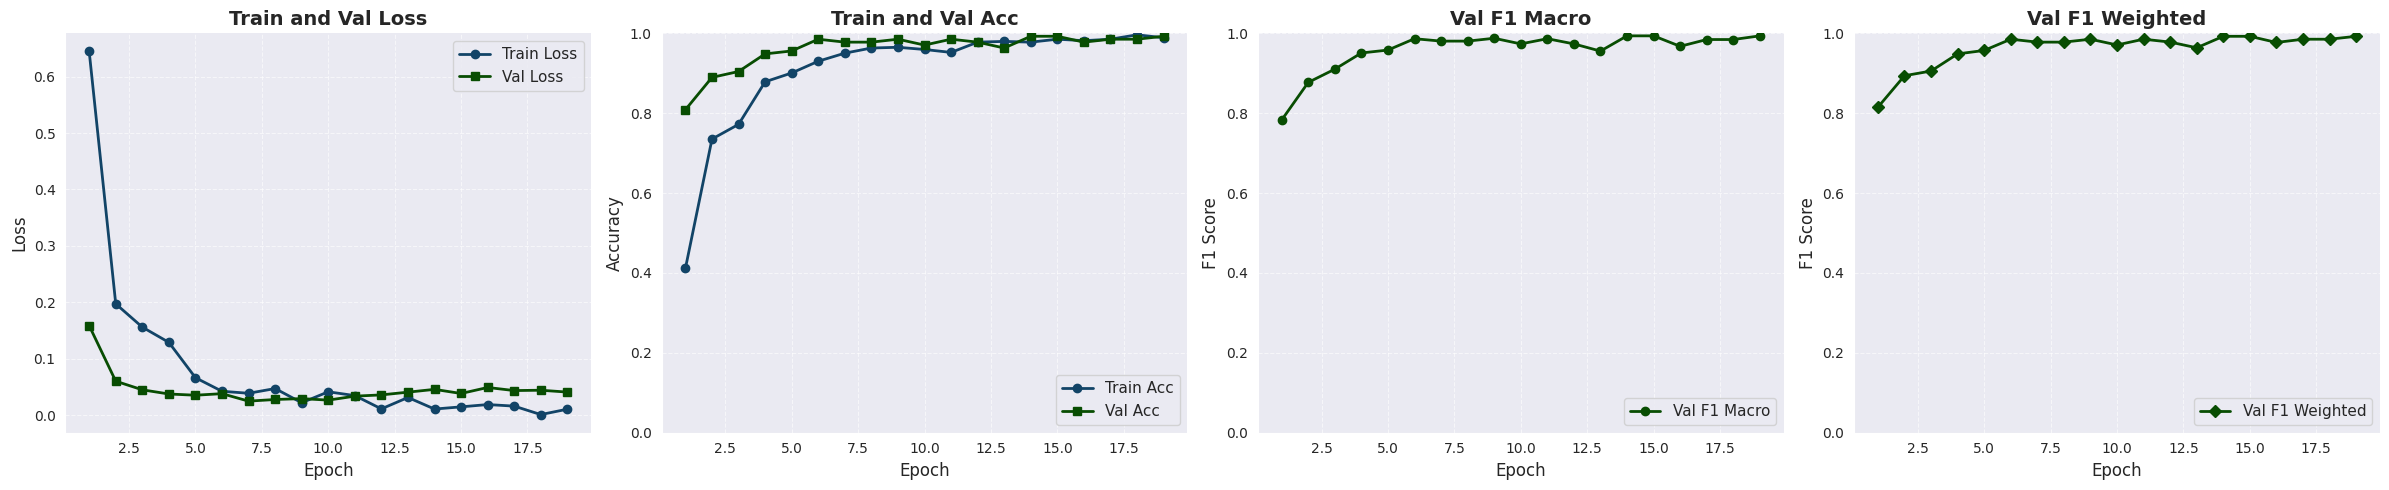


Fold 4 best F1: 0.9937

====================================================================== FOLD 5 ======================================================================
Train distribution: [28, 86, 49, 204, 57, 58, 64], Length: 546
Val distribution: [7, 21, 13, 51, 14, 14, 16], Length: 136


Validating: 100%|██████████| 17/17 [00:01<00:00, 11.38it/s]


Fold 5 | Epoch 1 | Train Loss: 0.7466 | Train Acc: 0.4081 | Val Loss: 0.1269 | Val Acc: 0.7426 | Val F1 Macro: 0.7844 | Val F1 Weighted: 0.7566
New best F1-macro for Fold 5 at epoch 1. Model saved. Current Best F1-macro: 0.7844


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.96it/s]


Fold 5 | Epoch 2 | Train Loss: 0.2368 | Train Acc: 0.7114 | Val Loss: 0.0669 | Val Acc: 0.9044 | Val F1 Macro: 0.8909 | Val F1 Weighted: 0.9083
New best F1-macro for Fold 5 at epoch 2. Model saved. Current Best F1-macro: 0.8909


Validating: 100%|██████████| 17/17 [00:01<00:00, 11.90it/s]


Fold 5 | Epoch 3 | Train Loss: 0.1383 | Train Acc: 0.8235 | Val Loss: 0.0573 | Val Acc: 0.9412 | Val F1 Macro: 0.9265 | Val F1 Weighted: 0.9426
New best F1-macro for Fold 5 at epoch 3. Model saved. Current Best F1-macro: 0.9265


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.81it/s]


Fold 5 | Epoch 4 | Train Loss: 0.1299 | Train Acc: 0.8438 | Val Loss: 0.0078 | Val Acc: 0.9853 | Val F1 Macro: 0.9812 | Val F1 Weighted: 0.9855
New best F1-macro for Fold 5 at epoch 4. Model saved. Current Best F1-macro: 0.9812


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.41it/s]


Fold 5 | Epoch 5 | Train Loss: 0.1433 | Train Acc: 0.8750 | Val Loss: 0.0207 | Val Acc: 0.9265 | Val F1 Macro: 0.9201 | Val F1 Weighted: 0.9293


Validating: 100%|██████████| 17/17 [00:01<00:00, 13.06it/s]


Fold 5 | Epoch 6 | Train Loss: 0.0492 | Train Acc: 0.9301 | Val Loss: 0.0053 | Val Acc: 1.0000 | Val F1 Macro: 1.0000 | Val F1 Weighted: 1.0000
New best F1-macro for Fold 5 at epoch 6. Model saved. Current Best F1-macro: 1.0000


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.27it/s]


Fold 5 | Epoch 7 | Train Loss: 0.0467 | Train Acc: 0.9301 | Val Loss: 0.0063 | Val Acc: 0.9853 | Val F1 Macro: 0.9827 | Val F1 Weighted: 0.9855


Validating: 100%|██████████| 17/17 [00:01<00:00, 13.04it/s]


Fold 5 | Epoch 8 | Train Loss: 0.0515 | Train Acc: 0.9449 | Val Loss: 0.0233 | Val Acc: 0.9926 | Val F1 Macro: 0.9857 | Val F1 Weighted: 0.9924


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.46it/s]


Fold 5 | Epoch 9 | Train Loss: 0.0142 | Train Acc: 0.9724 | Val Loss: 0.0164 | Val Acc: 1.0000 | Val F1 Macro: 1.0000 | Val F1 Weighted: 1.0000


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.41it/s]


Fold 5 | Epoch 10 | Train Loss: 0.0259 | Train Acc: 0.9651 | Val Loss: 0.0144 | Val Acc: 0.9706 | Val F1 Macro: 0.9689 | Val F1 Weighted: 0.9708


Validating: 100%|██████████| 17/17 [00:01<00:00, 12.69it/s]


Fold 5 | Epoch 11 | Train Loss: 0.0411 | Train Acc: 0.9485 | Val Loss: 0.0235 | Val Acc: 0.9779 | Val F1 Macro: 0.9745 | Val F1 Weighted: 0.9776
Early stopping at epoch 11

----- Classification Report -----
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000         7
           1     1.0000    1.0000    1.0000        21
           2     1.0000    1.0000    1.0000        13
           3     1.0000    1.0000    1.0000        51
           4     1.0000    1.0000    1.0000        14
           5     1.0000    1.0000    1.0000        14
           6     1.0000    1.0000    1.0000        16

    accuracy                         1.0000       136
   macro avg     1.0000    1.0000    1.0000       136
weighted avg     1.0000    1.0000    1.0000       136


----- Confusion Matrix -----
[[ 7  0  0  0  0  0  0]
 [ 0 21  0  0  0  0  0]
 [ 0  0 13  0  0  0  0]
 [ 0  0  0 51  0  0  0]
 [ 0  0  0  0 14  0  0]
 [ 0  0  0  0  0 14  0]
 [ 0  0  0  0  0  0 16

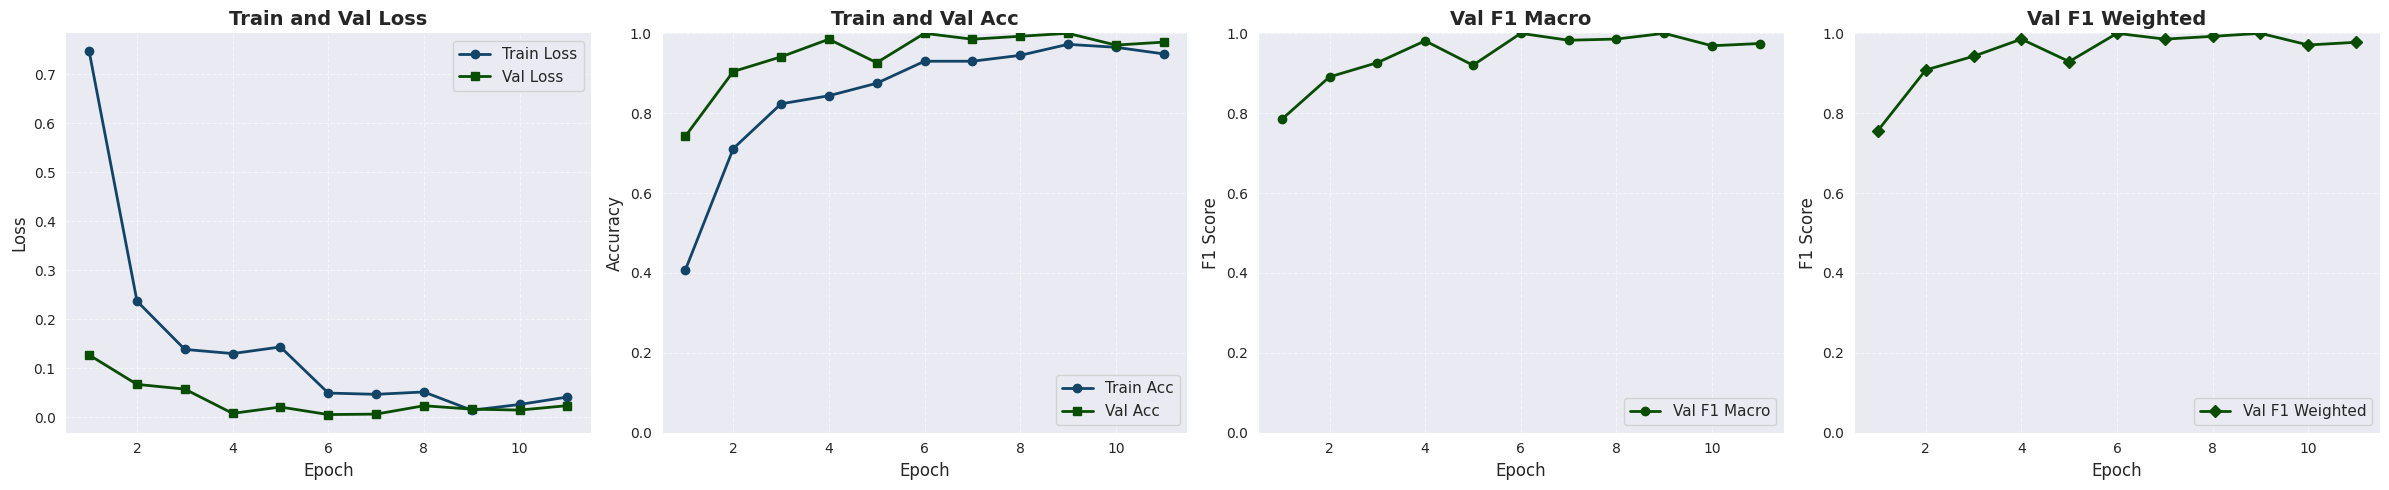


Fold 5 best F1: 1.0000

Cross-validation results:
Mean F1: 0.9698 ± 0.0226
Individual fold scores: [0.9593704041359928, 0.9498256343748716, 0.9459545251560996, 0.9936869290736048, 1.0]


In [17]:
# ======================
# Cross-validation training
# ======================

print("=" * 60)
print("PHASE 1: Initial Cross-Validation Training")
print("=" * 60)

fold_scores = train_cross_validation(
    train_df, pseudo_train=False, results_dir=INITIAL_RESULTS_DIR
)

## 4.1 Initial Predictions on Test Set

In [18]:
# Load the 5 models we just trained
model_files = [f for f in os.listdir(CONFIG.models_dir) if f.endswith(".pth")]
sorted_model_files = sorted([f for f in model_files if f.startswith("cv_fold_")])

models = load_models(sorted_model_files)

# Load the test set
test_loader = load_test_data()

Loading models: 100%|██████████| 5/5 [00:09<00:00,  1.98s/it]


Loaded 5 models
Test set size: 144, batch size: 8


In [19]:
# ======================
# Predict on test set
# ======================

fold_scores = np.load(os.path.join(CONFIG.models_dir, "cv_fold_scores.npy"))
all_preds, all_confidences, all_filenames, all_probs = ensemble_predict(models, test_loader, fold_scores=fold_scores)

# We can also treat all models equally, without using cross-validation scores
# all_preds, all_confidences, all_filenames, all_probs = ensemble_predict(models, test_loader)

# Convert labels back to original labels
all_labels = [idx2label[pred] for pred in all_preds]

Predicting: 100%|██████████| 18/18 [00:05<00:00,  3.56it/s]


Total predictions: 144
Average confidence: 0.8977
Min confidence: 0.2941
Max confidence: 0.9996

Model 1 | Weight: 0.198 | Fold score: 0.9594 | Type: Initial
Model 2 | Weight: 0.196 | Fold score: 0.9498 | Type: Initial
Model 3 | Weight: 0.195 | Fold score: 0.9460 | Type: Initial
Model 4 | Weight: 0.205 | Fold score: 0.9937 | Type: Initial
Model 5 | Weight: 0.206 | Fold score: 1.0000 | Type: Initial


In [20]:
# ===== Save predictions =====
preds_df = pd.DataFrame(
    {
        "filename": all_filenames,
        "label": all_labels,
    }
)
preds_df.to_csv(os.path.join(CONFIG.processed_data_dir, "initial_submission.csv"), index=False)

# ===== Save predictions with confidence =====
conf_preds_df = pd.DataFrame(
    {"filename": all_filenames, "label": all_labels, "confidence": all_confidences}
)
conf_preds_df.to_csv(
    os.path.join(CONFIG.processed_data_dir, "initial_submission_with_confidence.csv"),
    index=False,
)

In [21]:
display(preds_df.head())
display(conf_preds_df.head())

filename    label
0  0306fa89.jpg  Barbari
1  0345e3ca.jpg    Roman
2  0551a473.jpg  Sawakni
3  06e1783d.jpg     Goat
4  08b9981b.jpg  Barbari

filename    label  confidence
0  0306fa89.jpg  Barbari    0.994348
1  0345e3ca.jpg    Roman    0.989968
2  0551a473.jpg  Sawakni    0.996123
3  06e1783d.jpg     Goat    0.405399
4  08b9981b.jpg  Barbari    0.943600

filename    label  confidence
139  f3e7b1fe.jpg    Roman    0.997193
140  faadf33d.jpg    Roman    0.998623
141  fbf2e74c.jpg  Sawakni    0.755392
142  ff19c491.jpg  Sawakni    0.654619
143  ffa67e5c.jpg  Barbari    0.619435

# 5. Generating Synthetic Data

## 5.1 Pseudo-Labeling Strategy

Before we dive into generating synthetic data with pseudo-labels, we need to figure out the best confidence threshold to use. Choosing the right threshold is key because:
    - A **higher threshold** means more reliable pseudo-labels, but fewer samples
    - A **lower threshold** gives us more data, but with potentially lower quality

It’s all about balancing **quality** vs **quantity**

Let’s explore how many high-confidence predictions we get at some common thresholds like 0.95, 0.97, and 0.98, and decide which one makes the most sense for our case

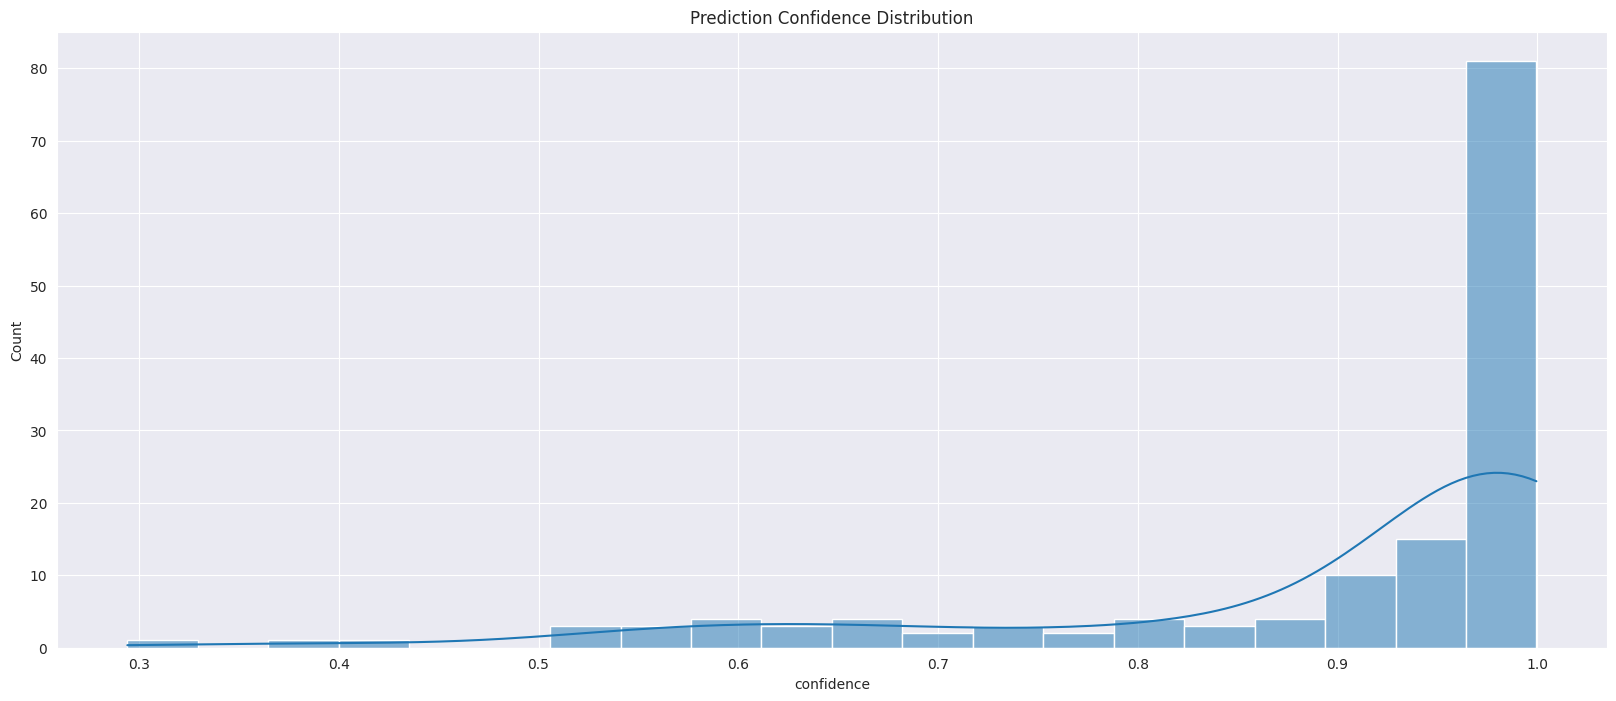

In [25]:
# Plot confidence distribution
plt.figure(figsize=(20, 8))
sns.histplot(conf_preds_df['confidence'], bins=20, kde=True)
plt.title("Prediction Confidence Distribution")
plt.show()

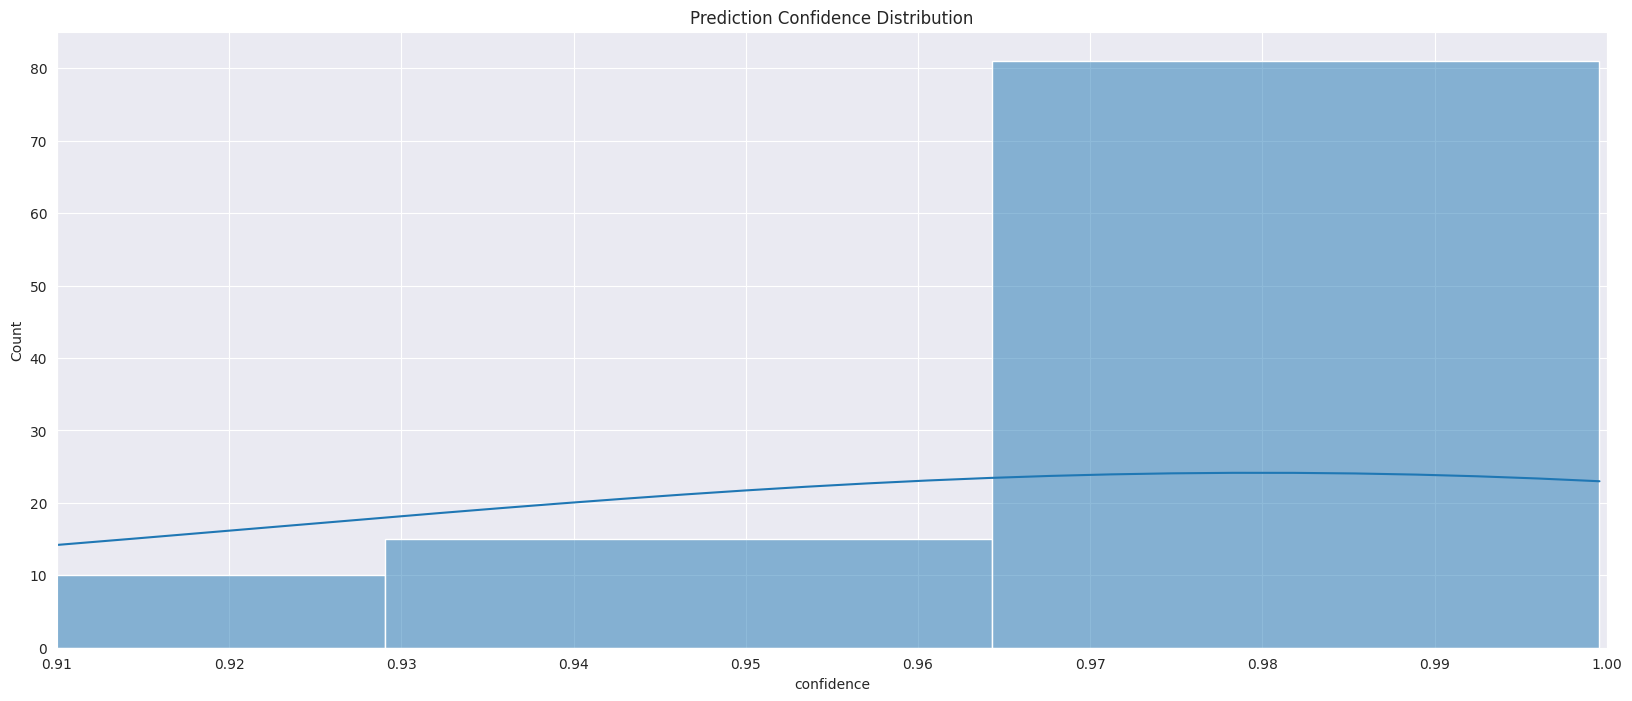

In [26]:
# Zooming in, restricting the plot to the range 0.91 and more
plt.figure(figsize=(20, 8))
sns.histplot(conf_preds_df['confidence'], bins=20, kde=True)

plt.xlim(0.91, 1.00)
plt.xticks(np.round(np.arange(0.91, 1.001, 0.01), 2))
plt.title("Prediction Confidence Distribution")
plt.show()

Looks like thresholds of 0.97 and above are giving us a decent number of samples, which is great. Now let’s see exactly how many pseudo-labeled images we have at each confidence level. This will help us decide how much synthetic data we can confidently include in the next training round


Let’s check the counts:

In [28]:
# Load the predictions with confidence
temp_df = pd.read_csv(os.path.join(CONFIG.processed_data_dir, "initial_submission_with_confidence.csv"))

# Check how many samples we get for each threshold
for threshold in [0.95, 0.96, 0.97, 0.98, 0.99]:
    num_samples = (temp_df["confidence"] >= threshold).sum()
    print(f"Number of pseudo-labels with confidence ≥ {threshold}: {num_samples}")

Number of pseudo-labels with confidence ≥ 0.95: 88
Number of pseudo-labels with confidence ≥ 0.96: 84
Number of pseudo-labels with confidence ≥ 0.97: 79
Number of pseudo-labels with confidence ≥ 0.98: 71
Number of pseudo-labels with confidence ≥ 0.99: 50


At 97% confidence, the pseudo-labeled data are actually super clean. But here's the thing, if we just relax the threshold a tiny bit to 96%, we actually gain ~5 more samples, bringing the total to ~84 out of 114 test images. That's a solid boost, considering how small our test set is

Well, I'm greedy 😄, our model would appreciate these additional images, so let's stick with the 96% threshold. 

But before that, let’s do a quick sanity check and visualize these images with their predicted labels. We want to make sure they look reasonable and not completely off

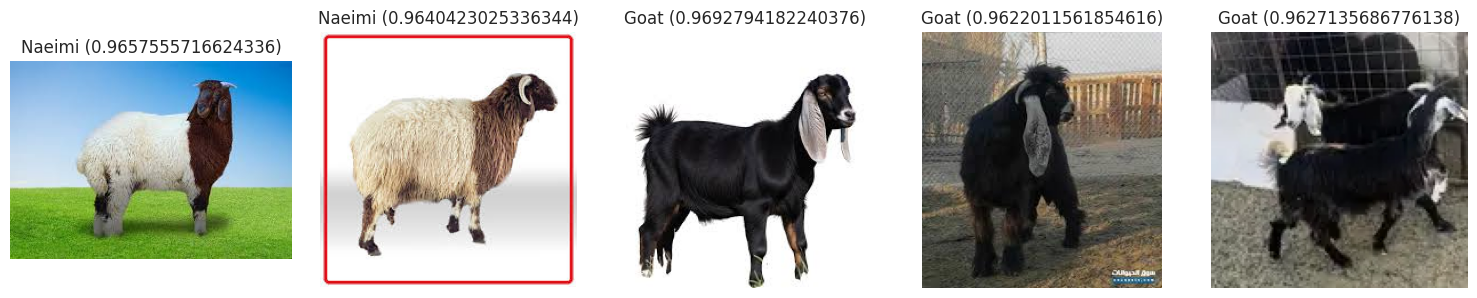

In [29]:
subset = temp_df[(temp_df["confidence"] >= 0.96) & (temp_df["confidence"] < 0.97)].reset_index(drop=True)

for i in range(0, len(subset), 5):
    batch = subset.iloc[i:i+5]
    plt.figure(figsize=(15, 3))
    for j, row in batch.iterrows():
        img_path = os.path.join(CONFIG.test_dir, row["filename"])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, 5, j % 5 + 1)
        plt.imshow(img)
        plt.title(f'{row["label"]} ({row["confidence"]})')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [30]:
print("=" * 60)
print("PHASE 2: Pseudo-Label Generation")
print("=" * 60)

# Generate pseudo-labels with high threshold
pseudo_df = generate_pseudo_labels(models, test_loader, threshold=0.96)
# convert index to categorcal labels (to be matched with train_df when we combine)
pseudo_df["label"] = pseudo_df["label"].map(idx2label)

PHASE 2: Pseudo-Label Generation


Generating pseudo labels ≥ 0.96 confidence: 100%|██████████| 18/18 [00:04<00:00,  3.61it/s]

Generated 84 pseudo-labels out of 144 test images
Excluded 60 low-confidence predictions


In [31]:
# Saving it
pseudo_df.to_csv(
    os.path.join(CONFIG.processed_data_dir, "pseudo_labels.csv"), index=False
)

In [32]:
# Analyze pseudo-label distribution
print(f"\nPseudo-label class distribution:")
print(pseudo_df["label"].value_counts().sort_index())


Pseudo-label class distribution:
label
Barbari     8
Goat       18
Harri       4
Naeimi      8
Najdi      17
Roman      18
Sawakni    11
Name: count, dtype: int64


## 5.2 K-Mean Clustering

Okay, so pseudo-labeling gave us a nice batch of confident samples, but what about the rest of the test set?

Instead of not considering them in our final training, we try to recover more clean samples through unsupervised clustering. Here's the idea:

- We pass all test images through our model and extract high-dimensional feature embeddings from the penultimate layer
- Then, we use KMeans (with k=7 for our 7 classes) to group these features into clusters
- Finally, we infer the class of each cluster by checking which pseudo-labels (from our earlier step) dominate that cluster

Once we’ve got cluster labels, we compute a cluster purity score: how consistent is each cluster internally? If a cluster mostly contains images with the same pseudo-label, we call it a pure cluster

To be safe, we only keep clusters with ≥ 90% purity, and even then, we extract only the most "central" samples, ones closest to the cluster center in feature space. These are the ones we're most confident about

PHASE 3: K-Mean Clustering


Loading models: 100%|██████████| 5/5 [00:09<00:00,  1.90s/it]



Loaded 5 models
144 test images loaded.
Using 5 ensemble models.
Using 5 models for feature extraction


Extracting features: 100%|██████████| 18/18 [00:04<00:00,  3.67it/s]


Number of clusters found: 7


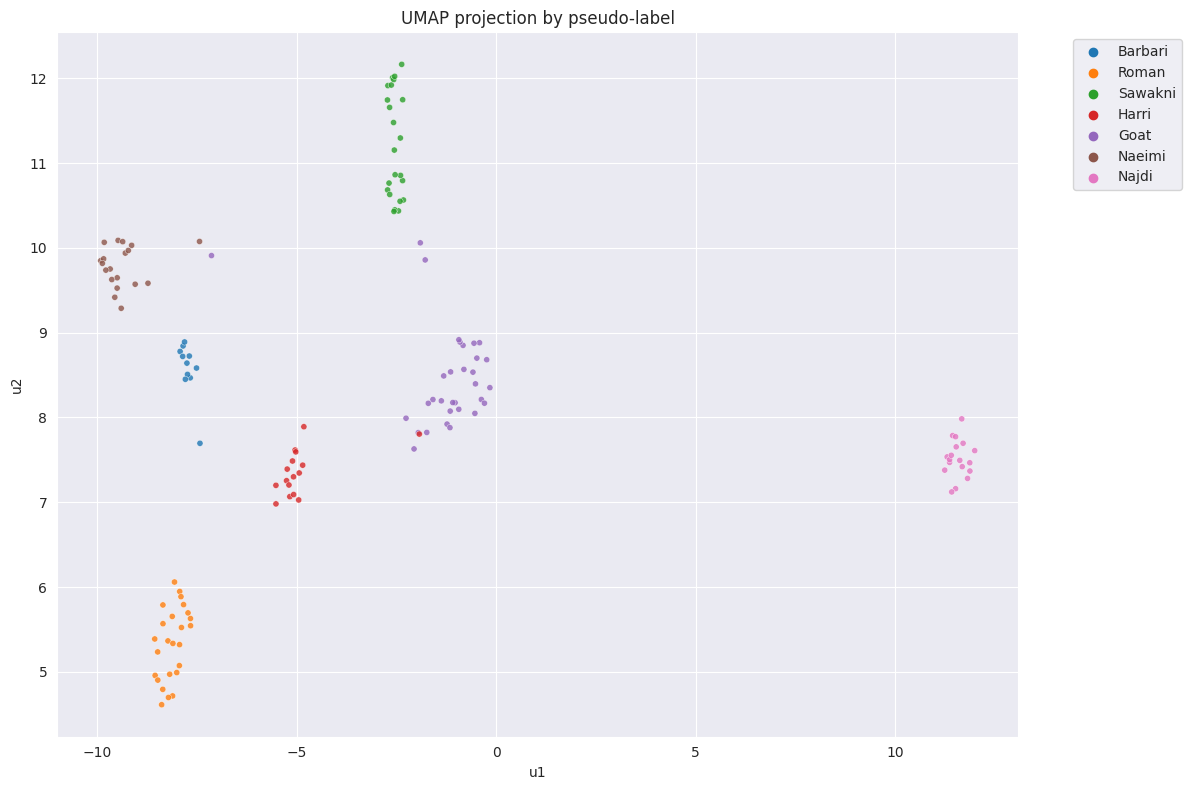

Clustered CSV saved to processed_data/clustered_test_results.csv
Calculating cluster purity...
Building merged CSV...
Selected purity threshold: 0.9
Original train samples: 682
Pseudo labeled samples: 84
Cluster samples after purity filtering and core sample filtering: 32
Merged CSV saved to processed_data/pseudo_clustered_merged.csv
Total samples after merging: 798


In [33]:
pseudo_df = pd.read_csv(os.path.join(CONFIG.processed_data_dir, "pseudo_labels.csv"))
train_df = pd.read_csv(CONFIG.train_csv)
output_dir = CONFIG.processed_data_dir

print("=" * 60)
print("PHASE 3: K-Mean Clustering")
print("=" * 60)

clusterer = KMeansClustering(pseudo_df=pseudo_df, train_df=train_df, output_dir=output_dir)
df_clusters, merged_df = clusterer.run()

So, the clustering step gave us **~32 extra images** with a **purity threshold of 0.9**, that’s 32 confident samples we didn’t have before. Earlier, during pseudo-labeling, we skipped anything below 96% confidence. These new samples came straight from the model’s feature space, got grouped using KMeans, and we kept only the clusters that were internally consistent (i.e., pure).

So now, our **synthetic dataset is getting richer**, made up of:

- trusted samples from `train.csv` images (with 100% confidence)
- `pseudo_labels.csv` predictions (~97% confident from the model)
- and now these brand new **clustered confident samples**  pulled from the high-purity clusters

Let’s dig into the clustering results and check how well the clusters align with the pseudo labels

We’ve got two main DataFrames to explore:


1. `df_clusters`: the full clustering result, with columns like `filename`, `cluster`, `u1`, `u2`, `pred_label`, and `pconf` (confidence from the pseudo-labeling phase)
2. `merged_df`: the filtered & merged dataset with `filename`, `label`, `confidence`, and `source` (train/pseudo/cluster) (train / pseudo / cluster). This is what we’ll actually use for **retraining**

In [34]:
# test dataset, with pseudo confidence (model's output), predicted label (pseudo-labeling), and cluster id (KMeans clustering)

display(df_clusters)

filename  cluster        u1         u2 pred_label     pconf
0    0306fa89.jpg        3 -7.918859   8.778790    Barbari  0.994369
1    0345e3ca.jpg        1 -8.107079   4.716691      Roman  0.989948
2    0551a473.jpg        0 -2.719635  10.683181    Sawakni  0.996187
3    06e1783d.jpg        4 -5.517995   7.199934      Harri       NaN
4    08b9981b.jpg        3 -7.853657   8.720270    Barbari       NaN
..            ...      ...       ...        ...        ...       ...
139  f3e7b1fe.jpg        1 -8.477187   4.903242      Roman  0.997199
140  faadf33d.jpg        1 -8.352858   4.794268      Roman  0.998624
141  fbf2e74c.jpg        0 -2.400843  11.295754    Sawakni       NaN
142  ff19c491.jpg        0 -2.723980  11.743940    Sawakni       NaN
143  ffa67e5c.jpg        3 -7.421095   7.695583    Barbari       NaN

[144 rows x 6 columns]

- **filename** is the image filename (from the test set)
- **cluster** is the ID of the cluster this image was assigned to by KMeans. Images in the same cluster share visual similarity based on learned features
- **u1, u2** are the 2D UMAP coordinates (embeddings), used for visualizing clusters. These reduce the complex features into two numbers so we can plot them nicely
- **pred_label** is the predicted label for this image, (based on the most other common pseudo-label, lol) in its cluster, kind of a "majority guess"
- **pconf**, the model’s pseudo-label confidence. If this is NaN, it means the image didn’t meet the confidence threshold during pseudo-labeling, so it was only included through clustering

In [35]:
# The new dataset we will use in the next phase, they are a merge of train, and test data (pseudo, and cluster-labeled)
# The source tells us how we got the label.
display(merged_df)

filename    label  confidence   source
0    39d30b68.jpg   Naeimi         1.0    train
1    4a9853bd.jpg     Goat         1.0    train
2    d88facaa.jpg    Roman         1.0    train
3    a3f4f4af.jpg    Roman         1.0    train
4    16b31730.jpg   Naeimi         1.0    train
..            ...      ...         ...      ...
793  a6518778.jpg  Sawakni         0.9  cluster
794  ab9babec.jpg  Sawakni         0.9  cluster
795  e8c1e128.jpg  Sawakni         0.9  cluster
796  ff19c491.jpg  Sawakni         0.9  cluster
797  bd22c104.jpg    Najdi         0.9  cluster

[798 rows x 4 columns]

In [36]:
# number of samples in each cluster
df_clusters['cluster'].value_counts().sort_index()

cluster
0    23
1    25
2    32
3    11
4    16
5    19
6    18
Name: count, dtype: int64

In [37]:
# # The dominant pseudo-labels in each cluster
cluster_label_dist = df_clusters.groupby('cluster')['pred_label'].value_counts(normalize=True).unstack().fillna(0)
cluster_label_dist.style.background_gradient(cmap='Blues')

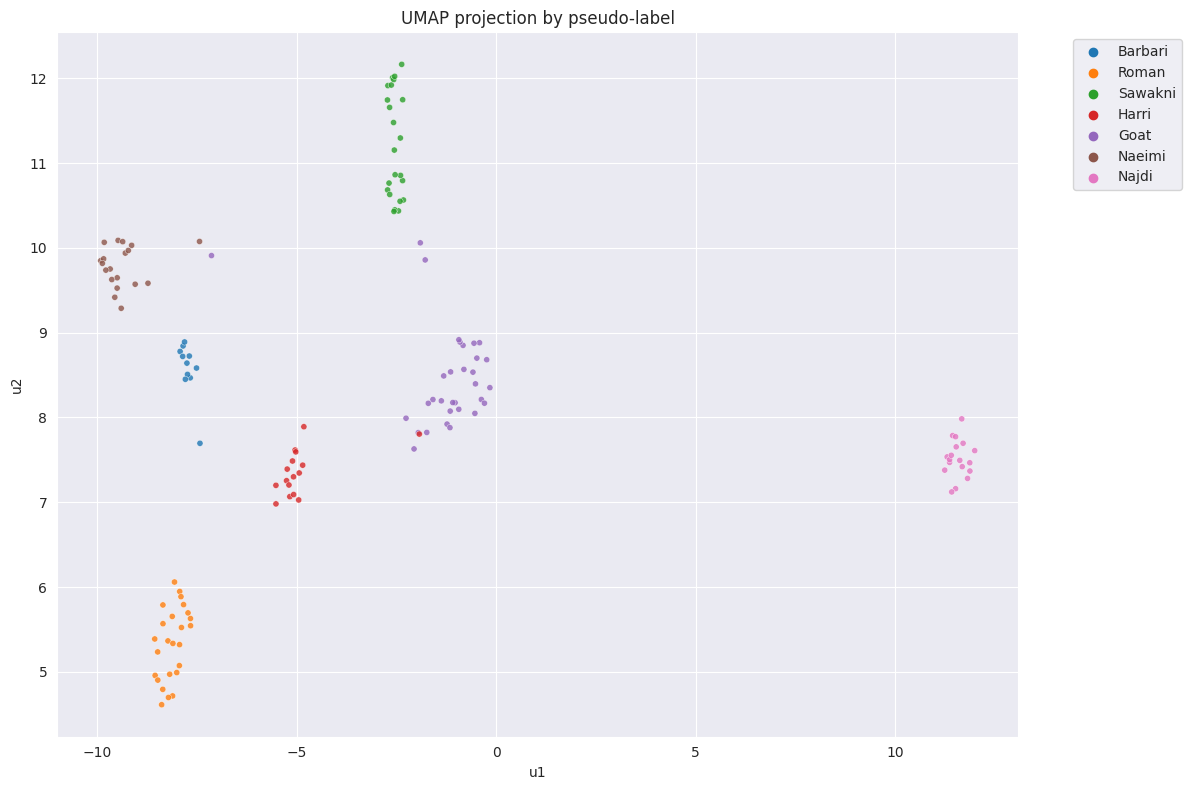

In [38]:
show_clusters(df_clusters)

As you can see, not all the clustered samples were grouped cleanly, some were scattered or didn't align well with the cluster's overall pattern. That’s why we needed to filter out the noisy ones

We first removed outliers, i.e., the samples labeled as noise or those belonging to inconsistent clusters. Then, for each remaining cluster, we did the following:

- Calculated the Euclidean distance between each sample and the cluster centroid using [cdist](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html)
- The centroid here is simply the mean feature vector of all samples in that cluster — it represents the "center" of the group
- This distance tells us how far a sample is from the cluster's core. Samples that are closer to the center are more likely to be reliable representatives of that class
- We then chose a cutoff based on a percentile — we used the 50th percentile (the median). Any sample closer than this distance was kept

This process gave us ~28 clean, representative samples from the clusters, the real core members of each group.

Let’s take a quick look at them

Number of clustered confident samples: 32


<Axes: title={'center': 'Clustered Label Distribution'}, xlabel='label'>

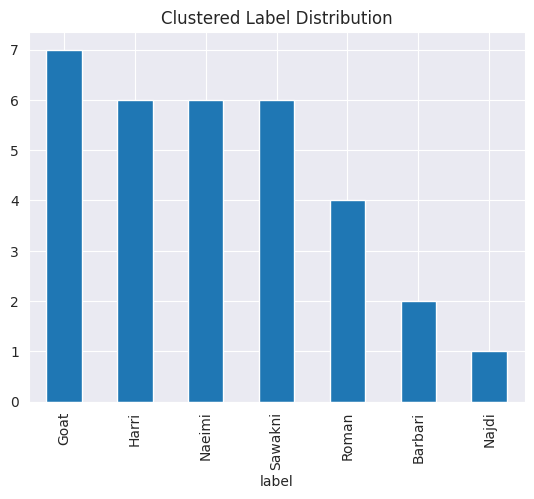

In [39]:
clustered_samples = merged_df[merged_df['source'] == 'cluster']
print(f"Number of clustered confident samples: {len(clustered_samples)}")
# Distribution of classes
clustered_samples['label'].value_counts().plot(kind='bar', title='Clustered Label Distribution')

In [40]:
clustered_samples[['filename', 'label', 'confidence']].head(30)

filename    label  confidence
766  2ebc35e2.jpg    Harri         0.9
767  30503f9d.jpg    Harri         0.9
768  3be8b97b.jpg    Harri         0.9
769  93982d6d.jpg    Harri         0.9
770  bb126871.jpg    Harri         0.9
771  d72ea4f1.jpg    Harri         0.9
772  1432d91c.jpg  Barbari         0.9
773  ffa67e5c.jpg  Barbari         0.9
774  0cfc6a1e.jpg     Goat         0.9
775  24f34b9e.jpg     Goat         0.9
776  2b5fa46a.jpg     Goat         0.9
777  47385f1a.jpg     Goat         0.9
778  74b88387.jpg     Goat         0.9
779  895567eb.jpg     Goat         0.9
780  ac78a48d.jpg     Goat         0.9
781  63be3b9a.jpg    Roman         0.9
782  8bba2746.jpg    Roman         0.9
783  da484961.jpg    Roman         0.9
784  e26ccad9.jpg    Roman         0.9
785  226dc6ee.jpg   Naeimi         0.9
786  3c5436f0.jpg   Naeimi         0.9
787  56728cf9.jpg   Naeimi         0.9
788  8e619920.jpg   Naeimi         0.9
789  a9ed036d.jpg   Naeimi         0.9
790  f080711d.jpg   Naeimi         0.9
791  5d3b3719.jpg  Sawakni         0.9
792  85fe3a81.jpg  Sawakni         0.9
793  a6518778.jpg  Sawakni         0.9
794  ab9babec.jpg  Sawakni         0.9
795  e8c1e128.jpg  Sawakni         0.9

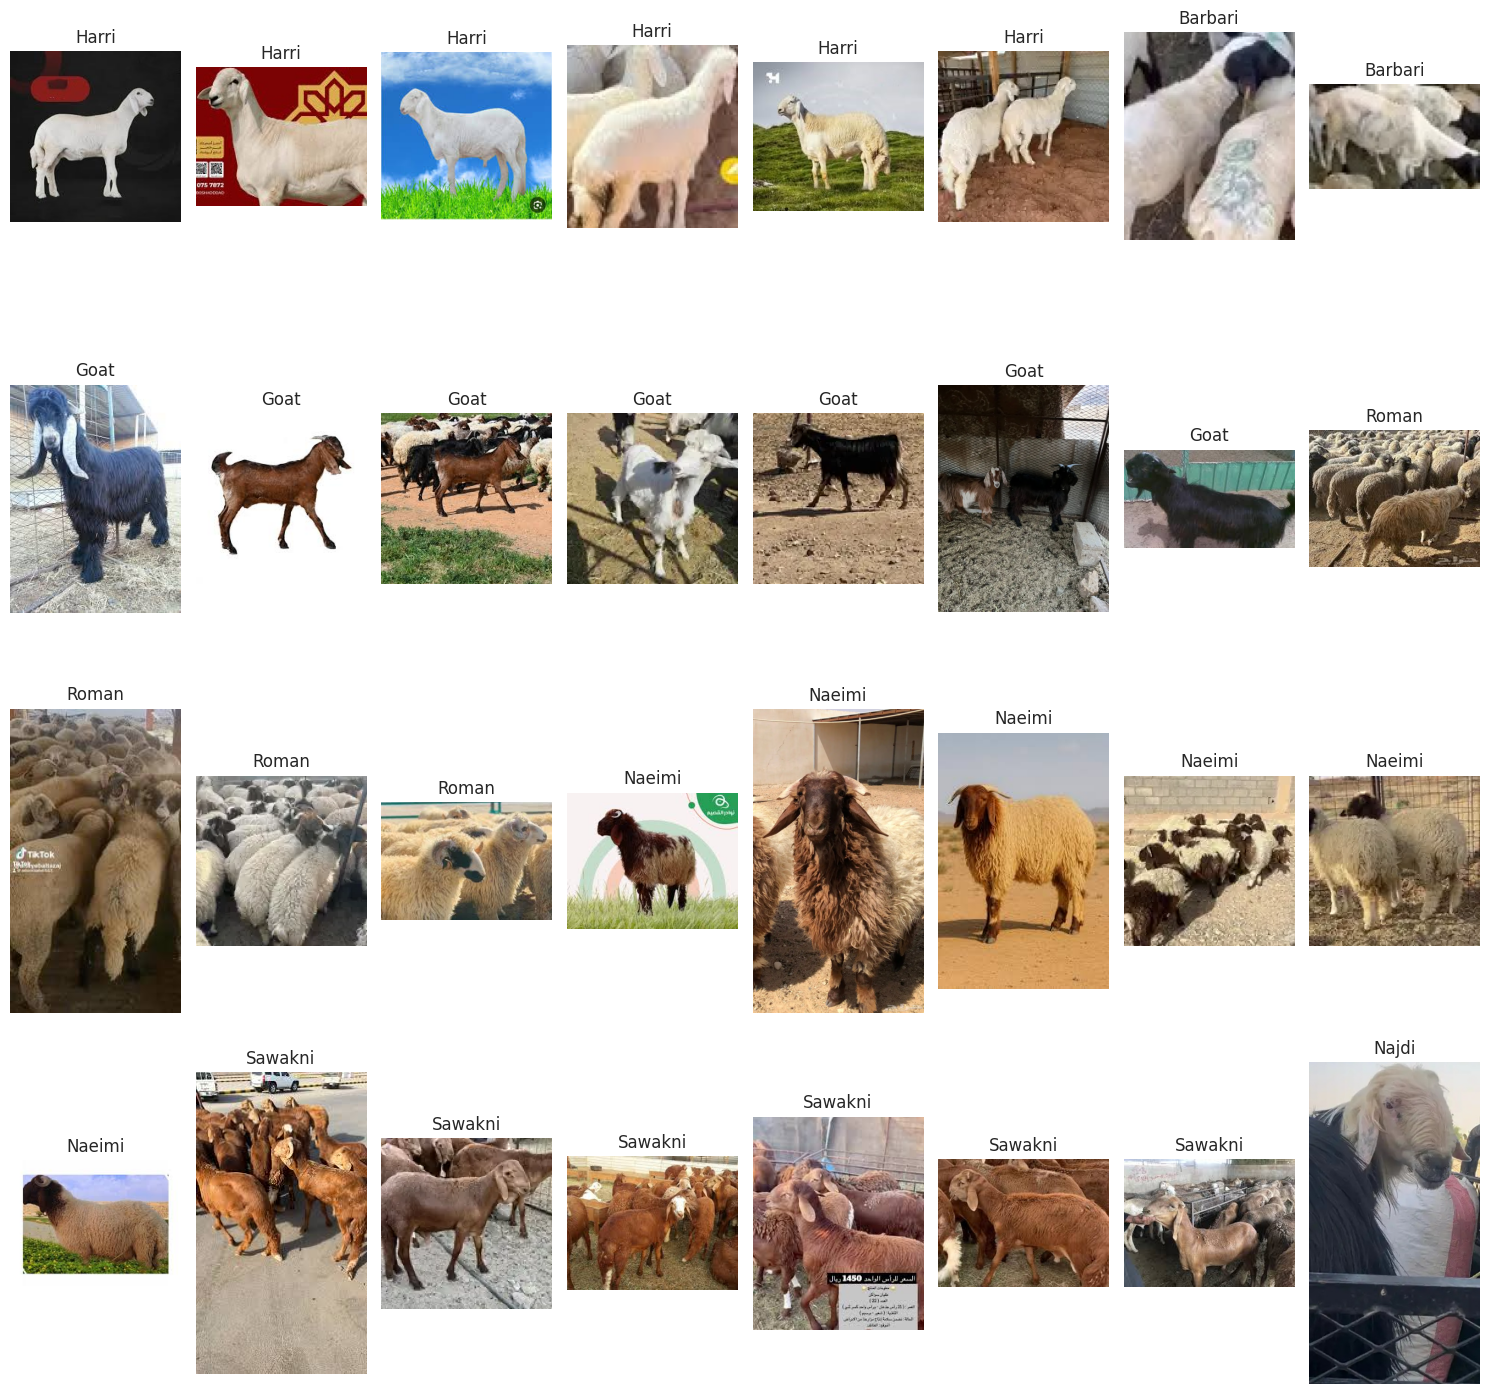

In [41]:
# lets plot them 

fig, axes = plt.subplots(4, 8, figsize=(15, 15))
axes = axes.flatten()

for i, row in enumerate(clustered_samples.itertuples()):
    img_path = os.path.join(CONFIG.test_dir, row.filename) # test dir / filename
    img = Image.open(img_path)
    axes[i].imshow(img)
    axes[i].set_title(row.label) # label
    axes[i].axis('off')

plt.tight_layout()
plt.show()

We just gained more clean data, sounds awesome, right? :’)

Now, let’s prepare this enriched dataset and kick off our final training phase!

<Axes: title={'center': 'Sample Count by Source'}, xlabel='source'>

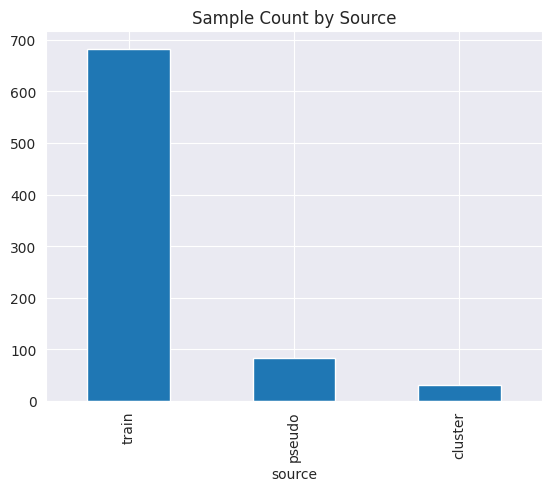

In [42]:
# count how many samples come from each source (train / pseudo / cluster)
merged_df['source'].value_counts().plot(kind='bar', title='Sample Count by Source')

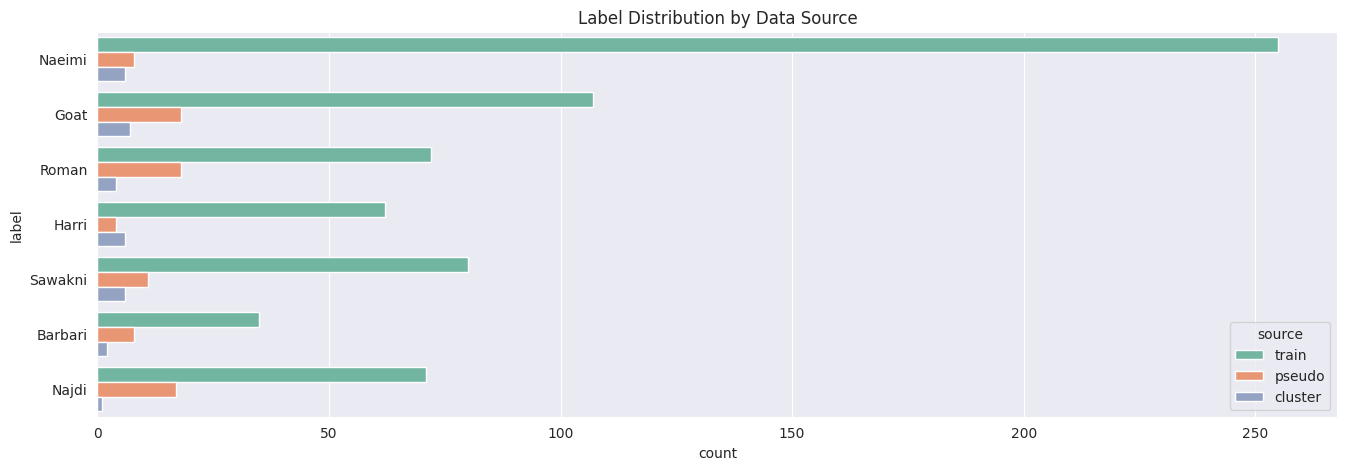

In [43]:
# we still got imbalanced dataset, but it's better than before
plt.figure(figsize=(16, 5))
sns.countplot(data=merged_df, y='label', hue='source', palette='Set2')
plt.title('Label Distribution by Data Source')
plt.show()

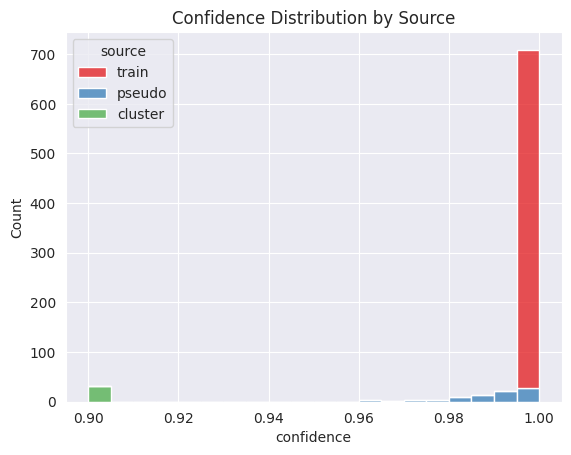

In [44]:
# conf histogram by source type (train = 1.0, pseudo ≈ 0.97, cluster = 0.9)
# cluster confidence is set to 0.9 as the purity threshold
# pseudo confidence is set to 0.97 as the threshold for pseudo-labeling
# train confidence is 1.0 as we know it's 100% confident
sns.histplot(
    data=merged_df,
    x='confidence',
    hue='source',
    bins=20,
    multiple='stack',
    palette='Set1'
)
plt.title('Confidence Distribution by Source')
plt.show()

# 6. Final Training

In [45]:
# Loading the original train set
merged_df = pd.read_csv(os.path.join(CONFIG.processed_data_dir, "pseudo_clustered_merged.csv"))
print("Length of original training set: {}".format(len(merged_df)))
display(merged_df)

Length of original training set: 798


filename    label  confidence   source
0    39d30b68.jpg   Naeimi         1.0    train
1    4a9853bd.jpg     Goat         1.0    train
2    d88facaa.jpg    Roman         1.0    train
3    a3f4f4af.jpg    Roman         1.0    train
4    16b31730.jpg   Naeimi         1.0    train
..            ...      ...         ...      ...
793  a6518778.jpg  Sawakni         0.9  cluster
794  ab9babec.jpg  Sawakni         0.9  cluster
795  e8c1e128.jpg  Sawakni         0.9  cluster
796  ff19c491.jpg  Sawakni         0.9  cluster
797  bd22c104.jpg    Najdi         0.9  cluster

[798 rows x 4 columns]

Btw, from here on, we have nearly 800 training samples, and only ~34 images left for predictions, so I think it’s safe to train the model normally.No need for cross-validation, I’ll continue with cross-validation folds just to stay consistent with my earlier training strategy.

But for anyone interested, I do have a simple standard training function (non-folded) for reference, find it [here](https://github.com/ahmedsalim3/sheep-classification-challenge/blob/main/src/modeling/train_eval.py#L386-L532)

In [46]:
label2idx, idx2label = get_label_maps()
# Map labels to indices
merged_df["label"] = merged_df["label"].map(label2idx)

merged_df.head()

filename  label  confidence source
0  39d30b68.jpg      3         1.0  train
1  4a9853bd.jpg      1         1.0  train
2  d88facaa.jpg      5         1.0  train
3  a3f4f4af.jpg      5         1.0  train
4  16b31730.jpg      3         1.0  train

PHASE 4: Retraining with Train + Pseudo-Labeled + Clustered Synthetic Data

====================================================================== FOLD 1 ======================================================================
Train distribution: [36, 105, 57, 215, 71, 76, 78], Length: 638
Val distribution: [9, 27, 15, 54, 18, 18, 19], Length: 160


Validating: 100%|██████████| 20/20 [00:01<00:00, 12.87it/s]


Fold 1 | Epoch 1 | Train Loss: 0.8455 | Train Acc: 0.3434 | Val Loss: 0.1580 | Val Acc: 0.8187 | Val F1 Macro: 0.8072 | Val F1 Weighted: 0.8209
New best F1-macro for Fold 1 at epoch 1. Model saved. Current Best F1-macro: 0.8072


Validating: 100%|██████████| 20/20 [00:01<00:00, 13.06it/s]


Fold 1 | Epoch 2 | Train Loss: 0.2839 | Train Acc: 0.6962 | Val Loss: 0.0923 | Val Acc: 0.9000 | Val F1 Macro: 0.8801 | Val F1 Weighted: 0.9032
New best F1-macro for Fold 1 at epoch 2. Model saved. Current Best F1-macro: 0.8801


Validating: 100%|██████████| 20/20 [00:01<00:00, 12.80it/s]


Fold 1 | Epoch 3 | Train Loss: 0.1688 | Train Acc: 0.8054 | Val Loss: 0.0579 | Val Acc: 0.9250 | Val F1 Macro: 0.9165 | Val F1 Weighted: 0.9249
New best F1-macro for Fold 1 at epoch 3. Model saved. Current Best F1-macro: 0.9165


Validating: 100%|██████████| 20/20 [00:01<00:00, 12.88it/s]


Fold 1 | Epoch 4 | Train Loss: 0.1536 | Train Acc: 0.8386 | Val Loss: 0.0797 | Val Acc: 0.9000 | Val F1 Macro: 0.9074 | Val F1 Weighted: 0.9046


Validating: 100%|██████████| 20/20 [00:01<00:00, 13.29it/s]


Fold 1 | Epoch 5 | Train Loss: 0.0819 | Train Acc: 0.9082 | Val Loss: 0.0700 | Val Acc: 0.9187 | Val F1 Macro: 0.9121 | Val F1 Weighted: 0.9214


Validating: 100%|██████████| 20/20 [00:01<00:00, 12.83it/s]


Fold 1 | Epoch 6 | Train Loss: 0.0650 | Train Acc: 0.9335 | Val Loss: 0.0684 | Val Acc: 0.9500 | Val F1 Macro: 0.9430 | Val F1 Weighted: 0.9496
New best F1-macro for Fold 1 at epoch 6. Model saved. Current Best F1-macro: 0.9430


Validating: 100%|██████████| 20/20 [00:01<00:00, 13.17it/s]


Fold 1 | Epoch 7 | Train Loss: 0.0449 | Train Acc: 0.9557 | Val Loss: 0.0724 | Val Acc: 0.9563 | Val F1 Macro: 0.9494 | Val F1 Weighted: 0.9565
New best F1-macro for Fold 1 at epoch 7. Model saved. Current Best F1-macro: 0.9494


Validating: 100%|██████████| 20/20 [00:01<00:00, 12.94it/s]


Fold 1 | Epoch 8 | Train Loss: 0.0286 | Train Acc: 0.9620 | Val Loss: 0.0616 | Val Acc: 0.9563 | Val F1 Macro: 0.9488 | Val F1 Weighted: 0.9562


Validating: 100%|██████████| 20/20 [00:01<00:00, 12.86it/s]


Fold 1 | Epoch 9 | Train Loss: 0.0218 | Train Acc: 0.9604 | Val Loss: 0.0598 | Val Acc: 0.9563 | Val F1 Macro: 0.9458 | Val F1 Weighted: 0.9565


Validating: 100%|██████████| 20/20 [00:01<00:00, 12.88it/s]


Fold 1 | Epoch 10 | Train Loss: 0.0280 | Train Acc: 0.9620 | Val Loss: 0.0529 | Val Acc: 0.9500 | Val F1 Macro: 0.9451 | Val F1 Weighted: 0.9503


Validating: 100%|██████████| 20/20 [00:01<00:00, 12.17it/s]


Fold 1 | Epoch 11 | Train Loss: 0.0488 | Train Acc: 0.9668 | Val Loss: 0.0898 | Val Acc: 0.9375 | Val F1 Macro: 0.9399 | Val F1 Weighted: 0.9382


Validating: 100%|██████████| 20/20 [00:01<00:00, 12.91it/s]


Fold 1 | Epoch 12 | Train Loss: 0.0342 | Train Acc: 0.9699 | Val Loss: 0.0658 | Val Acc: 0.9688 | Val F1 Macro: 0.9716 | Val F1 Weighted: 0.9689
New best F1-macro for Fold 1 at epoch 12. Model saved. Current Best F1-macro: 0.9716


Validating: 100%|██████████| 20/20 [00:01<00:00, 12.76it/s]


Fold 1 | Epoch 13 | Train Loss: 0.0279 | Train Acc: 0.9715 | Val Loss: 0.0752 | Val Acc: 0.9688 | Val F1 Macro: 0.9716 | Val F1 Weighted: 0.9689


Validating: 100%|██████████| 20/20 [00:01<00:00, 12.85it/s]


Fold 1 | Epoch 14 | Train Loss: 0.0298 | Train Acc: 0.9731 | Val Loss: 0.0678 | Val Acc: 0.9563 | Val F1 Macro: 0.9607 | Val F1 Weighted: 0.9570


Validating: 100%|██████████| 20/20 [00:01<00:00, 12.61it/s]


Fold 1 | Epoch 15 | Train Loss: 0.0064 | Train Acc: 0.9873 | Val Loss: 0.0387 | Val Acc: 0.9688 | Val F1 Macro: 0.9716 | Val F1 Weighted: 0.9689


Validating: 100%|██████████| 20/20 [00:01<00:00, 12.94it/s]


Fold 1 | Epoch 16 | Train Loss: 0.0128 | Train Acc: 0.9889 | Val Loss: 0.0471 | Val Acc: 0.9625 | Val F1 Macro: 0.9642 | Val F1 Weighted: 0.9626


Validating: 100%|██████████| 20/20 [00:01<00:00, 12.68it/s]


Fold 1 | Epoch 17 | Train Loss: 0.0144 | Train Acc: 0.9810 | Val Loss: 0.0632 | Val Acc: 0.9688 | Val F1 Macro: 0.9716 | Val F1 Weighted: 0.9689
Early stopping at epoch 17

----- Classification Report -----
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000         9
           1     0.9630    0.9630    0.9630        27
           2     1.0000    1.0000    1.0000        15
           3     0.9811    0.9630    0.9720        54
           4     1.0000    1.0000    1.0000        18
           5     0.8947    0.9444    0.9189        18
           6     0.9474    0.9474    0.9474        19

    accuracy                         0.9688       160
   macro avg     0.9695    0.9740    0.9716       160
weighted avg     0.9693    0.9688    0.9689       160


----- Confusion Matrix -----
[[ 9  0  0  0  0  0  0]
 [ 0 26  0  1  0  0  0]
 [ 0  0 15  0  0  0  0]
 [ 0  0  0 52  0  2  0]
 [ 0  0  0  0 18  0  0]
 [ 0  0  0  0  0 17  1]
 [ 0  1  0  0  0  0 18

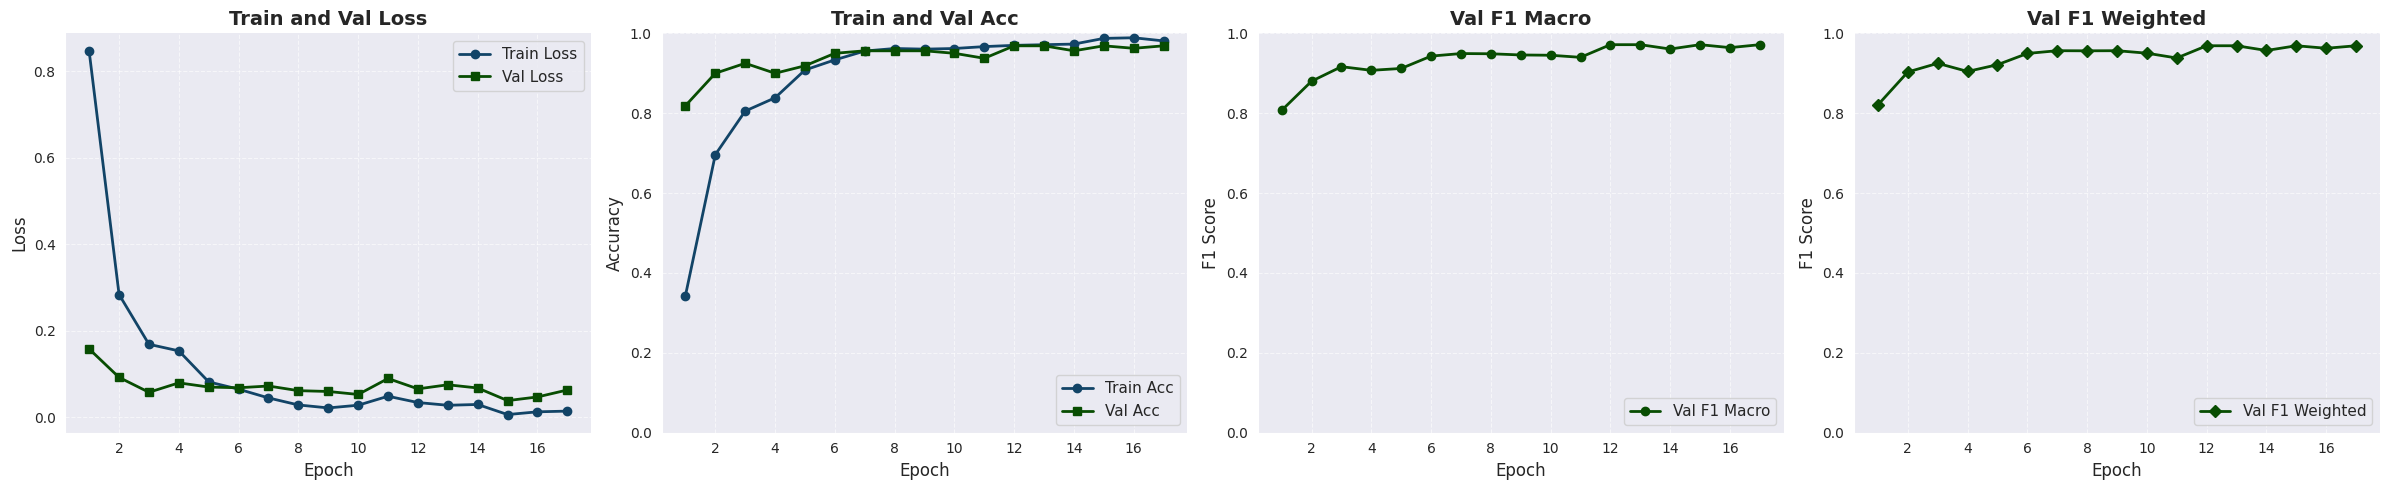


Fold 1 best F1: 0.9716

====================================================================== FOLD 2 ======================================================================
Train distribution: [36, 106, 57, 215, 71, 75, 78], Length: 638
Val distribution: [9, 26, 15, 54, 18, 19, 19], Length: 160


Validating: 100%|██████████| 20/20 [00:01<00:00, 12.57it/s]


Fold 2 | Epoch 1 | Train Loss: 0.7490 | Train Acc: 0.4778 | Val Loss: 0.2264 | Val Acc: 0.8000 | Val F1 Macro: 0.7977 | Val F1 Weighted: 0.8035
New best F1-macro for Fold 2 at epoch 1. Model saved. Current Best F1-macro: 0.7977


Validating: 100%|██████████| 20/20 [00:01<00:00, 11.76it/s]


Fold 2 | Epoch 2 | Train Loss: 0.2683 | Train Acc: 0.7184 | Val Loss: 0.1188 | Val Acc: 0.8688 | Val F1 Macro: 0.8573 | Val F1 Weighted: 0.8709
New best F1-macro for Fold 2 at epoch 2. Model saved. Current Best F1-macro: 0.8573


Validating: 100%|██████████| 20/20 [00:01<00:00, 12.66it/s]


Fold 2 | Epoch 3 | Train Loss: 0.1190 | Train Acc: 0.8497 | Val Loss: 0.1331 | Val Acc: 0.8688 | Val F1 Macro: 0.8658 | Val F1 Weighted: 0.8716
New best F1-macro for Fold 2 at epoch 3. Model saved. Current Best F1-macro: 0.8658


Validating: 100%|██████████| 20/20 [00:01<00:00, 12.39it/s]


Fold 2 | Epoch 4 | Train Loss: 0.1331 | Train Acc: 0.8703 | Val Loss: 0.1150 | Val Acc: 0.8812 | Val F1 Macro: 0.8866 | Val F1 Weighted: 0.8841
New best F1-macro for Fold 2 at epoch 4. Model saved. Current Best F1-macro: 0.8866


Validating: 100%|██████████| 20/20 [00:01<00:00, 12.58it/s]


Fold 2 | Epoch 5 | Train Loss: 0.0919 | Train Acc: 0.9066 | Val Loss: 0.1214 | Val Acc: 0.9125 | Val F1 Macro: 0.9108 | Val F1 Weighted: 0.9134
New best F1-macro for Fold 2 at epoch 5. Model saved. Current Best F1-macro: 0.9108


Validating: 100%|██████████| 20/20 [00:01<00:00, 12.39it/s]


Fold 2 | Epoch 6 | Train Loss: 0.0501 | Train Acc: 0.9462 | Val Loss: 0.1185 | Val Acc: 0.9187 | Val F1 Macro: 0.9182 | Val F1 Weighted: 0.9194
New best F1-macro for Fold 2 at epoch 6. Model saved. Current Best F1-macro: 0.9182


Validating: 100%|██████████| 20/20 [00:01<00:00, 12.52it/s]


Fold 2 | Epoch 7 | Train Loss: 0.0216 | Train Acc: 0.9525 | Val Loss: 0.1232 | Val Acc: 0.9375 | Val F1 Macro: 0.9315 | Val F1 Weighted: 0.9374
New best F1-macro for Fold 2 at epoch 7. Model saved. Current Best F1-macro: 0.9315


Validating: 100%|██████████| 20/20 [00:01<00:00, 12.61it/s]


Fold 2 | Epoch 8 | Train Loss: 0.0132 | Train Acc: 0.9652 | Val Loss: 0.0987 | Val Acc: 0.9375 | Val F1 Macro: 0.9369 | Val F1 Weighted: 0.9376
New best F1-macro for Fold 2 at epoch 8. Model saved. Current Best F1-macro: 0.9369


Validating: 100%|██████████| 20/20 [00:01<00:00, 11.85it/s]


Fold 2 | Epoch 9 | Train Loss: 0.0264 | Train Acc: 0.9699 | Val Loss: 0.0905 | Val Acc: 0.9437 | Val F1 Macro: 0.9399 | Val F1 Weighted: 0.9437
New best F1-macro for Fold 2 at epoch 9. Model saved. Current Best F1-macro: 0.9399


Validating: 100%|██████████| 20/20 [00:01<00:00, 12.42it/s]


Fold 2 | Epoch 10 | Train Loss: 0.0239 | Train Acc: 0.9636 | Val Loss: 0.1066 | Val Acc: 0.9625 | Val F1 Macro: 0.9646 | Val F1 Weighted: 0.9624
New best F1-macro for Fold 2 at epoch 10. Model saved. Current Best F1-macro: 0.9646


Validating: 100%|██████████| 20/20 [00:01<00:00, 12.20it/s]


Fold 2 | Epoch 11 | Train Loss: 0.0467 | Train Acc: 0.9604 | Val Loss: 0.1047 | Val Acc: 0.9625 | Val F1 Macro: 0.9596 | Val F1 Weighted: 0.9629


Validating: 100%|██████████| 20/20 [00:01<00:00, 12.45it/s]


Fold 2 | Epoch 12 | Train Loss: 0.0205 | Train Acc: 0.9731 | Val Loss: 0.1297 | Val Acc: 0.9563 | Val F1 Macro: 0.9543 | Val F1 Weighted: 0.9565


Validating: 100%|██████████| 20/20 [00:01<00:00, 12.37it/s]


Fold 2 | Epoch 13 | Train Loss: 0.0102 | Train Acc: 0.9747 | Val Loss: 0.1242 | Val Acc: 0.9437 | Val F1 Macro: 0.9475 | Val F1 Weighted: 0.9439


Validating: 100%|██████████| 20/20 [00:01<00:00, 12.33it/s]


Fold 2 | Epoch 14 | Train Loss: 0.0194 | Train Acc: 0.9731 | Val Loss: 0.1190 | Val Acc: 0.9625 | Val F1 Macro: 0.9596 | Val F1 Weighted: 0.9629


Validating: 100%|██████████| 20/20 [00:01<00:00, 12.37it/s]


Fold 2 | Epoch 15 | Train Loss: 0.0221 | Train Acc: 0.9842 | Val Loss: 0.1351 | Val Acc: 0.9500 | Val F1 Macro: 0.9451 | Val F1 Weighted: 0.9506
Early stopping at epoch 15

----- Classification Report -----
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000         9
           1     0.9286    1.0000    0.9630        26
           2     0.8824    1.0000    0.9375        15
           3     0.9630    0.9630    0.9630        54
           4     1.0000    1.0000    1.0000        18
           5     1.0000    0.8947    0.9444        19
           6     1.0000    0.8947    0.9444        19

    accuracy                         0.9625       160
   macro avg     0.9677    0.9646    0.9646       160
weighted avg     0.9649    0.9625    0.9624       160


----- Confusion Matrix -----
[[ 9  0  0  0  0  0  0]
 [ 0 26  0  0  0  0  0]
 [ 0  0 15  0  0  0  0]
 [ 0  2  0 52  0  0  0]
 [ 0  0  0  0 18  0  0]
 [ 0  0  0  2  0 17  0]
 [ 0  0  2  0  0  0 17

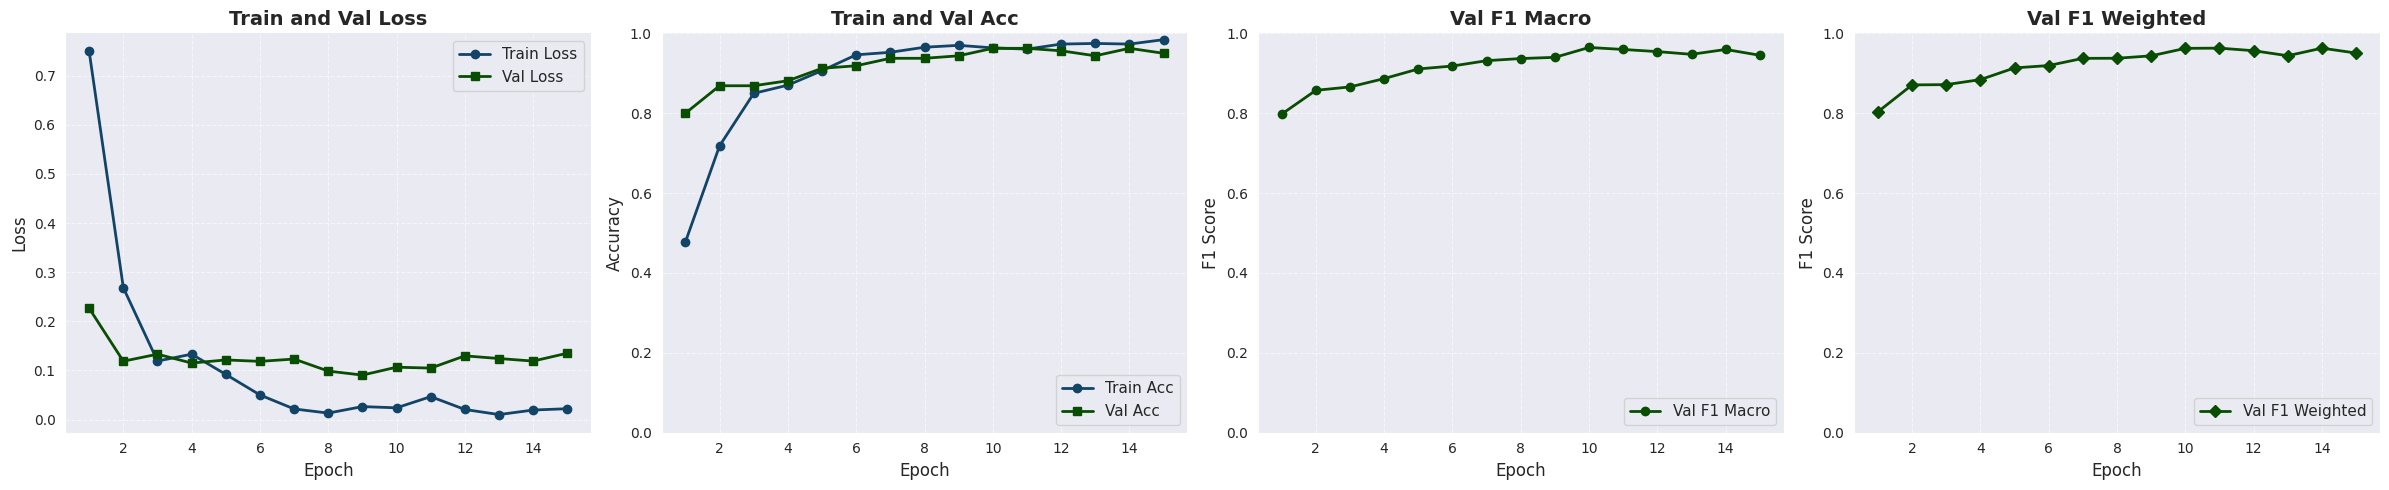


Fold 2 best F1: 0.9646

====================================================================== FOLD 3 ======================================================================
Train distribution: [36, 106, 58, 215, 71, 75, 77], Length: 638
Val distribution: [9, 26, 14, 54, 18, 19, 20], Length: 160


Validating: 100%|██████████| 20/20 [00:01<00:00, 13.03it/s]


Fold 3 | Epoch 1 | Train Loss: 0.7395 | Train Acc: 0.4256 | Val Loss: 0.1645 | Val Acc: 0.8000 | Val F1 Macro: 0.7931 | Val F1 Weighted: 0.8007
New best F1-macro for Fold 3 at epoch 1. Model saved. Current Best F1-macro: 0.7931


Validating: 100%|██████████| 20/20 [00:01<00:00, 12.61it/s]


Fold 3 | Epoch 2 | Train Loss: 0.2334 | Train Acc: 0.7437 | Val Loss: 0.0686 | Val Acc: 0.9000 | Val F1 Macro: 0.8883 | Val F1 Weighted: 0.9007
New best F1-macro for Fold 3 at epoch 2. Model saved. Current Best F1-macro: 0.8883


Validating: 100%|██████████| 20/20 [00:01<00:00, 12.42it/s]


Fold 3 | Epoch 3 | Train Loss: 0.1292 | Train Acc: 0.8449 | Val Loss: 0.0715 | Val Acc: 0.9125 | Val F1 Macro: 0.8983 | Val F1 Weighted: 0.9134
New best F1-macro for Fold 3 at epoch 3. Model saved. Current Best F1-macro: 0.8983


Validating: 100%|██████████| 20/20 [00:01<00:00, 12.91it/s]


Fold 3 | Epoch 4 | Train Loss: 0.1322 | Train Acc: 0.8576 | Val Loss: 0.0532 | Val Acc: 0.9375 | Val F1 Macro: 0.9283 | Val F1 Weighted: 0.9381
New best F1-macro for Fold 3 at epoch 4. Model saved. Current Best F1-macro: 0.9283


Validating: 100%|██████████| 20/20 [00:01<00:00, 12.58it/s]


Fold 3 | Epoch 5 | Train Loss: 0.0896 | Train Acc: 0.9146 | Val Loss: 0.0124 | Val Acc: 0.9500 | Val F1 Macro: 0.9474 | Val F1 Weighted: 0.9503
New best F1-macro for Fold 3 at epoch 5. Model saved. Current Best F1-macro: 0.9474


Validating: 100%|██████████| 20/20 [00:01<00:00, 12.37it/s]


Fold 3 | Epoch 6 | Train Loss: 0.0547 | Train Acc: 0.9193 | Val Loss: 0.0154 | Val Acc: 0.9750 | Val F1 Macro: 0.9724 | Val F1 Weighted: 0.9748
New best F1-macro for Fold 3 at epoch 6. Model saved. Current Best F1-macro: 0.9724


Validating: 100%|██████████| 20/20 [00:01<00:00, 12.44it/s]


Fold 3 | Epoch 7 | Train Loss: 0.0610 | Train Acc: 0.9415 | Val Loss: 0.0099 | Val Acc: 0.9875 | Val F1 Macro: 0.9833 | Val F1 Weighted: 0.9875
New best F1-macro for Fold 3 at epoch 7. Model saved. Current Best F1-macro: 0.9833


Validating: 100%|██████████| 20/20 [00:01<00:00, 12.70it/s]


Fold 3 | Epoch 8 | Train Loss: 0.0405 | Train Acc: 0.9731 | Val Loss: 0.0072 | Val Acc: 0.9812 | Val F1 Macro: 0.9752 | Val F1 Weighted: 0.9817


Validating: 100%|██████████| 20/20 [00:01<00:00, 12.44it/s]


Fold 3 | Epoch 9 | Train Loss: 0.0238 | Train Acc: 0.9494 | Val Loss: 0.0058 | Val Acc: 1.0000 | Val F1 Macro: 1.0000 | Val F1 Weighted: 1.0000
New best F1-macro for Fold 3 at epoch 9. Model saved. Current Best F1-macro: 1.0000


Validating: 100%|██████████| 20/20 [00:01<00:00, 12.89it/s]


Fold 3 | Epoch 10 | Train Loss: 0.0527 | Train Acc: 0.9620 | Val Loss: 0.0072 | Val Acc: 0.9688 | Val F1 Macro: 0.9644 | Val F1 Weighted: 0.9688


Validating: 100%|██████████| 20/20 [00:01<00:00, 12.78it/s]


Fold 3 | Epoch 11 | Train Loss: 0.0289 | Train Acc: 0.9573 | Val Loss: 0.0462 | Val Acc: 0.9750 | Val F1 Macro: 0.9671 | Val F1 Weighted: 0.9742


Validating: 100%|██████████| 20/20 [00:01<00:00, 12.80it/s]


Fold 3 | Epoch 12 | Train Loss: 0.0335 | Train Acc: 0.9715 | Val Loss: 0.0301 | Val Acc: 0.9812 | Val F1 Macro: 0.9794 | Val F1 Weighted: 0.9812


Validating: 100%|██████████| 20/20 [00:01<00:00, 12.71it/s]


Fold 3 | Epoch 13 | Train Loss: 0.0588 | Train Acc: 0.9604 | Val Loss: 0.0402 | Val Acc: 0.9750 | Val F1 Macro: 0.9690 | Val F1 Weighted: 0.9749


Validating: 100%|██████████| 20/20 [00:01<00:00, 12.69it/s]


Fold 3 | Epoch 14 | Train Loss: 0.0221 | Train Acc: 0.9668 | Val Loss: 0.0363 | Val Acc: 0.9875 | Val F1 Macro: 0.9819 | Val F1 Weighted: 0.9872
Early stopping at epoch 14

----- Classification Report -----
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000         9
           1     1.0000    1.0000    1.0000        26
           2     1.0000    1.0000    1.0000        14
           3     1.0000    1.0000    1.0000        54
           4     1.0000    1.0000    1.0000        18
           5     1.0000    1.0000    1.0000        19
           6     1.0000    1.0000    1.0000        20

    accuracy                         1.0000       160
   macro avg     1.0000    1.0000    1.0000       160
weighted avg     1.0000    1.0000    1.0000       160


----- Confusion Matrix -----
[[ 9  0  0  0  0  0  0]
 [ 0 26  0  0  0  0  0]
 [ 0  0 14  0  0  0  0]
 [ 0  0  0 54  0  0  0]
 [ 0  0  0  0 18  0  0]
 [ 0  0  0  0  0 19  0]
 [ 0  0  0  0  0  0 20

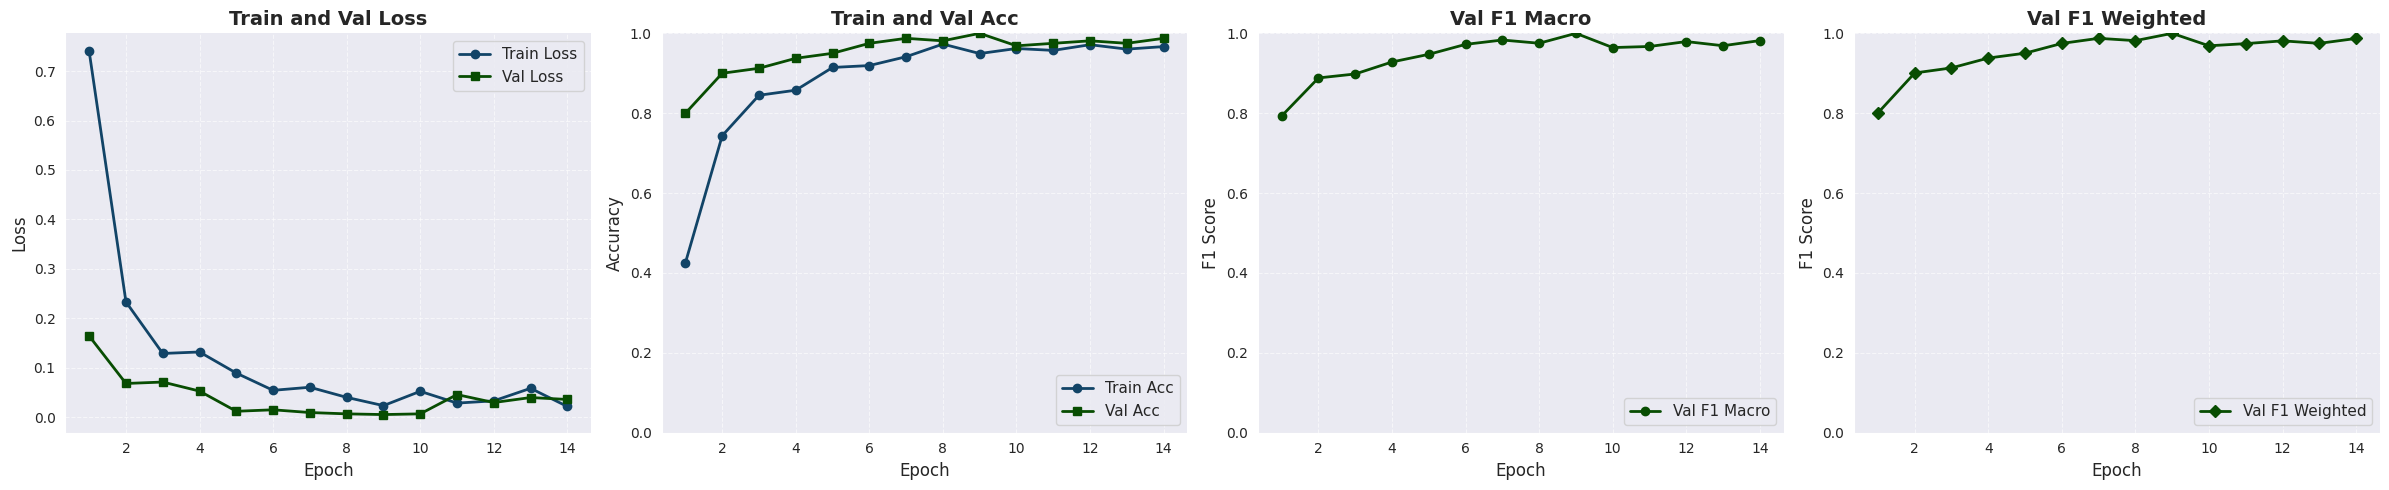


Fold 3 best F1: 1.0000

====================================================================== FOLD 4 ======================================================================
Train distribution: [36, 106, 58, 215, 72, 75, 77], Length: 639
Val distribution: [9, 26, 14, 54, 17, 19, 20], Length: 159


Validating: 100%|██████████| 20/20 [00:01<00:00, 12.43it/s]


Fold 4 | Epoch 1 | Train Loss: 0.7150 | Train Acc: 0.4351 | Val Loss: 0.1406 | Val Acc: 0.8679 | Val F1 Macro: 0.8558 | Val F1 Weighted: 0.8688
New best F1-macro for Fold 4 at epoch 1. Model saved. Current Best F1-macro: 0.8558


Validating: 100%|██████████| 20/20 [00:01<00:00, 12.43it/s]


Fold 4 | Epoch 2 | Train Loss: 0.1719 | Train Acc: 0.7864 | Val Loss: 0.1016 | Val Acc: 0.9182 | Val F1 Macro: 0.9080 | Val F1 Weighted: 0.9167
New best F1-macro for Fold 4 at epoch 2. Model saved. Current Best F1-macro: 0.9080


Validating: 100%|██████████| 20/20 [00:01<00:00, 12.31it/s]


Fold 4 | Epoch 3 | Train Loss: 0.1103 | Train Acc: 0.8687 | Val Loss: 0.1048 | Val Acc: 0.9182 | Val F1 Macro: 0.9074 | Val F1 Weighted: 0.9184


Validating: 100%|██████████| 20/20 [00:01<00:00, 12.27it/s]


Fold 4 | Epoch 4 | Train Loss: 0.0878 | Train Acc: 0.8766 | Val Loss: 0.1088 | Val Acc: 0.9182 | Val F1 Macro: 0.9088 | Val F1 Weighted: 0.9168
New best F1-macro for Fold 4 at epoch 4. Model saved. Current Best F1-macro: 0.9088


Validating: 100%|██████████| 20/20 [00:01<00:00, 12.30it/s]


Fold 4 | Epoch 5 | Train Loss: 0.0588 | Train Acc: 0.9193 | Val Loss: 0.1200 | Val Acc: 0.9497 | Val F1 Macro: 0.9399 | Val F1 Weighted: 0.9487
New best F1-macro for Fold 4 at epoch 5. Model saved. Current Best F1-macro: 0.9399


Validating: 100%|██████████| 20/20 [00:01<00:00, 12.43it/s]


Fold 4 | Epoch 6 | Train Loss: 0.0523 | Train Acc: 0.9525 | Val Loss: 0.1396 | Val Acc: 0.9560 | Val F1 Macro: 0.9472 | Val F1 Weighted: 0.9539
New best F1-macro for Fold 4 at epoch 6. Model saved. Current Best F1-macro: 0.9472


Validating: 100%|██████████| 20/20 [00:01<00:00, 12.47it/s]


Fold 4 | Epoch 7 | Train Loss: 0.0178 | Train Acc: 0.9620 | Val Loss: 0.1115 | Val Acc: 0.9497 | Val F1 Macro: 0.9404 | Val F1 Weighted: 0.9484


Validating: 100%|██████████| 20/20 [00:01<00:00, 12.42it/s]


Fold 4 | Epoch 8 | Train Loss: 0.0220 | Train Acc: 0.9668 | Val Loss: 0.1070 | Val Acc: 0.9497 | Val F1 Macro: 0.9404 | Val F1 Weighted: 0.9484


Validating: 100%|██████████| 20/20 [00:01<00:00, 12.41it/s]


Fold 4 | Epoch 9 | Train Loss: 0.0166 | Train Acc: 0.9731 | Val Loss: 0.1136 | Val Acc: 0.9497 | Val F1 Macro: 0.9364 | Val F1 Weighted: 0.9485


Validating: 100%|██████████| 20/20 [00:01<00:00, 12.37it/s]


Fold 4 | Epoch 10 | Train Loss: 0.0197 | Train Acc: 0.9636 | Val Loss: 0.1610 | Val Acc: 0.9434 | Val F1 Macro: 0.9375 | Val F1 Weighted: 0.9409


Validating: 100%|██████████| 20/20 [00:01<00:00, 12.61it/s]


Fold 4 | Epoch 11 | Train Loss: 0.0307 | Train Acc: 0.9620 | Val Loss: 0.1603 | Val Acc: 0.9434 | Val F1 Macro: 0.9331 | Val F1 Weighted: 0.9415
Early stopping at epoch 11

----- Classification Report -----
              precision    recall  f1-score   support

           0     0.9000    1.0000    0.9474         9
           1     1.0000    1.0000    1.0000        26
           2     1.0000    0.8571    0.9231        14
           3     0.9310    1.0000    0.9643        54
           4     0.9444    1.0000    0.9714        17
           5     1.0000    0.7368    0.8485        19
           6     0.9524    1.0000    0.9756        20

    accuracy                         0.9560       159
   macro avg     0.9611    0.9420    0.9472       159
weighted avg     0.9590    0.9560    0.9539       159


----- Confusion Matrix -----
[[ 9  0  0  0  0  0  0]
 [ 0 26  0  0  0  0  0]
 [ 1  0 12  0  0  0  1]
 [ 0  0  0 54  0  0  0]
 [ 0  0  0  0 17  0  0]
 [ 0  0  0  4  1 14  0]
 [ 0  0  0  0  0  0 20

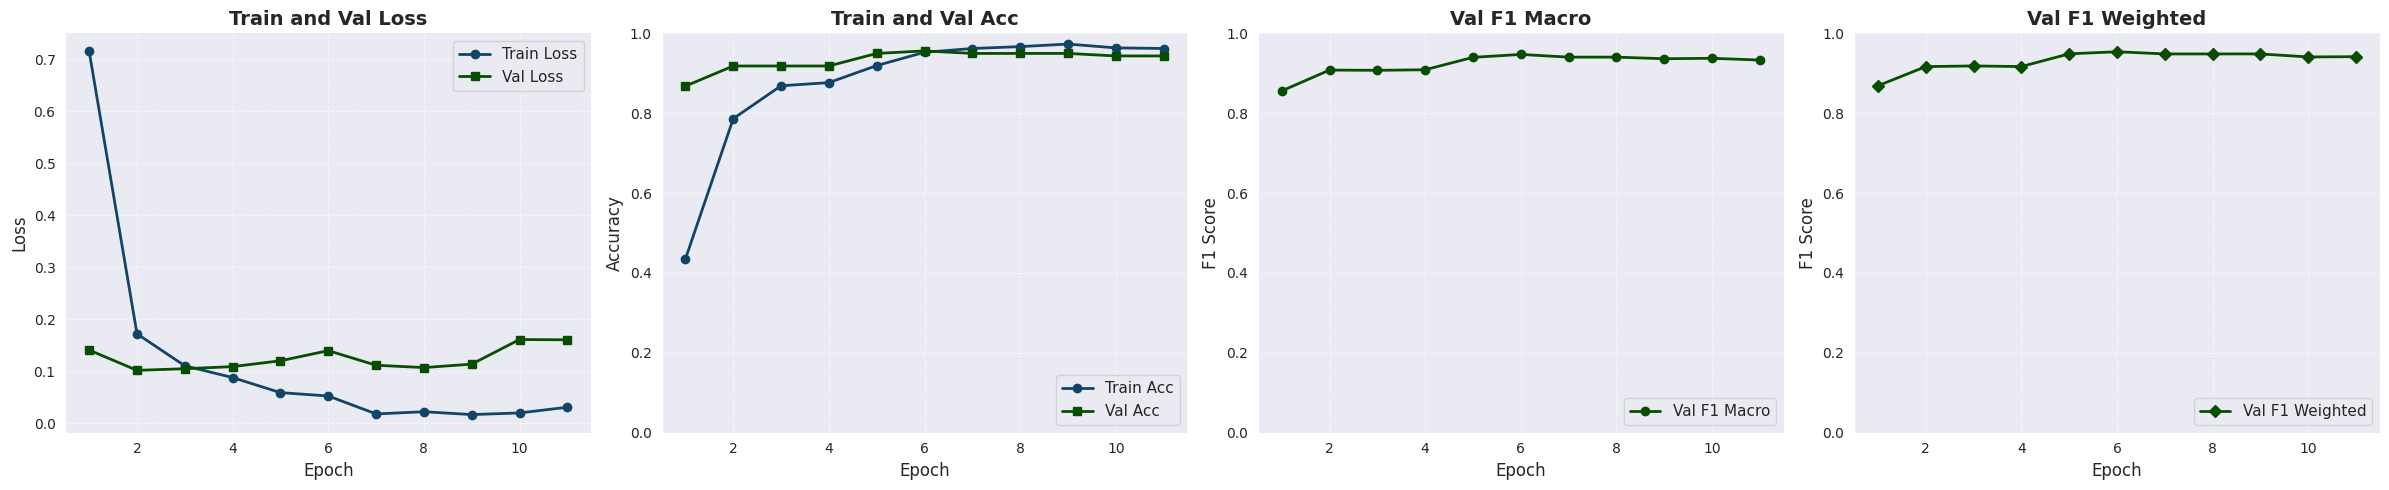


Fold 4 best F1: 0.9472

====================================================================== FOLD 5 ======================================================================
Train distribution: [36, 105, 58, 216, 71, 75, 78], Length: 639
Val distribution: [9, 27, 14, 53, 18, 19, 19], Length: 159


Validating: 100%|██████████| 20/20 [00:01<00:00, 12.19it/s]


Fold 5 | Epoch 1 | Train Loss: 0.6114 | Train Acc: 0.5000 | Val Loss: 0.1350 | Val Acc: 0.8176 | Val F1 Macro: 0.8108 | Val F1 Weighted: 0.8247
New best F1-macro for Fold 5 at epoch 1. Model saved. Current Best F1-macro: 0.8108


Validating: 100%|██████████| 20/20 [00:01<00:00, 12.30it/s]


Fold 5 | Epoch 2 | Train Loss: 0.1699 | Train Acc: 0.7927 | Val Loss: 0.0727 | Val Acc: 0.9182 | Val F1 Macro: 0.9114 | Val F1 Weighted: 0.9207
New best F1-macro for Fold 5 at epoch 2. Model saved. Current Best F1-macro: 0.9114


Validating: 100%|██████████| 20/20 [00:01<00:00, 12.33it/s]


Fold 5 | Epoch 3 | Train Loss: 0.1145 | Train Acc: 0.8845 | Val Loss: 0.0763 | Val Acc: 0.9434 | Val F1 Macro: 0.9336 | Val F1 Weighted: 0.9439
New best F1-macro for Fold 5 at epoch 3. Model saved. Current Best F1-macro: 0.9336


Validating: 100%|██████████| 20/20 [00:01<00:00, 12.56it/s]


Fold 5 | Epoch 4 | Train Loss: 0.0803 | Train Acc: 0.9003 | Val Loss: 0.0423 | Val Acc: 0.9371 | Val F1 Macro: 0.9325 | Val F1 Weighted: 0.9381


Validating: 100%|██████████| 20/20 [00:01<00:00, 12.53it/s]


Fold 5 | Epoch 5 | Train Loss: 0.0765 | Train Acc: 0.9177 | Val Loss: 0.0986 | Val Acc: 0.9308 | Val F1 Macro: 0.9127 | Val F1 Weighted: 0.9318


Validating: 100%|██████████| 20/20 [00:01<00:00, 12.49it/s]


Fold 5 | Epoch 6 | Train Loss: 0.0256 | Train Acc: 0.9462 | Val Loss: 0.0643 | Val Acc: 0.9560 | Val F1 Macro: 0.9477 | Val F1 Weighted: 0.9559
New best F1-macro for Fold 5 at epoch 6. Model saved. Current Best F1-macro: 0.9477


Validating: 100%|██████████| 20/20 [00:01<00:00, 12.60it/s]


Fold 5 | Epoch 7 | Train Loss: 0.0480 | Train Acc: 0.9620 | Val Loss: 0.0847 | Val Acc: 0.9686 | Val F1 Macro: 0.9619 | Val F1 Weighted: 0.9689
New best F1-macro for Fold 5 at epoch 7. Model saved. Current Best F1-macro: 0.9619


Validating: 100%|██████████| 20/20 [00:01<00:00, 12.57it/s]


Fold 5 | Epoch 8 | Train Loss: 0.0171 | Train Acc: 0.9636 | Val Loss: 0.0924 | Val Acc: 0.9560 | Val F1 Macro: 0.9446 | Val F1 Weighted: 0.9558


Validating: 100%|██████████| 20/20 [00:01<00:00, 12.68it/s]


Fold 5 | Epoch 9 | Train Loss: 0.0254 | Train Acc: 0.9573 | Val Loss: 0.0853 | Val Acc: 0.9497 | Val F1 Macro: 0.9360 | Val F1 Weighted: 0.9496


Validating: 100%|██████████| 20/20 [00:01<00:00, 12.76it/s]


Fold 5 | Epoch 10 | Train Loss: 0.0303 | Train Acc: 0.9620 | Val Loss: 0.0805 | Val Acc: 0.9686 | Val F1 Macro: 0.9645 | Val F1 Weighted: 0.9686
New best F1-macro for Fold 5 at epoch 10. Model saved. Current Best F1-macro: 0.9645


Validating: 100%|██████████| 20/20 [00:01<00:00, 12.59it/s]


Fold 5 | Epoch 11 | Train Loss: 0.0165 | Train Acc: 0.9715 | Val Loss: 0.0936 | Val Acc: 0.9497 | Val F1 Macro: 0.9377 | Val F1 Weighted: 0.9492


Validating: 100%|██████████| 20/20 [00:01<00:00, 12.76it/s]


Fold 5 | Epoch 12 | Train Loss: 0.0164 | Train Acc: 0.9620 | Val Loss: 0.1053 | Val Acc: 0.9623 | Val F1 Macro: 0.9559 | Val F1 Weighted: 0.9624


Validating: 100%|██████████| 20/20 [00:01<00:00, 12.50it/s]


Fold 5 | Epoch 13 | Train Loss: 0.0119 | Train Acc: 0.9715 | Val Loss: 0.1112 | Val Acc: 0.9623 | Val F1 Macro: 0.9582 | Val F1 Weighted: 0.9623


Validating: 100%|██████████| 20/20 [00:01<00:00, 12.47it/s]


Fold 5 | Epoch 14 | Train Loss: 0.0077 | Train Acc: 0.9794 | Val Loss: 0.1143 | Val Acc: 0.9560 | Val F1 Macro: 0.9467 | Val F1 Weighted: 0.9565


Validating: 100%|██████████| 20/20 [00:01<00:00, 12.37it/s]


Fold 5 | Epoch 15 | Train Loss: 0.0132 | Train Acc: 0.9826 | Val Loss: 0.1301 | Val Acc: 0.9497 | Val F1 Macro: 0.9407 | Val F1 Weighted: 0.9493
Early stopping at epoch 15

----- Classification Report -----
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000         9
           1     1.0000    0.9259    0.9615        27
           2     0.8750    1.0000    0.9333        14
           3     1.0000    0.9811    0.9905        53
           4     0.9474    1.0000    0.9730        18
           5     0.9444    0.8947    0.9189        19
           6     0.9500    1.0000    0.9744        19

    accuracy                         0.9686       159
   macro avg     0.9595    0.9717    0.9645       159
weighted avg     0.9704    0.9686    0.9686       159


----- Confusion Matrix -----
[[ 9  0  0  0  0  0  0]
 [ 0 25  0  0  1  0  1]
 [ 0  0 14  0  0  0  0]
 [ 0  0  0 52  0  1  0]
 [ 0  0  0  0 18  0  0]
 [ 0  0  2  0  0 17  0]
 [ 0  0  0  0  0  0 19

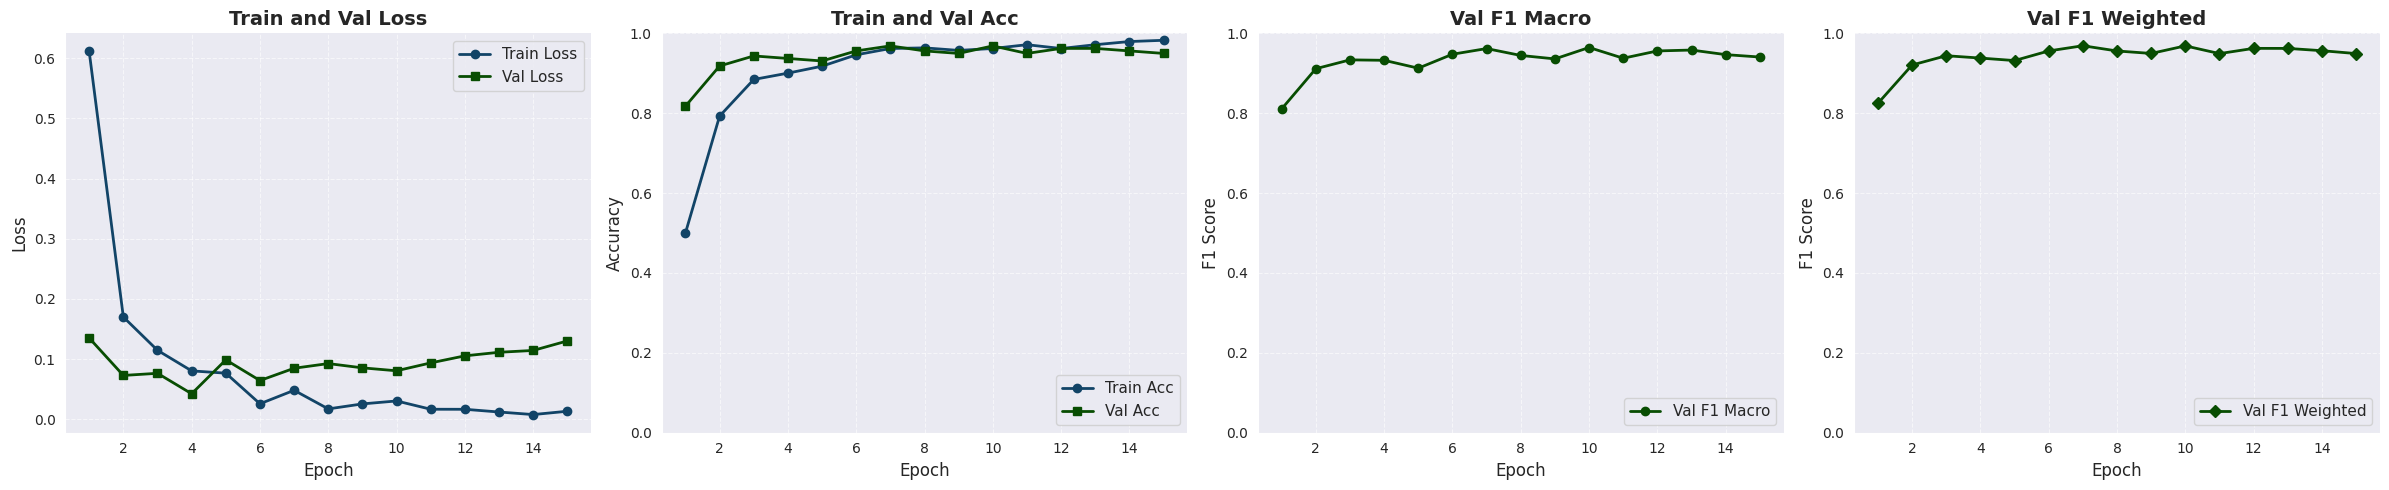


Fold 5 best F1: 0.9645

Cross-validation results:
Mean F1: 0.9696 ± 0.0172
Individual fold scores: [0.9716018456795634, 0.9646164021164021, 1.0, 0.9471791763466071, 0.9645141216569789]


In [47]:
# ===== Train with merged dataset =====
print("=" * 60)
print("PHASE 4: Retraining with Train + Pseudo-Labeled + Clustered Synthetic Data")
print("=" * 60)

final_fold_scores = train_cross_validation(
    merged_df, 
    pseudo_train=True, # MUST BE TRUE
    results_dir=PSEUDO_RESULTS_DIR
)

## 6.1 Final Predicton (Weighted Ensemble)

In [48]:
# Load the 10 models ( 5 initial + 5 pseudo-trained)
# also, make sure the models are loaded in order: CV first, then pseudo, 
# as we want to use the cross-validation scores as model weights

all_model_files = [f for f in os.listdir(CONFIG.models_dir) if f.endswith(".pth")]

cv_model_files = sorted([f for f in all_model_files if f.startswith("cv_fold_")])
pseudo_model_files = sorted([f for f in all_model_files if f.startswith("pseudo_fold_")])
sorted_model_files = cv_model_files + pseudo_model_files

models = load_models(sorted_model_files)

# Load the test set
test_loader = load_test_data()

# Load CV scores for weighting
cv_scores = np.load(os.path.join(CONFIG.models_dir, "cv_fold_scores.npy"))
pseudo_scores = np.load(os.path.join(CONFIG.models_dir, "pseudo_fold_scores.npy"))
print(f"\nCV Scores (Clean): {cv_scores}")
print(f"CV Scores (Pseudo-labeled + Clustered): {pseudo_scores}")

Loading models: 100%|██████████| 10/10 [00:19<00:00,  1.92s/it]


Loaded 10 models
Test set size: 144, batch size: 8

CV Scores (Clean): [0.9593704  0.94982563 0.94595453 0.99368693 1.        ]
CV Scores (Pseudo-labeled + Clustered): [0.97160185 0.9646164  1.         0.94717918 0.96451412]


In most scenarios, we should never trust pseudo-labels that much, they are a synthetic dataset that mimics the characteristics of real data, and they're generated artificially. that's why it's usually better to set a penalty to their models, like down-weighting their loss contribution, while giving higher importance to clean, manually labeled data

However, in this case, given the strict confidence thresholds we applied when generating the pseudo-labels (like 0.97+ and 90+ for clustering), I decided to treat them equally. I trust the model’s confidence enough to give pseudo-labeled samples the same weight as the clean ones

In [49]:
# Concatenate the scores
scores = np.concatenate([
    cv_scores,  # Initial 5 models (clean training)
    pseudo_scores, # * 0.9,  # Pseudo 5 models (no penalty)
])

In [50]:
# ======================
# Predict on test set
# ======================


all_preds, all_confidences, all_filenames, all_probs = ensemble_predict(models, test_loader, fold_scores=scores)

# We can also treat all models equally, without using model weights (cross-validation mean scores and pseudo cross-validation mean scores)
# all_preds, all_confidences, all_filenames, all_probs = ensemble_predict(models, test_loader)

Predicting: 100%|██████████| 18/18 [00:09<00:00,  1.85it/s]


Total predictions: 144
Average confidence: 0.9156
Min confidence: 0.3000
Max confidence: 0.9996

Model 1 | Weight: 0.099 | Fold score: 0.9594 | Type: Initial
Model 2 | Weight: 0.098 | Fold score: 0.9498 | Type: Initial
Model 3 | Weight: 0.098 | Fold score: 0.9460 | Type: Initial
Model 4 | Weight: 0.102 | Fold score: 0.9937 | Type: Initial
Model 5 | Weight: 0.103 | Fold score: 1.0000 | Type: Initial
Model 6 | Weight: 0.100 | Fold score: 0.9716 | Type: Pseudo
Model 7 | Weight: 0.099 | Fold score: 0.9646 | Type: Pseudo
Model 8 | Weight: 0.103 | Fold score: 1.0000 | Type: Pseudo
Model 9 | Weight: 0.098 | Fold score: 0.9472 | Type: Pseudo
Model 10 | Weight: 0.099 | Fold score: 0.9645 | Type: Pseudo


In [51]:
# Convert labels back to original labels
label2idx, idx2label = get_label_maps()
all_labels = [idx2label[pred] for pred in all_preds]

# 7. Submission

In [52]:
# Create submission
submission_df = pd.DataFrame({
    "filename": all_filenames,
    "label": all_labels
})

submission_df.to_csv(
    os.path.join(CONFIG.processed_data_dir, "final_submission.csv"), 
    index=False
)

# Create submission with confidence
submission_conf_df = pd.DataFrame({
    "filename": all_filenames,
    "label": all_labels,
    "confidence": all_confidences,
})

submission_conf_df.to_csv(
    os.path.join(CONFIG.processed_data_dir, "final_submission_with_confidence.csv"), 
    index=False
)

print(f"Final submission saved with {len(submission_df)} predictions")

Final submission saved with 144 predictions


In [53]:
display(submission_df)
display(submission_conf_df)

filename    label
0    0306fa89.jpg  Barbari
1    0345e3ca.jpg    Roman
2    0551a473.jpg  Sawakni
3    06e1783d.jpg     Goat
4    08b9981b.jpg  Barbari
..            ...      ...
139  f3e7b1fe.jpg    Roman
140  faadf33d.jpg    Roman
141  fbf2e74c.jpg  Sawakni
142  ff19c491.jpg  Sawakni
143  ffa67e5c.jpg  Barbari

[144 rows x 2 columns]

filename    label  confidence
0    0306fa89.jpg  Barbari    0.996361
1    0345e3ca.jpg    Roman    0.987190
2    0551a473.jpg  Sawakni    0.997693
3    06e1783d.jpg     Goat    0.482115
4    08b9981b.jpg  Barbari    0.954187
..            ...      ...         ...
139  f3e7b1fe.jpg    Roman    0.996509
140  faadf33d.jpg    Roman    0.998718
141  fbf2e74c.jpg  Sawakni    0.842657
142  ff19c491.jpg  Sawakni    0.821500
143  ffa67e5c.jpg  Barbari    0.777294

[144 rows x 3 columns]

Let’s now check how things changed between the initial training phase (before we added pseudo-labels and clustering) and the final training phase (after enriching the dataset). Specifically, let’s see which images ended up with a different label, these are the ones where the model changed its mind after being exposed to more data

Let’s visualize those flipped predictions:

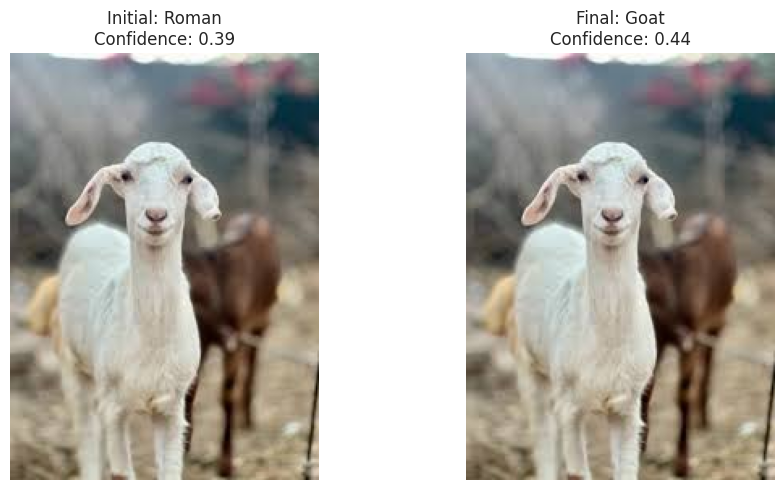

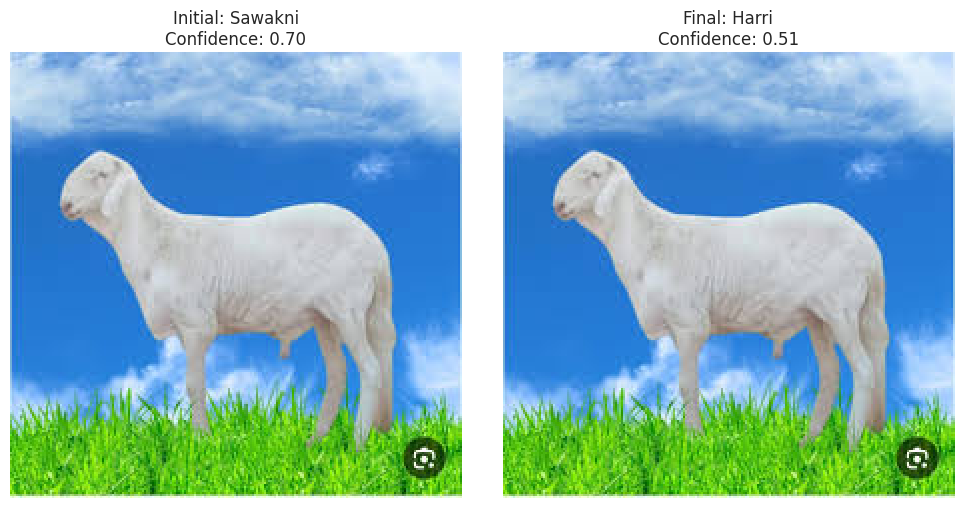

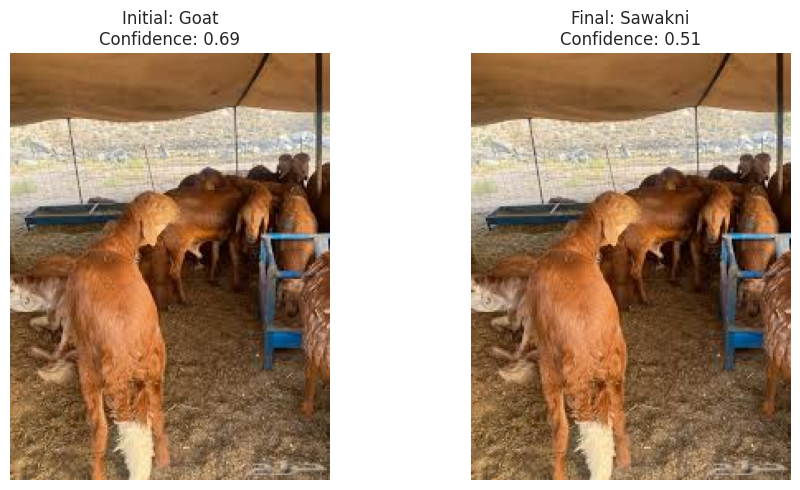

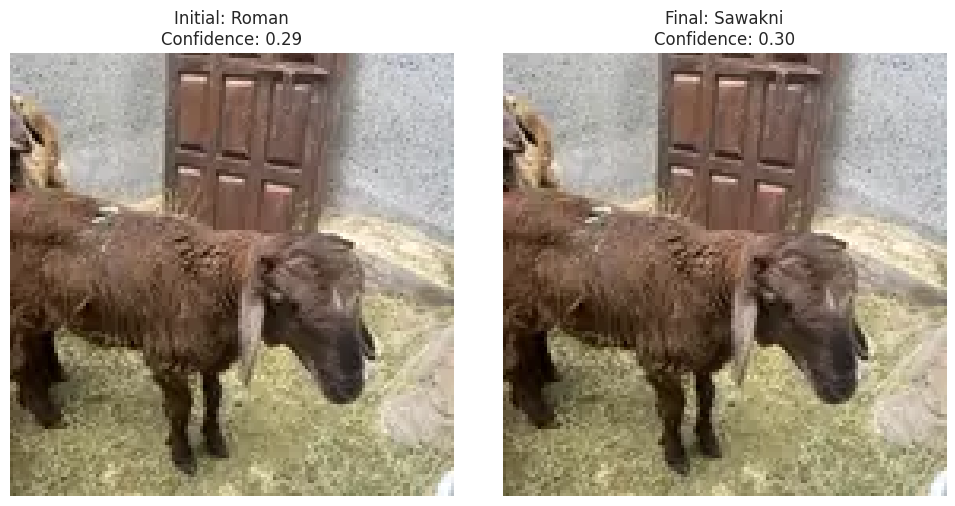

In [55]:
initial_res = pd.read_csv(os.path.join(CONFIG.processed_data_dir, "initial_submission_with_confidence.csv"))
final_res = pd.read_csv(os.path.join(CONFIG.processed_data_dir, "final_submission_with_confidence.csv"))
merged = initial_res.merge(final_res, on='filename', suffixes=('_initial', '_final'))

pred_changed = merged[merged['label_initial'] != merged['label_final']]
for _, row in pred_changed.iterrows():
    im = row['filename']
    
    img = cv2.imread(os.path.join(CONFIG.test_dir, im))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    _, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    axes[0].imshow(img)
    axes[0].set_title(f"Initial: {row['label_initial']}\nConfidence: {row['confidence_initial']:.2f}")
    axes[0].axis('off')
    
    axes[1].imshow(img)
    axes[1].set_title(f"Final: {row['label_final']}\nConfidence: {row['confidence_final']:.2f}")
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()

And here the sheeps saying **BAA** 🐑😂

That's it, we're done!

For those who are curious or want to dive deeper, I’ve pushed the full project to [GitHub](https://github.com/ahmedsalim3/sheep-classification-challenge/tree/main)
Hope you learned something from this walkthrough, or at least found it a little helpful

Until our next competition, stay curious and keep experimenting 

# 8. Refrences

- [Albumentations](https://albumentations.ai/)
-[*An Image is Worth 16x16 Words*](https://arxiv.org/pdf/2010.11929)
- [timm-model: vit_base_patch16_224.augreg_in21k_ft_in1k](https://huggingface.co/timm/vit_base_patch16_224.augreg_in21k_ft_in1k)
- [UMAP: Uniform Manifold Approximation and Projection](https://arxiv.org/pdf/1802.03426)
- [A Density-Based Algorithm for Discovering Clusters in Large Spatial Databaseswith Noise](https://cdn.aaai.org/KDD/1996/KDD96-037.pdf)
- [Emerging Properties in Self-Supervised Vision Transformers](https://arxiv.org/pdf/2104.14294)
- [Self-Supervised Representation Learning](https://lilianweng.github.io/posts/2019-11-10-self-supervised/)